In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil, os, random, gc, time, traceback
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K

from keras.applications import InceptionV3, VGG16, ResNet50, InceptionResNetV2, DenseNet201

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.losses import binary_crossentropy, categorical_crossentropy

import cache_magic
%matplotlib inline

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = "{:,.2f}".format

DATA_PATH = './data/'
MODEL_PATH = './model'

# DeepFashion: Versión reducida

En este notebook se realiza la comparativa entre un único modelo multietiqueta y un modelo compuesto por sub-modelos por tipo de atributo. 

Se emplea la versión reducida del conjunto de datos de DeepFashion. En análisis descriptivo de este conjunto de datos se realiza en un [Notebook anexo](./DeepFashion_VersionReducida_Analisis.ipynb). También se ha realizado [el mismo análisis](./DeepFashion_VersionCompleta_Analisis.ipynb) de la versión completa del dataset.

Para el particionado de datos en los conjuntos de entrenamiento, validación y test se emplean las particiones proporcionadas junto con el conjunto de datos. 

In [3]:
# Constantes

# Rutas a directorios de datos
ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
TRAIN_PATH = ANNO_FINE_PATH + '/train'
VALIDATION_PATH = ANNO_FINE_PATH + '/val'
TEST_PATH = ANNO_FINE_PATH + '/test'
AUGMENTED_DATA_PATH = ANNO_FINE_PATH + '/augmented'
IMG = DATA_PATH + 'img'

# Rutas a ficheros de datos
ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'

# Constantes relativas al conjunto de datos
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}
NUM_CLASSES = 26 


## 1. Lectura y preprocesado de datos

En primer lugar se crea una serie de estructuras de datos auxiliares para facilitar el trabajo con el dataset

In [4]:
# Lectura de la lista de atributos (fichero list_attr_cloth.txt)
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

In [5]:
# column_to_attr_name: Mapping número columna -> Nombre de atributo
# attr_type_to_columns: Mapping tipo de atributo - Lista de columnas de atributos de dicho tipo
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
# Listado con los nombre de los atributos
attributes = list(column_to_attr_name.values())

Extraemos las imágenes que forman parte de cada una de las paticiones, y las copiamos en un directorio con el nombre de la partición (test, val, train):

In [6]:
# Devuelve el listado de imágnes del fichero recibido como parámetro
def read_image_list(file_name):
    file_path = ANNO_FINE_PATH + '/' + file_name + '.txt'
    with open(file_path) as fp:
        return [DATA_PATH + img.rstrip('\n') for img in fp]
    
# Devuelve el path de la partición a partir del nombre de la partición
def build_partition_data_path(partition):
    return ANNO_FINE_PATH + '/' + partition

# Creación de la estructura de datos necesaria para los generadores de aumentación de datos
def create_data_structure(force=False):
    for partition in ['test', 'train', 'val']:
        partition_data_path = build_partition_data_path(partition)
        
        # Forzar recarga
        if os.path.exists(partition_data_path) and force:
            shutil.rmtree(partition_data_path)
        
        if not os.path.exists(partition_data_path):
            os.mkdir(partition_data_path)
            # Carga del listado de imágenes
            image_list = read_image_list(partition)
            # Copia
            for i, src in enumerate(image_list):
                dst = partition_data_path + '/' + str(i) + '.jpg' 
                shutil.copyfile(src, dst)


In [7]:
create_data_structure(False)

## 2. Aumentación de datos

A continuación se define la función que crea los generadores de imágenes, que realizan las transformaciones de data augmentation de forma dinámica en cada epoch del entrenamiento de los modelos. Se han configurado de forma que las imagenes generadas se almacenen en el directorio definidos por la constante AUGMENTED_DATA_PATH para poder ser inspeccionados. 

La función es parametrizable para poder realizar un análisis de los valores óptimos y elegir los más adecuados para esta tarea de clasificación. Este análisis se realiza más adelante.

In [8]:
# Construcción del dataframe requerido para usar la función flow_from_dataframe
def build_iterator_dataframe(partition, attr_type=None):
    partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
    print(partition_attribute_filepath)
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
    # Filtrado por tipo de atributo. Empleado para los clasificadores separados por tipo de atributo. 
    if attr_type is not None:
        columns = attr_type_to_columns[str(attr_type)]
        fst, lst = columns[0], columns[-1]+1
        data = data.iloc[:, fst:lst]
    
    data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    
    return data

In [9]:
def get_attributes_for_attribute_type(attr_type):
    if attr_type is None:
        return attributes
    else:
        return [column_to_attr_name[c] for c in attr_type_to_columns[str(attr_type)]]

In [10]:
SEED = 1
BATCH_SIZE = 4


# Construcción del generador de datos de entrenamiento
def build_train_datagen(shear_range=0.025, zoom_range=0.025, rotation_range=2.5, fill_mode='nearest'):
    return ImageDataGenerator(
        rescale=1/255.0,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        fill_mode = fill_mode,
        horizontal_flip=True)

# Construcción de los generadores de datos de entrenamiento y validación
def build_generators(img_size, shear_range, zoom_range, rotation_range, fill_mode, attr_type = None):
        
    # Borrar los directorios con las imagenes generadas
    if os.path.exists(AUGMENTED_DATA_PATH):
        shutil.rmtree(AUGMENTED_DATA_PATH)
    os.mkdir(AUGMENTED_DATA_PATH)
    
    # Generator de entrenamiento
    train_datagen = build_train_datagen(shear_range, zoom_range, rotation_range, fill_mode)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = build_iterator_dataframe('train', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=TRAIN_PATH,
        target_size=(img_size,img_size),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED,
        save_to_dir=AUGMENTED_DATA_PATH
    )
    
    print(TRAIN_PATH)

    # Generator de validación
    validation_datagen = ImageDataGenerator(
         rescale=1./255
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('val', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=VALIDATION_PATH,
        target_size=(img_size,img_size),
        #batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED
    )
    
    return train_generator, validation_generator


# Construcción del generador de datos de test
def build_test_generator(img_size=224, attr_type = None):
        
    test_datagen = ImageDataGenerator(
         rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('test', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),        
        directory=TEST_PATH,
        target_size=(img_size,img_size),
       # batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='rgb',
        seed=SEED,
        shuffle=False
    )
    
    return test_generator 

El siguiente código elige de forma aleatoria una imagen de la partición de test, y muestra 9 imagenes alteradas generadas con el código definido anteriormente. 

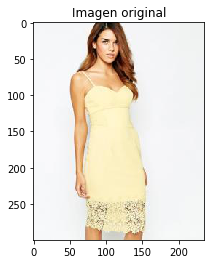

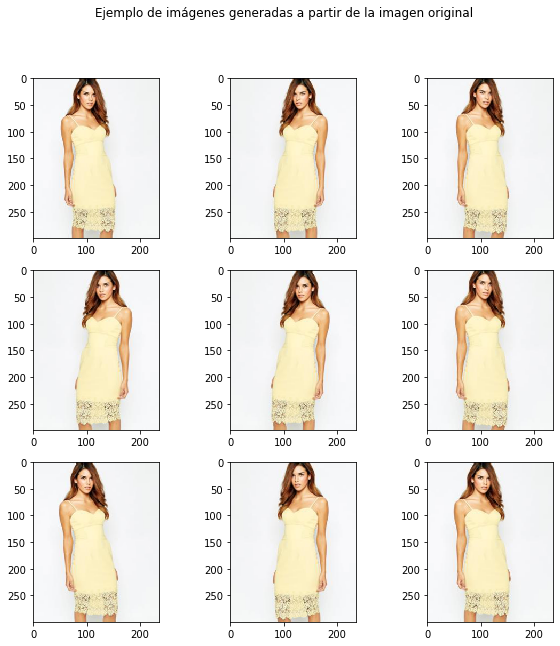

In [11]:
# Carga de una imagen aleatoria
path = ANNO_FINE_PATH + '/test'
file = random.choice(os.listdir(path))
img = load_img('{}/{}'.format(path, file))

plt.title('Imagen original')
plt.imshow(img)
plt.show()

# Preprocesado y preparación del iterador
data = img_to_array(img)
samples = np.expand_dims(data, 0)

generator = build_train_datagen()
it = generator.flow(samples, batch_size=1)

# Generación de 9 imágenes a partir de la imagen original
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Ejemplo de imágenes generadas a partir de la imagen original')
for x in range(9):
    batch = it.next()
    axs[x//3,x%3].imshow(batch[0], cmap='gray')
plt.show()

## 3. Automatización

Para poder probar distintos modelos de forma simple se define una función **_train_** que encapsula todo el código necesario para realizar el entrenamiento (limpieza de sesiones anteriores, instanciación del modelo y generadores de datos, etc...) 

Cabe destacar que se llama a la función fit con tres callbacks:
- Checkpoint, para persistir el modelo que minimiza el loss y poder ser empleado más adelante, en los casos en los que un modelo empiece a sobreajustar a los datos de entrenamiento. 
- Reducción de learning rate en el caso de que en N iteraciones seguidas el modelo no mejore. Viene definido por la constante LR_REDUCTION_PATIENCE. 
- Early stopping, para realizar la parada del entrenamiento en el caso de que no se consiga una mejora ni reduciendo la velocidad de aprendizaje. Viene definido por la constante EARLY_STOPPING_PATIENCE. 

Nótese que la función **_train_** requiere de dos parámetros obligatorios: model_name y model_id. Es primero es necesario porque, para realizar la instanciación del modelo se realiza una llamada una función con nombre **_build\_{model\_name}_**. El segundo parámetro es empleado a la hora de generar el nombre con el que persiste un modelo (**_model\_name\_model\_id.h5}_**) para poder persistir distintas versiones de un mismo tipo de modelo.

Esto permite que el código sea genérico y baste con definir una función **_build\_{model\_name}_** para poder entrenar y validar un modelo nuevo. 


In [12]:
# Definición de la función de loss empleada por defecto. 
# Detallado en la sección "Selección de función de loss"

import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [13]:
EARLY_STOPPING_PATIENCE = 8
LR_REDUCTION_PATIENCE = 4

# Conversión del tamaño de la imagen al shape esperado como input del modelo
def to_input_shape(img_size):
    return (img_size,img_size,3)

# Construcción del path donde se persiste el modelo
def to_model_path(model_name, model_id, attr_type = None):
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    if attr_type is None:
        return '{}/{}_{}.h5'.format(MODEL_PATH, model_name, model_id)
    else:
        return '{}/{}_{}_{}.h5'.format(MODEL_PATH, model_name, model_id, attr_type)

# Construcción del nombre de la función de instanciación de un modelo
def to_build_function(model_name):
    return 'build_' + model_name

# Desactiva el entrenamiento del X% de capas iniciales. 
def freeze_layers(model, ratio=0.5):
    n_layers = len(model.layers)
    last_layer_to_freeze = int(n_layers*ratio)
    
    for layer in model.layers[:last_layer_to_freeze]:
        layer.trainable = False
    for layer in model.layers[last_layer_to_freeze:]:
        layer.trainable = True
    
    return model

def build_callbacks(model_name, model_id, store_model, attr_type):
    callbacks = []
    # Parar la ejecución si el loss no disminuye en 3 iteraciones
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-4)
    callbacks.append(early_stopping)
    # Reducir el learning rate si el loss no disminuye en 3 iteraciones
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_REDUCTION_PATIENCE, verbose=1, min_delta=1e-4)  
    callbacks.append(reduce_lr)
    # Guardar el modelo que más disminuye el loss en fichero
    if store_model:
        checkpoint = ModelCheckpoint(filepath = to_model_path(model_name, model_id, attr_type), 
                                     monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks.append(checkpoint)
    return callbacks

# Entrenamiento, y todo el pre-procesamiento necesario. 
def train(model_name,
          model_id=None,
          max_epochs=100, 
          img_size=224,
          shear_range=0.05, 
          zoom_range=0.150, 
          rotation_range=2.5, 
          fill_mode='constant',
          store_model=True,
          two_step_fit=False,
          freeze_layers_ratio=None,
          model_build_params=None,
          loss_function=weighted_binary_crossentropy,
          attr_type=None
         ):
    
    # Forzar limpieza y pasar el GC
    K.clear_session()
    #cuda.select_device(0)
    #cuda.close()
    gc.collect()
    
    # Instanciación del modelo. Todos los métodos siguen el patrón "build_xxx", donde xxx es esl nombre del modelo
    input_shape = to_input_shape(img_size)
    model = globals()[to_build_function(model_name)](input_shape, model_build_params)
    #model.summary()
    
    # COMPILE con run options para debug en caso de oom
    #run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    # Instanciación de los generators de datos
    train_generator, validation_generator = build_generators(img_size, shear_range, 
                                                             zoom_range, rotation_range, fill_mode, attr_type)
    
    
    
    # FIT
    # Dependiendo de la complejidad del modelo, se hace fit una única vez, o dos veces para ajustar primero las últimas capas
    # y posteriormente el resto
    if two_step_fit:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, False, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
        # Segunda fase de training para entrenar el resto de las capas
        model = freeze_layers(model, freeze_layers_ratio)
        model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    else:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    
    return (h.history['val_loss'], h.history['val_accuracy'], h.history['val_auc'])

In [14]:
def plot(results, metric, legend_loc = 'upper right'):
    legend = []
    fig = plt.figure(figsize=(15,10))
    for k,v in results.items():
        plt.plot(v)
        legend.append(k)
    plt.title('Comparativa de ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legend, loc=legend_loc)
    figsize=(10,8)
    plt.show()  

## 4. Optimización de hiperparámetros

Para la búsqueda de valores óptimos para distintos parámetros empleados por el proceso se empleará un modelo 'baseline'. Éste se basa en una arquitectura ResNet50 con función de activación sigmoide para permitir la clasificación multietiqueta. 

In [15]:
def build_baseline(a,b):
    base_model = ResNet50(
        include_top=True,
        weights="imagenet",
        input_shape=(224,224,3),
        pooling='max'
        )
    x = base_model.output
    x = Dense(64, activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

### 4.1 Tamaño de la imagen

De momento se obvia la comprobación de si el tamaño de la imagen influye en el resultado de clasificación

### 4.2 Parámetros de data augmentation

Vamos a comprobar como influyen los parámetros de data augmentation sobre el accuracy. Se trata de encontrar valores equilibrados puesto que valores muy bajos pueden causar que el modelo no sea capaz de generalizar correctamente, mientas que con valores muy altos se estén realizando transformaciones muy alejadas de la realidad de los datos. 

In [16]:
N = 25

def evaluate_data_augmentation_params():  
    results = pd.DataFrame(columns = ['shear_range','zoom_range', 'rotation_range', 'fill_mode', 'val_loss','val_accuracy', 'val_auc'])
    for it in range(0,N):
        shear_range = random.choice([0.025, 0.05, 0.1, 0.15])
        zoom_range = random.choice([0.025, 0.05, 0.1, 0.15])
        rotation_range = random.choice([2.5, 5, 7.5])
        fill_mode = random.choice(["constant", "nearest", "wrap"]) # Ignoramos reflect
        print('Evaluation #{}'.format(it))
        (val_loss, val_acc, val_auc) = train('baseline', it, store_model=False,
                                             shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                             fill_mode = fill_mode, img_size=224)
        results.loc[it] = [shear_range, zoom_range, rotation_range, fill_mode, min(val_loss), max(val_acc), max(val_auc)]
    return results

In [17]:
%cache data_augmentation_results = evaluate_data_augmentation_params()
data_augmentation_results.sort_values(by='val_loss', ascending=True).head(n=10)

Loading cached value for variable 'data_augmentation_results'. Time since caching: 3 days, 20:06:16.614987


,shear_range,zoom_range,rotation_range,fill_mode,val_loss,val_top_k_categorical_accuracy
21,0.05,0.15,2.50,constant,0.35,0.50
11,0.05,0.10,5,wrap,0.35,0.47
13,0.03,0.05,2.50,wrap,0.35,0.44
1,0.10,0.15,2.50,constant,0.35,0.39
18,0.10,0.10,7.50,constant,0.35,0.45
17,0.10,0.15,7.50,nearest,0.35,0.48
7,0.05,0.03,5,nearest,0.35,0.50
20,0.10,0.05,7.50,constant,0.35,0.38
23,0.10,0.05,5,constant,0.35,0.48
24,0.05,0.15,7.50,constant,0.35,0.52


Se establece los valores que minimizan el valor de loss sobre el conjunto de validación como los valores por defecto a emplear en la aumentación de datos, y serán los que se usarán para el entrenamiento de los modelos de los siguientes apartados. 

### 4.3 Selección de función de loss

En pruebas realizadas con anterioridad se ha comprobado que el accuracy no es una buena métrica para este problema puesto que hasta con el modelo más simple se consiguen valores superiores al 80%. Esto se debe a que esta métrica es el promedio del número etiquetas predicho correctamente dividido entre el número total de etiquetas para cada una de las observaciones, tal y como se comenta en [aquí](https://stackoverflow.com/questions/50686217/keras-how-is-accuracy-calculated-for-multi-label-classification). En el caso de este dataset existen 26 clases, y cada observación está asociada a 6 valores positivos y a 20 negativos. Este alto número de valores negativos hace que se obtenga siempre un valor alto de accuracy, por lo que se ha optado por emplear el área bajo la curva ROC (AUC) puesto que se considera que esta métrica, al estar basada en la relación entre sensibilidad y especificidadad, se ajusta más al problema en cuestión. 

Por otro lado, se ha hecho una comparativa entre dos funciones de loss que se emplean comunmente para las clasificaciones multietiqueta: binary cross entropy y weighted binary crossentropy. El hecho de que por cada observación existan 20 etiquetas con valor 0 y 6 con valor 1 hace pensar que asignándole un peso superior al valor 1 se conseguirá un resultado mejor. 

Esta última función se encuentra disponible en Tensorflow pero no está adaptada para ser usada directamente desde Keras, por lo que se emplea el código publicado abiertamente en un artículo de [StackExchange](https://stats.stackexchange.com/questions/261128/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu). El código se ha definido en el apartado anterior. 

Se entrena el modelo baseline empleando las dos funciones de loss, y se establece la comparativa.

In [18]:
RESET = False
if(RESET):
    %cache -r res_binary_crossentropy
    %cache -r res_weighed_crossentropy

%cache res_binary_crossentropy = train('baseline', loss_function=binary_crossentropy, store_model=False)
%cache res_weighed_crossentropy = train('baseline', loss_function=weighted_binary_crossentropy, store_model=False)

Loading cached value for variable 'res_binary_crossentropy'. Time since caching: 1 day, 1:09:42.096539
Loading cached value for variable 'res_weighed_crossentropy'. Time since caching: 1 day, 1:02:54.095853


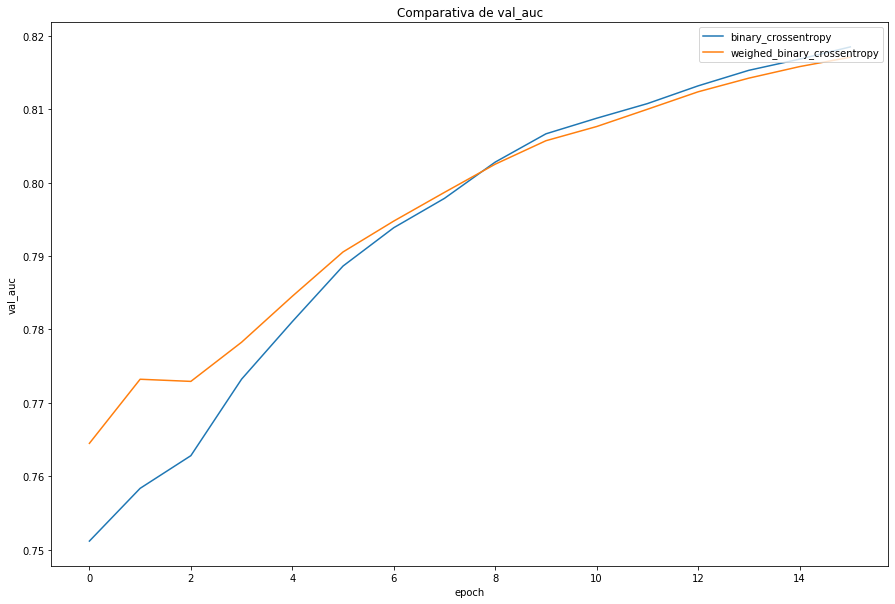

Max. val_auc binary_crossentropy: 0.8184903860092163
Max. val_auc weighed_binary_crossentropy:0.8170831799507141


In [19]:
results = {'binary_crossentropy' : res_binary_crossentropy[1], 'weighed_binary_crossentropy' : res_weighed_crossentropy[1]}
plot(results, metric='val_auc')

print('Max. val_auc binary_crossentropy: {}'.format(max(res_binary_crossentropy[1])))
print('Max. val_auc weighed_binary_crossentropy:{}'.format(max(res_weighed_crossentropy[1])))

A partir de la gráfica anterior se puede comprobar que no existe apenas diferencia entre ambas métricas. Se empleará weighed_binary_crossentropy. Si bien para el dataset reducido puede que no tenga mucha diferencia, es posible que sí la tenga cuando se repita el mismo análisis con el dataset completo en el que los datos son mucho más disperos, y la proporción de 0s es muy superior a la de 1s. 

## 5. Entrenamiento

En este apartado se probarán varias arquitecturas de redes pre-entrenadas disponibles con Keras. Estas redes permiten inicializar los valores a pesos entrenandos sobre ImageNet, por lo que permite beneficiarse del _transfer learning_ y poder congelar un número de capas iniciales ya pre-entrenadas para detectar las características más abstractas.

El entrenamiento se realiza en dos pasos:
1. Se congelan todas las capas del modelo pre-entrenado para entrenar únicamente las capas densas añadidas en la parte final de la red.
2. Se descongela un porcentaje de las últimas capas del modelo pre-entrenado y se repite el entrenamiento.

Todos los modelos entrenados se persisten junto a un ID para poder ser recuperados posteriormente en el apartado de evaluación. 

Para cada tipo de modelo se realiza un random search para encontrar los valores óptimos de los hiperparámetros. En todos ellos se emplea la sigmoid como función de activación en la capa de salida para poder obtener un valor entre 0 y 1 para todas las etiquetas. 

Los hiperparámetros que se prueban son:
* Tipo de poling: avg, max o sin pooling.
* Número de neurnas en la última capa densa: entre 128 y 512
* Porcentaje de capas iniciales a congelar: entre 50 y 80%. 

Se emplea Adam como optimizador para todos los modelos. No se ha hecho una comparativa con otros optimizadores. 

In [20]:
def build_InceptionV3(input_shape, params):
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_ResNet50(input_shape, params):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_VGG16(input_shape, params):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_InceptionResNetV2(input_shape, params):
    base_model = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_DenseNet201(input_shape, params):
    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


A continuación se define el código para realizar un random search de los parámetros. Se realizará una exploración de N (20) combinaciones por cada arquitectura probada.

In [21]:
KERNEL_SIZE_PARAM = "kernel_size"
DROPOUT_PARAM = "dropout"
GLOBAL_POOLING_TYPE = "global_pooling_type"
DENSE_LAYER_SIZE_PARAM = 'dense_layer_size'
NUM_BLOCKS_PARAM = "num_blocks"
FIRST_CONV_LAYER_SIZE = "first_conv_layer_size"
ACTIVATION_FUNCTION = "activation_function"
OUTPUT_LAYER_SIZE = "output_layer_size"

N = 20

def freeze_all_layers(model):
    for layer in model.layers:
        layer.trainable = False

def try_pretrained_model(model_name, 
                         attr_type=None, 
                         activation_function = 'sigmoid', 
                         loss_function = weighted_binary_crossentropy,
                         output_layer_size = NUM_CLASSES):
    results = pd.DataFrame(columns = [GLOBAL_POOLING_TYPE, DENSE_LAYER_SIZE_PARAM, 'freeze_layers_ratio', 'val_loss', 'val_acc', 'val_auc', 'time'])
    for i in range(0, N):
        try:
            # Random search de los parámetros
            params = {}
            params[GLOBAL_POOLING_TYPE] = random.choice(['avg', 'max', None])
            params[DENSE_LAYER_SIZE_PARAM] = random.randrange(128,513,8)
            freeze_layers_ratio = random.choice([0.5, 0.6, 0.7, 0.8])
            
            # Definición de la función de activación para usar en la capa de salida
            params[ACTIVATION_FUNCTION] = activation_function
            params[OUTPUT_LAYER_SIZE] = output_layer_size
            
            print('Evaluation #{}'.format(i))
            start = time.time()
            
            # Llamada a la función de entrenamiento definida en apartados anteriores
            (val_loss,  val_acc, val_auc) = train(model_name, i, store_model=True, two_step_fit=True, 
                                        freeze_layers_ratio=freeze_layers_ratio, model_build_params=params, 
                                        attr_type=attr_type, loss_function=loss_function)
            end = time.time() - start
            
            # Acumulación de los resultados
            results.loc[i] = [params[GLOBAL_POOLING_TYPE], params[DENSE_LAYER_SIZE_PARAM], freeze_layers_ratio, val_loss, val_acc, val_auc, end]
        except Exception as e:
            traceback.print_exc()
            print('Error: {}'.format(e))
            print('Error with params: {}'.format(params))
    return results

Lanzamos la búsqueda:

In [22]:
RESET = False
if(RESET):
    %cache -r results_inceptionV3
    %cache -r results_resnet50 
    %cache -r results_vgg16
    %cache -r results_inceptionResNetV2
    %cache -r results_densenet201    

%cache results_inceptionV3 = try_pretrained_model('InceptionV3')
%cache results_resnet50 = try_pretrained_model('ResNet50')
%cache results_vgg16 = try_pretrained_model('VGG16')
%cache results_inceptionResNetV2 = try_pretrained_model('InceptionResNetV2')
%cache results_densenet201 = try_pretrained_model('DenseNet201')

Loading cached value for variable 'results_inceptionV3'. Time since caching: 1 day, 16:13:41.949927
Loading cached value for variable 'results_resnet50'. Time since caching: 1 day, 14:05:27.419734
Loading cached value for variable 'results_vgg16'. Time since caching: 1 day, 11:43:59.562810
Loading cached value for variable 'results_inceptionResNetV2'. Time since caching: 1 day, 7:36:14.854518
Loading cached value for variable 'results_densenet201'. Time since caching: 1 day, 2:27:00.200839


Definimos una función para ordenar los modelos generados en función del valor mínimo de loss sobre el conjunto de validación. El índice de la tabla representa el model_id con el que se ha persistido el modelo, para poder ser recuperado en la fase de evaluación. 

In [23]:
# Ordena todos los modelos en base al máximo accuracy conseguido.  
def sort_by_max_accuracy(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["val_auc"] = df.apply(lambda row: max(row['val_auc']), axis=1)
    df = df.drop(columns=['val_loss', 'val_auc'])
    return df.sort_values(by='min_val_loss', ascending=True).head(n=5)

Mostramos los resultados obtenidos para la arquitectura InceptionV3:

In [24]:
results_inceptionV3 = sort_by_max_accuracy(results_inceptionV3)
results_inceptionV3

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
16,avg,192,0.70,443.41,0.87
19,avg,472,0.80,359.38,0.88
13,avg,200,0.80,369.89,0.88
12,max,376,0.70,460.92,0.90
11,max,400,0.60,498.75,0.93


Mostramos los resultados obtenidos para la arquitectura ResNet50:

In [25]:
results_resnet50 = sort_by_max_accuracy(results_resnet50)
results_resnet50

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
10,None,192,0.60,521.01,1.11
4,max,160,0.70,464.56,1.21
5,avg,416,0.60,367.09,1.22
18,None,336,0.60,423.61,1.22
15,avg,160,0.50,476.18,1.24


Mostramos los resultados obtenidos para la arquitectura VGG16:

In [26]:
results_vgg16 = sort_by_max_accuracy(results_vgg16)
results_vgg16

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
0,max,512,0.80,438.70,0.70
6,avg,264,0.80,489.07,0.80
7,avg,216,0.80,597.26,0.80
16,None,384,0.80,333.97,0.82
1,None,432,0.80,456.92,0.83


In [27]:
results_inceptionResNetV2 = sort_by_max_accuracy(results_inceptionResNetV2)
results_inceptionResNetV2

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
18,avg,256,0.70,773.20,0.91
1,avg,248,0.60,836.51,0.94
17,avg,216,0.50,812.43,0.96
9,avg,496,0.70,820.96,0.99
16,avg,136,0.50,971.08,1.00


In [28]:
results_densenet201 = sort_by_max_accuracy(results_densenet201)
results_densenet201

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
19,avg,456,0.50,996.57,0.83
2,max,328,0.60,915.08,0.85
4,max,160,0.50,"1,221.57",0.85
6,avg,240,0.60,"1,247.95",0.85
10,max,408,0.60,"1,048.48",0.85


## 6. Evaluación

En este apartado se realizará la evaluación de las versiones de cada una de las arquitecturas probadas en el apartado anterior con el que se han obtenido mejores resultados. Se empleará aquellas versiones que minimizan el loss sobre el conjunto de validación. 

Se calculará la metríca de top-k recall para establecer la comparativa, tal y como se describe en la memoria del trabajo. Se emplearán valores de k = 3, 5, 6. En el caso de esta versión del conjunto de datos en el que sabemos a priori que todas las observaciones tienen 6 etiquetas asociadas, nos basaremos en el valor k=6 para decidir con qué modelo se obtienen los mejores resultados. 

In [29]:
# Cálculo de top-k recall
def top_k_recall(k, y_pred, y_true_df):
    correctly_annotated = [0] * NUM_CLASSES
    ground_truth = [0] * NUM_CLASSES
        
    # Itearción de etiquetas del conjunto de test
    for index, row in y_true_df.iterrows():
        true_possitives = np.where(row==1)
        for i in true_possitives[0]:
            ground_truth[i]+=1
        
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            if p in true_possitives[0]:
                correctly_annotated[p]+=1
        
    # print(num_correctly_annotated)
    # print(ground_truth)
    return sum(correctly_annotated)/sum(ground_truth)
        
# Evaluación de un modelo.     
def evaluate(model_name, model_id, attr_type=None):
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()

    # Recuperar el modelo guardado
    model = load_model(to_model_path(model_name, model_id), compile = False)
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    # Generator de datos de test
    test_generator = build_test_generator(attr_type)
    
    # Predicción
    y_pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 

    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    results = {}
    results[3] = top_k_recall(3, y_pred, y_true_df)
    results[5] = top_k_recall(5, y_pred, y_true_df)
    results[6] = top_k_recall(6, y_pred, y_true_df)
    
    return (y_pred, results)

Recuperamos el ID para cada uno de los modelos con el valor mínimo de loss sobre el conjunto de validación, y lanzamos la evaluación:

In [30]:
RESET = False
if(RESET):
    %cache -r inceptionV3_test_res
    %cache -r resnet50_test_res
    %cache -r vgg16_test_res 
    %cache -r inceptionResNetV2_test_res 
    %cache -r densenet201_test_res 
    
%cache inceptionV3_test_res = evaluate('InceptionV3', model_id = results_inceptionV3.iloc[0].name)
%cache resnet50_test_res = evaluate('ResNet50',model_id = results_resnet50.iloc[0].name)
%cache vgg16_test_res = evaluate('VGG16', model_id = results_vgg16.iloc[0].name)
%cache inceptionResNetV2_test_res = evaluate('InceptionResNetV2', model_id = results_inceptionResNetV2.iloc[0].name)
%cache densenet201_test_res = evaluate('DenseNet201', model_id = results_densenet201.iloc[0].name)

Loading cached value for variable 'inceptionV3_test_res'. Time since caching: 1 day, 2:26:12.932337
Loading cached value for variable 'resnet50_test_res'. Time since caching: 1 day, 2:25:03.437663
Loading cached value for variable 'vgg16_test_res'. Time since caching: 1 day, 2:24:15.626176
Loading cached value for variable 'inceptionResNetV2_test_res'. Time since caching: 1 day, 2:22:42.507141
Loading cached value for variable 'densenet201_test_res'. Time since caching: 1 day, 2:20:28.320313


In [31]:
list_of_lists = []
list_of_lists.append(inceptionV3_test_res[1].values())
list_of_lists.append(resnet50_test_res[1].values())
list_of_lists.append(vgg16_test_res[1].values())
list_of_lists.append(inceptionResNetV2_test_res[1].values())
list_of_lists.append(densenet201_test_res[1].values())

pd.DataFrame(list_of_lists, columns=['top-3 recall', 'top-5 recall', 'top-6 recall'], 
             index=['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201'])


,top-3 recall,top-5 recall,top-6 recall
InceptionV3,0.42,0.63,0.72
ResNet50,0.37,0.53,0.60
VGG16,0.43,0.65,0.74
InceptionResNetV2,0.39,0.58,0.67
DenseNet201,0.42,0.63,0.71


# 7. Análisis de los resultados

En este apartado se realizará un análisis de los resultados del modelo con el que se han obtenido mejores resultados en el apartado anterior en la métrica de top-6 recall. 

Para el conjunto de etiquetas predichas, se recupera las 6 etiquetas que mayor probabilidad tienen en la respuesta del modelo. Se emplea este valor puesto que se sabe a priori que el conjunto de etiquetas real está formado por 6 elementos. Cuando se realice este procedimiento sobre el conjunto de datos completo en el que el número de etiquetas real es variable, se recuperarán aquellas cuyo valor de predicción supere un umbral por definir. 

In [32]:
# Muestra N ejemplos de la partición de test con sus etiquetas reales y las etiquetas predichas
# Para las etiquetas predichas, recupera las k etiquetas con mayor probabilidad. 
def display_examples(y_pred, k=6, n=5):
    for index, row in build_iterator_dataframe('test').iterrows():
        
        # Mostrar imagen
        img = load_img('{}/{}'.format(TEST_PATH, row['filename']))
        plt.title('Ejemplo: {}'.format(index+1))
        plt.imshow(img)
        plt.show()
        
        # Recuperar las etiquetas reales
        true_labels = [column_to_attr_name[i] for i in np.where(row==1)[0]]
        true_labels.sort()
        
        # Recuperar las k etiquetas con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        predicted_labels = [column_to_attr_name[i] for i in predicted_k_values]
        predicted_labels.sort()
        
        print('True labels: ' + str(true_labels))
        print('Predicted labels: ' + str(predicted_labels))
        
        if(n == index+1):
            return  

./data/anno_fine/test_attr.txt


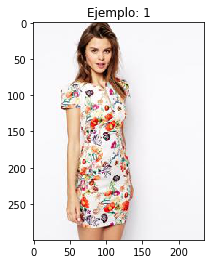

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve']


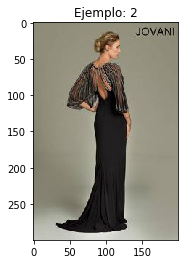

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'no_dress', 'short_sleeve', 'solid']


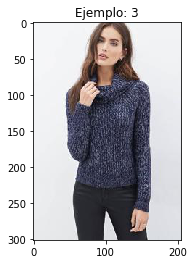

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


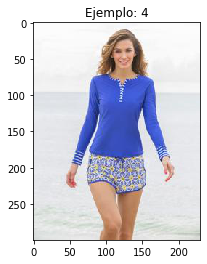

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'no_dress', 'no_neckline', 'sleeveless', 'solid']


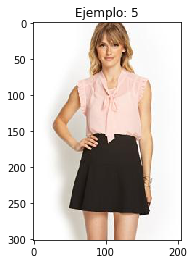

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'no_dress', 'solid', 'v_neckline']


In [33]:
# Ejemplos para la red DenseNet201
y_pred_vgg16 = vgg16_test_res[0]
display_examples(y_pred_vgg16)

In [34]:
# Calcula
## Número de veces que aparece un atributo en una predicción
## Número de veces en el que la predicción de un atributo se realiza de forma correcta
## Número de veces en el que la predicción de un atributo se realiza de forma incorrecta
def get_prediction_accuracy(y_true_df, y_pred, k=6):
    
    # Inicialización de los vectores
    times_predicted = [0] * NUM_CLASSES
    times_correctly_predicted = [0] * NUM_CLASSES
    times_incorrectly_predicted = [0] * NUM_CLASSES

    for index, row in y_true_df.iterrows():
        
        # Obtención de los verdaderos positivos
        true_possitives = np.where(row==1)

        # Obtención de los k valores con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            
            # Clasificación
            times_predicted[p]+=1
            if p in true_possitives[0]:
                times_correctly_predicted[p]+=1
            else:
                times_incorrectly_predicted[p]+=1
    return times_predicted, times_correctly_predicted, times_incorrectly_predicted

In [35]:
# Construcción de la tabla de resultados a partir de la lista de listas de valores predichos por un modelo sobre la partición de test
def build_results_table(y_pred):

    # Carga de las anotaciones reales de la partición de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)

    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columna de frecuencia real
    frequency = y_true_df.sum().tolist()

    # Columna de frecuencia de predicción, Verdaderos positivos y Falsos positivos
    times_predicted, times_correctly_predicted, times_incorrectly_predicted = get_prediction_accuracy(y_true_df, y_pred)

    # Columnas de sensibilidad y precisión
    recall = [a/b for a,b in zip(times_correctly_predicted, frequency)]
    precission = [a/max(1,b) for a,b in zip(times_correctly_predicted, times_predicted)]

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia real' : frequency, 
         'Frecuencia predicción' : times_predicted, 'TP': times_correctly_predicted, 'FP' : times_incorrectly_predicted, 
         'Sensibilidad' : recall, 'Precisión' : precission}
    return pd.DataFrame(data=d)


In [36]:
build_results_table(y_pred_vgg16)

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Sensibilidad,Precisión
0,floral,Estampado,664,659,408,251,0.61,0.62
1,graphic,Estampado,668,407,253,154,0.38,0.62
2,striped,Estampado,292,237,175,62,0.60,0.74
3,embroidered,Estampado,338,0,0,0,0.00,0.00
4,pleated,Estampado,78,0,0,0,0.00,0.00
5,solid,Estampado,1898,2345,1698,647,0.89,0.72
6,lattice,Estampado,62,0,0,0,0.00,0.00
7,long_sleeve,Tipo de manga,1243,1397,1060,337,0.85,0.76
8,short_sleeve,Tipo de manga,686,450,352,98,0.51,0.78
9,sleeveless,Tipo de manga,2071,2166,1831,335,0.88,0.85


A partir de la tabla anterior se puede observar que la mayor problemática a la hora de entrenar el modelo ha sido el _data imbalace_. Los atributos que aparecen con mayor frecuencia (tanto en las particiones de entrenamiento y validación, como en la de test) suelen predecirse con mayor frecuencia que los atributos minoritarios. Esto implica que atribotos como _leather_ o _faux_ no aparezcan en ninga predicción. Por otro lado llama la atención el bajo número de veces que el modelo predice atributos como _knit_ o _embroidered_. 

En una iteración posterior sobre estos modelos se podría contemplar aumentar el número de ejemplos de los atributos minoritarios en las particiones de entrenamiento y validación, o el empleo de alguna métrica como F1 a la hora de realizar el entrenamiento para solventar este problema. 

Por otro lado, en los casos en los que en una imagen aparecen varias prendas, se ha detectado que las anotaciones pertenecen a una de ellas mientras que el modelo parece predecir las de otra. Esto se puede apreciar en el ejemplo 4, en el que solo hay una diferencia en el conjunto de etiquetas. La etiqueta real es _floral_, que aplica al pantalón corto mientras que el modelo predice _solid_ que aplica a la prenda superior. 

# Clasificador por tipo de atributo

In [37]:
build_iterator_dataframe('test', 1)

./data/anno_fine/test_attr.txt


,floral,graphic,striped,embroidered,pleated,solid,lattice,filename
0,1,0,0,0,0,0,0,0.jpg
1,0,0,0,0,1,0,0,1.jpg
2,0,0,0,0,0,1,0,2.jpg
3,1,0,0,0,0,0,0,3.jpg
4,0,0,0,0,0,1,0,4.jpg
...,...,...,...,...,...,...,...,...
3995,1,0,0,0,0,0,0,3995.jpg
3996,1,0,0,0,0,0,0,3996.jpg
3997,0,0,0,0,0,1,0,3997.jpg
3998,0,0,1,0,0,0,0,3998.jpg


In [38]:
def try_pretrained_models_per_attribute_type():
    res = {}
    for attr_type in range(1,7):
        output_layer_size = len(attr_type_to_columns[str(attr_type)])
        
        res_attr_type = {}
        res[attr_type] = res_attr_type
        for architecture in ['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201']:
            print('$$$: Starting with attribute type {} and architecture {}'.format(attr_type, architecture))
            res_attr_type[architecture] = try_pretrained_model(architecture, attr_type, 
                                                               'softmax', categorical_crossentropy, output_layer_size)
    return res


In [ ]:
%cache results_per_attr_type = try_pretrained_models_per_attribute_type()

Creating new value for variable 'results_per_attr_type'
$$$: Starting with attribute type 1 and architecture InceptionV3
Evaluation #0
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 32s 641ms/step - loss: 11.0807 - auc: 0.6434 - accuracy: 0.3750 - val_loss: 9.7692 - val_auc: 0.6966 - val_accuracy: 0.4563
Epoch 2/100
50/50 [==============================] - 17s 330ms/step - loss: 4.4417 - auc: 0.7059 - accuracy: 0.3850 - val_loss: 14.2912 - val_auc: 0.7152 - val_accuracy: 0.5188
Epoch 3/100
50/50 [==============================] - 16s 318ms/step - loss: 3.6471 - auc: 0.7206 - accuracy: 0.4500 - val_loss: 3.1092 - val_auc: 0.7335 - val_accuracy: 0.4625
Epoch 4/100
50/50 [==============================] - 16s 319ms/step - loss: 2.4858 - auc: 0.7403 - accuracy: 0.3600 - val_loss: 1.6958 - val_auc: 0.7423 - val_accuracy: 0.42


Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00022: val_loss did not improve from 0.79730
Epoch 00022: early stopping
Evaluation #1
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 26s 512ms/step - loss: 14.1292 - auc: 0.6702 - accuracy: 0.4150 - val_loss: 2.7420 - val_auc: 0.7278 - val_accuracy: 0.4750
Epoch 2/100
50/50 [==============================] - 17s 342ms/step - loss: 4.6274 - auc: 0.7320 - accuracy: 0.4100 - val_loss: 2.7012 - val_auc: 0.7473 - val_accuracy: 0.5312
Epoch 3/100
50/50 [==============================] - 17s 332ms/step - loss: 1.9439 - auc: 0.7602 - accuracy: 0.4650 - val_loss: 3.3537 - val_auc: 0.7683 - val_accuracy: 0.4969
Epoch 4/100
50/50 [==============================] - 17s 331ms/step - loss: 1.7538 - auc: 0.7694 - accuracy: 0.4150 - val_loss: 1.363

50/50 [==============================] - 18s 352ms/step - loss: 1.1623 - auc: 0.8520 - accuracy: 0.6000 - val_loss: 1.0819 - val_auc: 0.8531 - val_accuracy: 0.6031

Epoch 00022: val_loss did not improve from 0.81170
Epoch 23/100
50/50 [==============================] - 17s 347ms/step - loss: 1.1307 - auc: 0.8540 - accuracy: 0.6050 - val_loss: 0.8271 - val_auc: 0.8551 - val_accuracy: 0.6375

Epoch 00023: val_loss did not improve from 0.81170
Epoch 24/100
50/50 [==============================] - 17s 347ms/step - loss: 1.1298 - auc: 0.8562 - accuracy: 0.5750 - val_loss: 1.1529 - val_auc: 0.8569 - val_accuracy: 0.5844

Epoch 00024: val_loss did not improve from 0.81170
Epoch 25/100
50/50 [==============================] - 18s 357ms/step - loss: 1.0305 - auc: 0.8577 - accuracy: 0.6400 - val_loss: 1.2744 - val_auc: 0.8584 - val_accuracy: 0.5594

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: val_loss did not improve from 0.81170
Epoch 26/100
50


Epoch 00007: val_loss improved from 1.63927 to 1.54475, saving model to ./model/InceptionV3_2_1.h5
Epoch 8/100
50/50 [==============================] - 10s 200ms/step - loss: 1.1934 - auc: 0.8165 - accuracy: 0.5500 - val_loss: 1.6344 - val_auc: 0.8204 - val_accuracy: 0.6219

Epoch 00008: val_loss did not improve from 1.54475
Epoch 9/100
50/50 [==============================] - 10s 199ms/step - loss: 1.2658 - auc: 0.8226 - accuracy: 0.5650 - val_loss: 1.0388 - val_auc: 0.8251 - val_accuracy: 0.6094

Epoch 00009: val_loss improved from 1.54475 to 1.03882, saving model to ./model/InceptionV3_2_1.h5
Epoch 10/100
50/50 [==============================] - 10s 200ms/step - loss: 1.2536 - auc: 0.8282 - accuracy: 0.5650 - val_loss: 0.8686 - val_auc: 0.8294 - val_accuracy: 0.5844

Epoch 00010: val_loss improved from 1.03882 to 0.86858, saving model to ./model/InceptionV3_2_1.h5
Epoch 11/100
50/50 [==============================] - 10s 199ms/step - loss: 1.3991 - auc: 0.8316 - accuracy: 0.5600 - 

50/50 [==============================] - 7s 136ms/step - loss: 1.3329 - auc: 0.8146 - accuracy: 0.5250 - val_loss: 1.2765 - val_auc: 0.8168 - val_accuracy: 0.5562
Epoch 11/100
50/50 [==============================] - 7s 130ms/step - loss: 1.1543 - auc: 0.8188 - accuracy: 0.6250 - val_loss: 2.0998 - val_auc: 0.8203 - val_accuracy: 0.4875
Epoch 12/100
50/50 [==============================] - 7s 133ms/step - loss: 1.1597 - auc: 0.8213 - accuracy: 0.6200 - val_loss: 1.8571 - val_auc: 0.8229 - val_accuracy: 0.4969

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00012: early stopping
Epoch 1/100
50/50 [==============================] - 20s 407ms/step - loss: 1.5767 - auc: 0.7904 - accuracy: 0.4400 - val_loss: 3.7882 - val_auc: 0.7399 - val_accuracy: 0.4062

Epoch 00001: val_loss improved from inf to 3.78818, saving model to ./model/InceptionV3_3_1.h5
Epoch 2/100
50/50 [==============================] - 11s 212ms/step - loss: 1.3111 - auc: 0.7470 - accu

50/50 [==============================] - 11s 212ms/step - loss: 1.0116 - auc: 0.8447 - accuracy: 0.6650 - val_loss: 1.3018 - val_auc: 0.8452 - val_accuracy: 0.5781

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00031: val_loss did not improve from 0.81989
Epoch 00031: early stopping
Evaluation #4
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 244ms/step - loss: 17.6418 - auc: 0.6083 - accuracy: 0.3650 - val_loss: 5.7929 - val_auc: 0.6845 - val_accuracy: 0.4719
Epoch 2/100
50/50 [==============================] - 8s 152ms/step - loss: 3.8477 - auc: 0.7069 - accuracy: 0.4450 - val_loss: 4.3262 - val_auc: 0.7280 - val_accuracy: 0.5250
Epoch 3/100
50/50 [==============================] - 8s 152ms/step - loss: 2.2621 - auc: 0.7409 - accuracy: 0.5600 - val_loss: 2.5571 - val_auc: 0

50/50 [==============================] - 13s 256ms/step - loss: 1.1793 - auc: 0.7966 - accuracy: 0.5750 - val_loss: 1.3255 - val_auc: 0.7984 - val_accuracy: 0.5844

Epoch 00022: val_loss did not improve from 0.92190
Epoch 23/100
50/50 [==============================] - 13s 256ms/step - loss: 1.2481 - auc: 0.7998 - accuracy: 0.5750 - val_loss: 1.0791 - val_auc: 0.8015 - val_accuracy: 0.6187

Epoch 00023: val_loss did not improve from 0.92190
Epoch 24/100
50/50 [==============================] - 13s 256ms/step - loss: 1.2076 - auc: 0.8031 - accuracy: 0.5750 - val_loss: 1.4030 - val_auc: 0.8045 - val_accuracy: 0.5781

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00024: val_loss did not improve from 0.92190
Epoch 25/100
50/50 [==============================] - 13s 255ms/step - loss: 1.1062 - auc: 0.8058 - accuracy: 0.5950 - val_loss: 1.3623 - val_auc: 0.8072 - val_accuracy: 0.5469

Epoch 00025: val_loss did not improve from 0.92190
Epoch 26/100
50

50/50 [==============================] - 10s 203ms/step - loss: 1.1417 - auc: 0.8092 - accuracy: 0.5800 - val_loss: 1.0506 - val_auc: 0.8114 - val_accuracy: 0.5906

Epoch 00016: val_loss did not improve from 1.04490
Epoch 17/100
50/50 [==============================] - 10s 203ms/step - loss: 1.1677 - auc: 0.8134 - accuracy: 0.5500 - val_loss: 1.3197 - val_auc: 0.8157 - val_accuracy: 0.5969

Epoch 00017: val_loss did not improve from 1.04490
Epoch 18/100
50/50 [==============================] - 10s 203ms/step - loss: 1.1721 - auc: 0.8177 - accuracy: 0.5650 - val_loss: 1.1313 - val_auc: 0.8192 - val_accuracy: 0.5469

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00018: val_loss did not improve from 1.04490
Epoch 19/100
50/50 [==============================] - 10s 201ms/step - loss: 1.0854 - auc: 0.8209 - accuracy: 0.5650 - val_loss: 0.8501 - val_auc: 0.8227 - val_accuracy: 0.5888

Epoch 00019: val_loss improved from 1.04490 to 0.85009, saving mod

50/50 [==============================] - 7s 135ms/step - loss: 1.2207 - auc: 0.8403 - accuracy: 0.5700 - val_loss: 1.2536 - val_auc: 0.8410 - val_accuracy: 0.5344
Epoch 19/100
50/50 [==============================] - 7s 131ms/step - loss: 1.2282 - auc: 0.8416 - accuracy: 0.5650 - val_loss: 1.2463 - val_auc: 0.8421 - val_accuracy: 0.5855
Epoch 20/100
50/50 [==============================] - 7s 134ms/step - loss: 1.1725 - auc: 0.8429 - accuracy: 0.6200 - val_loss: 1.2222 - val_auc: 0.8438 - val_accuracy: 0.5938

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 21/100
50/50 [==============================] - 7s 130ms/step - loss: 1.2725 - auc: 0.8445 - accuracy: 0.5250 - val_loss: 1.5239 - val_auc: 0.8450 - val_accuracy: 0.5594
Epoch 22/100
50/50 [==============================] - 7s 134ms/step - loss: 1.3212 - auc: 0.8453 - accuracy: 0.5300 - val_loss: 1.6184 - val_auc: 0.8459 - val_accuracy: 0.5437
Epoch 23/100
50/50 [==============================]

Epoch 11/100
50/50 [==============================] - 7s 148ms/step - loss: 1.2808 - auc: 0.7924 - accuracy: 0.5700 - val_loss: 1.8287 - val_auc: 0.7935 - val_accuracy: 0.5188
Epoch 12/100
50/50 [==============================] - 7s 148ms/step - loss: 1.3038 - auc: 0.7948 - accuracy: 0.5800 - val_loss: 1.8169 - val_auc: 0.7968 - val_accuracy: 0.5750

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00012: early stopping
Epoch 1/100
50/50 [==============================] - 22s 436ms/step - loss: 1.6193 - auc: 0.7802 - accuracy: 0.4900 - val_loss: 72.0472 - val_auc: 0.7563 - val_accuracy: 0.4812

Epoch 00001: val_loss improved from inf to 72.04724, saving model to ./model/InceptionV3_7_1.h5
Epoch 2/100
50/50 [==============================] - 13s 251ms/step - loss: 1.4804 - auc: 0.7414 - accuracy: 0.5500 - val_loss: 9.0351 - val_auc: 0.7393 - val_accuracy: 0.4281

Epoch 00002: val_loss improved from 72.04724 to 9.03510, saving model to ./model/Incept

50/50 [==============================] - 12s 249ms/step - loss: 0.9506 - auc: 0.8567 - accuracy: 0.6400 - val_loss: 0.9993 - val_auc: 0.8578 - val_accuracy: 0.6480

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00032: val_loss did not improve from 0.62239
Epoch 33/100
50/50 [==============================] - 13s 251ms/step - loss: 1.0836 - auc: 0.8585 - accuracy: 0.6000 - val_loss: 0.8047 - val_auc: 0.8593 - val_accuracy: 0.6125

Epoch 00033: val_loss did not improve from 0.62239
Epoch 34/100
50/50 [==============================] - 13s 252ms/step - loss: 1.0335 - auc: 0.8600 - accuracy: 0.6600 - val_loss: 1.3791 - val_auc: 0.8607 - val_accuracy: 0.5719

Epoch 00034: val_loss did not improve from 0.62239
Epoch 35/100
50/50 [==============================] - 13s 251ms/step - loss: 1.0376 - auc: 0.8612 - accuracy: 0.6450 - val_loss: 1.0820 - val_auc: 0.8619 - val_accuracy: 0.6000

Epoch 00035: val_loss did not improve from 0.62239
Epoch 36/100
50

50/50 [==============================] - 7s 131ms/step - loss: 1.8417 - auc: 0.7379 - accuracy: 0.3950 - val_loss: 1.8344 - val_auc: 0.7539 - val_accuracy: 0.5063
Epoch 3/100
50/50 [==============================] - 7s 131ms/step - loss: 1.6781 - auc: 0.7612 - accuracy: 0.3800 - val_loss: 1.4083 - val_auc: 0.7584 - val_accuracy: 0.5063
Epoch 4/100
50/50 [==============================] - 6s 130ms/step - loss: 1.5578 - auc: 0.7600 - accuracy: 0.4350 - val_loss: 1.3008 - val_auc: 0.7627 - val_accuracy: 0.4844
Epoch 5/100
50/50 [==============================] - 6s 130ms/step - loss: 1.4111 - auc: 0.7673 - accuracy: 0.5300 - val_loss: 1.0897 - val_auc: 0.7732 - val_accuracy: 0.4969
Epoch 6/100
50/50 [==============================] - 7s 130ms/step - loss: 1.5754 - auc: 0.7760 - accuracy: 0.5250 - val_loss: 1.5452 - val_auc: 0.7780 - val_accuracy: 0.4500
Epoch 7/100
50/50 [==============================] - 6s 128ms/step - loss: 1.5399 - auc: 0.7800 - accuracy: 0.4750 - val_loss: 1.3797 - v

50/50 [==============================] - 10s 191ms/step - loss: 1.2031 - auc: 0.8426 - accuracy: 0.6000 - val_loss: 1.0955 - val_auc: 0.8438 - val_accuracy: 0.6414

Epoch 00019: val_loss did not improve from 0.72673
Epoch 20/100
50/50 [==============================] - 10s 194ms/step - loss: 1.1056 - auc: 0.8450 - accuracy: 0.6200 - val_loss: 1.1816 - val_auc: 0.8464 - val_accuracy: 0.6250

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: val_loss did not improve from 0.72673
Epoch 00020: early stopping
Evaluation #10
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 242ms/step - loss: 19.5846 - auc: 0.6489 - accuracy: 0.3700 - val_loss: 17.9331 - val_auc: 0.7040 - val_accuracy: 0.4781
Epoch 2/100
50/50 [==============================] - 7s 144ms/step - loss: 5.2449 - auc: 0


Epoch 00017: val_loss did not improve from 0.88144
Epoch 18/100
50/50 [==============================] - 12s 248ms/step - loss: 1.2297 - auc: 0.7689 - accuracy: 0.5800 - val_loss: 1.6173 - val_auc: 0.7704 - val_accuracy: 0.4594

Epoch 00018: val_loss did not improve from 0.88144
Epoch 19/100
50/50 [==============================] - 12s 245ms/step - loss: 1.3114 - auc: 0.7717 - accuracy: 0.5200 - val_loss: 1.6121 - val_auc: 0.7737 - val_accuracy: 0.5362

Epoch 00019: val_loss did not improve from 0.88144
Epoch 20/100
50/50 [==============================] - 12s 248ms/step - loss: 1.4575 - auc: 0.7744 - accuracy: 0.4450 - val_loss: 2.0624 - val_auc: 0.7757 - val_accuracy: 0.4969

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: val_loss did not improve from 0.88144
Epoch 00020: early stopping
Evaluation #11
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 v

50/50 [==============================] - 11s 212ms/step - loss: 1.2575 - auc: 0.7566 - accuracy: 0.5850 - val_loss: 1.0944 - val_auc: 0.7615 - val_accuracy: 0.5625

Epoch 00011: val_loss improved from 1.31352 to 1.09443, saving model to ./model/InceptionV3_11_1.h5
Epoch 12/100
50/50 [==============================] - 11s 212ms/step - loss: 1.3818 - auc: 0.7646 - accuracy: 0.4850 - val_loss: 2.2373 - val_auc: 0.7652 - val_accuracy: 0.4375

Epoch 00012: val_loss did not improve from 1.09443
Epoch 13/100
50/50 [==============================] - 10s 209ms/step - loss: 1.3554 - auc: 0.7668 - accuracy: 0.5750 - val_loss: 2.8345 - val_auc: 0.7681 - val_accuracy: 0.5789

Epoch 00013: val_loss did not improve from 1.09443
Epoch 14/100
50/50 [==============================] - 11s 211ms/step - loss: 1.2762 - auc: 0.7699 - accuracy: 0.5750 - val_loss: 1.0548 - val_auc: 0.7722 - val_accuracy: 0.5688

Epoch 00014: val_loss improved from 1.09443 to 1.05476, saving model to ./model/InceptionV3_11_1.h5

50/50 [==============================] - 7s 131ms/step - loss: 1.3120 - auc: 0.7572 - accuracy: 0.5650 - val_loss: 1.8130 - val_auc: 0.7586 - val_accuracy: 0.4844
Epoch 19/100
50/50 [==============================] - 7s 131ms/step - loss: 1.3041 - auc: 0.7596 - accuracy: 0.6150 - val_loss: 1.9031 - val_auc: 0.7611 - val_accuracy: 0.4934
Epoch 20/100
50/50 [==============================] - 7s 133ms/step - loss: 1.4714 - auc: 0.7619 - accuracy: 0.5300 - val_loss: 1.1864 - val_auc: 0.7633 - val_accuracy: 0.5719

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 21/100
50/50 [==============================] - 6s 129ms/step - loss: 1.3873 - auc: 0.7647 - accuracy: 0.5200 - val_loss: 1.6584 - val_auc: 0.7657 - val_accuracy: 0.5000
Epoch 22/100
50/50 [==============================] - 7s 133ms/step - loss: 1.3188 - auc: 0.7668 - accuracy: 0.5900 - val_loss: 1.7051 - val_auc: 0.7685 - val_accuracy: 0.5125
Epoch 23/100
50/50 [==============================]

50/50 [==============================] - 10s 193ms/step - loss: 1.1612 - auc: 0.8148 - accuracy: 0.6100 - val_loss: 1.4983 - val_auc: 0.8161 - val_accuracy: 0.5719

Epoch 00028: val_loss did not improve from 0.69780
Epoch 29/100
50/50 [==============================] - 10s 194ms/step - loss: 1.2423 - auc: 0.8170 - accuracy: 0.5300 - val_loss: 1.3544 - val_auc: 0.8181 - val_accuracy: 0.5969

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00029: val_loss did not improve from 0.69780
Epoch 00029: early stopping
Evaluation #13
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 236ms/step - loss: 10.4792 - auc: 0.6892 - accuracy: 0.3900 - val_loss: 10.6838 - val_auc: 0.6594 - val_accuracy: 0.2594
Epoch 2/100
50/50 [==============================] - 7s 136ms/step - loss: 3.8613 - auc: 0


Epoch 00012: val_loss did not improve from 1.73858
Epoch 13/100
50/50 [==============================] - 12s 236ms/step - loss: 1.4954 - auc: 0.7002 - accuracy: 0.4600 - val_loss: 1.6807 - val_auc: 0.7040 - val_accuracy: 0.5230

Epoch 00013: val_loss improved from 1.73858 to 1.68067, saving model to ./model/InceptionV3_13_1.h5
Epoch 14/100
50/50 [==============================] - 12s 239ms/step - loss: 1.4795 - auc: 0.7075 - accuracy: 0.4850 - val_loss: 1.6964 - val_auc: 0.7104 - val_accuracy: 0.4313

Epoch 00014: val_loss did not improve from 1.68067
Epoch 15/100
50/50 [==============================] - 12s 239ms/step - loss: 1.5078 - auc: 0.7135 - accuracy: 0.5000 - val_loss: 1.5929 - val_auc: 0.7161 - val_accuracy: 0.4437

Epoch 00015: val_loss improved from 1.68067 to 1.59292, saving model to ./model/InceptionV3_13_1.h5
Epoch 16/100
50/50 [==============================] - 12s 239ms/step - loss: 1.4905 - auc: 0.7184 - accuracy: 0.4400 - val_loss: 1.8224 - val_auc: 0.7211 - val_acc

Epoch 13/100
50/50 [==============================] - 8s 150ms/step - loss: 1.1504 - auc: 0.7955 - accuracy: 0.5850 - val_loss: 1.5034 - val_auc: 0.7978 - val_accuracy: 0.5526

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00013: early stopping
Epoch 1/100
50/50 [==============================] - 16s 324ms/step - loss: 1.5837 - auc: 0.8305 - accuracy: 0.5050 - val_loss: 4.5212 - val_auc: 0.7895 - val_accuracy: 0.4656

Epoch 00001: val_loss improved from inf to 4.52116, saving model to ./model/InceptionV3_14_1.h5
Epoch 2/100
50/50 [==============================] - 10s 200ms/step - loss: 1.5643 - auc: 0.7773 - accuracy: 0.4450 - val_loss: 2.5226 - val_auc: 0.7839 - val_accuracy: 0.5562

Epoch 00002: val_loss improved from 4.52116 to 2.52257, saving model to ./model/InceptionV3_14_1.h5
Epoch 3/100
50/50 [==============================] - 10s 200ms/step - loss: 1.5047 - auc: 0.7900 - accuracy: 0.5100 - val_loss: 2.0008 - val_auc: 0.7919 - val_accur

Epoch 8/100
50/50 [==============================] - 7s 131ms/step - loss: 1.2269 - auc: 0.8063 - accuracy: 0.5650 - val_loss: 2.3248 - val_auc: 0.8040 - val_accuracy: 0.4563
Epoch 9/100
50/50 [==============================] - 6s 128ms/step - loss: 1.4472 - auc: 0.8025 - accuracy: 0.5100 - val_loss: 1.3938 - val_auc: 0.8050 - val_accuracy: 0.5500

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 10/100
50/50 [==============================] - 7s 134ms/step - loss: 1.3698 - auc: 0.8068 - accuracy: 0.5450 - val_loss: 1.2290 - val_auc: 0.8079 - val_accuracy: 0.4969
Epoch 11/100
50/50 [==============================] - 6s 128ms/step - loss: 1.2916 - auc: 0.8097 - accuracy: 0.5300 - val_loss: 1.2991 - val_auc: 0.8119 - val_accuracy: 0.5719
Epoch 12/100
50/50 [==============================] - 6s 129ms/step - loss: 1.2411 - auc: 0.8138 - accuracy: 0.5400 - val_loss: 0.9524 - val_auc: 0.8156 - val_accuracy: 0.5750
Epoch 13/100
50/50 [====================

50/50 [==============================] - 10s 194ms/step - loss: 0.9459 - auc: 0.8283 - accuracy: 0.6650 - val_loss: 1.7517 - val_auc: 0.8303 - val_accuracy: 0.6750

Epoch 00023: val_loss did not improve from 0.92382
Epoch 24/100
50/50 [==============================] - 10s 194ms/step - loss: 1.0023 - auc: 0.8320 - accuracy: 0.6850 - val_loss: 1.0579 - val_auc: 0.8334 - val_accuracy: 0.6656

Epoch 00024: val_loss did not improve from 0.92382
Epoch 25/100
50/50 [==============================] - 10s 194ms/step - loss: 1.0163 - auc: 0.8347 - accuracy: 0.6400 - val_loss: 0.8015 - val_auc: 0.8360 - val_accuracy: 0.6656

Epoch 00025: val_loss improved from 0.92382 to 0.80147, saving model to ./model/InceptionV3_15_1.h5
Epoch 26/100
50/50 [==============================] - 10s 192ms/step - loss: 1.0814 - auc: 0.8372 - accuracy: 0.6250 - val_loss: 2.2392 - val_auc: 0.8385 - val_accuracy: 0.6546

Epoch 00026: val_loss did not improve from 0.80147
Epoch 27/100
50/50 [============================


Epoch 00006: val_loss improved from 1.84208 to 1.83927, saving model to ./model/InceptionV3_16_1.h5
Epoch 7/100
50/50 [==============================] - 8s 153ms/step - loss: 1.1157 - auc: 0.8248 - accuracy: 0.6300 - val_loss: 1.5116 - val_auc: 0.8282 - val_accuracy: 0.6053

Epoch 00007: val_loss improved from 1.83927 to 1.51165, saving model to ./model/InceptionV3_16_1.h5
Epoch 8/100
50/50 [==============================] - 8s 155ms/step - loss: 1.1257 - auc: 0.8315 - accuracy: 0.6300 - val_loss: 1.0327 - val_auc: 0.8349 - val_accuracy: 0.6562

Epoch 00008: val_loss improved from 1.51165 to 1.03272, saving model to ./model/InceptionV3_16_1.h5
Epoch 9/100
50/50 [==============================] - 8s 155ms/step - loss: 1.2045 - auc: 0.8376 - accuracy: 0.5900 - val_loss: 1.2032 - val_auc: 0.8401 - val_accuracy: 0.6719

Epoch 00009: val_loss did not improve from 1.03272
Epoch 10/100
50/50 [==============================] - 8s 155ms/step - loss: 1.1649 - auc: 0.8429 - accuracy: 0.6250 - va

50/50 [==============================] - 9s 183ms/step - loss: 1.6035 - auc: 0.7672 - accuracy: 0.4900 - val_loss: 3.1682 - val_auc: 0.7709 - val_accuracy: 0.4750

Epoch 00004: val_loss did not improve from 2.42467
Epoch 5/100
50/50 [==============================] - 9s 183ms/step - loss: 1.5376 - auc: 0.7723 - accuracy: 0.4150 - val_loss: 4.1084 - val_auc: 0.7733 - val_accuracy: 0.4969

Epoch 00005: val_loss did not improve from 2.42467
Epoch 6/100
50/50 [==============================] - 9s 183ms/step - loss: 1.5277 - auc: 0.7748 - accuracy: 0.5100 - val_loss: 1.6552 - val_auc: 0.7774 - val_accuracy: 0.4594

Epoch 00006: val_loss improved from 2.42467 to 1.65518, saving model to ./model/InceptionV3_17_1.h5
Epoch 7/100
50/50 [==============================] - 9s 180ms/step - loss: 1.4943 - auc: 0.7799 - accuracy: 0.4550 - val_loss: 1.4931 - val_auc: 0.7830 - val_accuracy: 0.4539

Epoch 00007: val_loss improved from 1.65518 to 1.49311, saving model to ./model/InceptionV3_17_1.h5
Epoch 

50/50 [==============================] - 10s 193ms/step - loss: 1.3517 - auc: 0.7930 - accuracy: 0.5200 - val_loss: 1.7864 - val_auc: 0.7970 - val_accuracy: 0.6125

Epoch 00005: val_loss did not improve from 0.93007
Epoch 6/100
50/50 [==============================] - 10s 193ms/step - loss: 1.2076 - auc: 0.8007 - accuracy: 0.5900 - val_loss: 1.0978 - val_auc: 0.8080 - val_accuracy: 0.6594

Epoch 00006: val_loss did not improve from 0.93007
Epoch 7/100
50/50 [==============================] - 10s 190ms/step - loss: 1.2872 - auc: 0.8127 - accuracy: 0.5600 - val_loss: 2.0893 - val_auc: 0.8136 - val_accuracy: 0.5789

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00007: val_loss did not improve from 0.93007
Epoch 8/100
50/50 [==============================] - 10s 194ms/step - loss: 1.1464 - auc: 0.8151 - accuracy: 0.6400 - val_loss: 1.4736 - val_auc: 0.8181 - val_accuracy: 0.6000

Epoch 00008: val_loss did not improve from 0.93007
Epoch 9/100
50/50 

50/50 [==============================] - 10s 198ms/step - loss: 1.2548 - auc: 0.7742 - accuracy: 0.5450 - val_loss: 1.8070 - val_auc: 0.7779 - val_accuracy: 0.5428

Epoch 00013: val_loss did not improve from 0.94849
Epoch 14/100
50/50 [==============================] - 10s 200ms/step - loss: 1.0879 - auc: 0.7811 - accuracy: 0.6200 - val_loss: 1.4023 - val_auc: 0.7844 - val_accuracy: 0.5625

Epoch 00014: val_loss did not improve from 0.94849
Epoch 15/100
50/50 [==============================] - 10s 201ms/step - loss: 1.0552 - auc: 0.7874 - accuracy: 0.5850 - val_loss: 1.0289 - val_auc: 0.7907 - val_accuracy: 0.5750

Epoch 00015: val_loss did not improve from 0.94849
Epoch 16/100
50/50 [==============================] - 10s 201ms/step - loss: 1.1382 - auc: 0.7935 - accuracy: 0.6000 - val_loss: 1.5603 - val_auc: 0.7963 - val_accuracy: 0.5906

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00016: val_loss did not improve from 0.94849
Epoch 17/100
50

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 15s 298ms/step - loss: 17.9399 - auc: 0.6367 - accuracy: 0.4250 - val_loss: 4.2900 - val_auc: 0.6876 - val_accuracy: 0.0344
Epoch 2/100
50/50 [==============================] - 12s 232ms/step - loss: 5.2154 - auc: 0.6952 - accuracy: 0.5100 - val_loss: 1.7293 - val_auc: 0.6993 - val_accuracy: 0.2875
Epoch 3/100
50/50 [==============================] - 12s 232ms/step - loss: 2.2686 - auc: 0.7017 - accuracy: 0.3900 - val_loss: 1.5232 - val_auc: 0.7125 - val_accuracy: 0.4906
Epoch 4/100
50/50 [==============================] - 12s 232ms/step - loss: 1.7741 - auc: 0.7197 - accuracy: 0.5000 - val_loss: 1.6687 - val_auc: 0.7210 - val_accuracy: 0.4781
Epoch 5/100
50/50 [==============================] - 12s 232ms/step - loss: 1.3908 - auc: 0.7243 - accuracy: 0.5800 - val_loss: 1.286

50/50 [==============================] - 9s 185ms/step - loss: 4.2769 - auc: 0.6815 - accuracy: 0.4400 - val_loss: 1.4383 - val_auc: 0.6863 - val_accuracy: 0.4750
Epoch 5/100
50/50 [==============================] - 9s 180ms/step - loss: 2.6716 - auc: 0.6923 - accuracy: 0.4000 - val_loss: 1.4882 - val_auc: 0.6907 - val_accuracy: 0.4844
Epoch 6/100
50/50 [==============================] - 9s 175ms/step - loss: 1.6185 - auc: 0.6922 - accuracy: 0.4550 - val_loss: 1.6031 - val_auc: 0.6947 - val_accuracy: 0.4375
Epoch 7/100
50/50 [==============================] - 9s 172ms/step - loss: 1.5795 - auc: 0.6968 - accuracy: 0.4750 - val_loss: 1.7115 - val_auc: 0.7002 - val_accuracy: 0.4737
Epoch 8/100
50/50 [==============================] - 9s 182ms/step - loss: 1.5014 - auc: 0.7037 - accuracy: 0.5050 - val_loss: 1.6279 - val_auc: 0.7078 - val_accuracy: 0.5156

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 9s

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 15s 306ms/step - loss: 22.6999 - auc: 0.6247 - accuracy: 0.4250 - val_loss: 3.1195 - val_auc: 0.7009 - val_accuracy: 0.4688
Epoch 2/100
50/50 [==============================] - 12s 241ms/step - loss: 3.9486 - auc: 0.7139 - accuracy: 0.4350 - val_loss: 2.1615 - val_auc: 0.7144 - val_accuracy: 0.5031
Epoch 3/100
50/50 [==============================] - 12s 241ms/step - loss: 1.8943 - auc: 0.7174 - accuracy: 0.4050 - val_loss: 2.2248 - val_auc: 0.7176 - val_accuracy: 0.1406
Epoch 4/100
50/50 [==============================] - 12s 241ms/step - loss: 1.7089 - auc: 0.7147 - accuracy: 0.4300 - val_loss: 1.4701 - val_auc: 0.7150 - val_accuracy: 0.4750
Epoch 5/100
50/50 [==============================] - 12s 242ms/step - loss: 1.4982 - auc: 0.7197 - accuracy: 0.5100 - val_loss: 1.683

50/50 [==============================] - 9s 181ms/step - loss: 1.1615 - auc: 0.7964 - accuracy: 0.5950 - val_loss: 1.5389 - val_auc: 0.7978 - val_accuracy: 0.4594
Epoch 11/100
50/50 [==============================] - 9s 179ms/step - loss: 1.0091 - auc: 0.8000 - accuracy: 0.6600 - val_loss: 1.8218 - val_auc: 0.8013 - val_accuracy: 0.4656
Epoch 12/100
50/50 [==============================] - 9s 179ms/step - loss: 1.2772 - auc: 0.8006 - accuracy: 0.5750 - val_loss: 1.6063 - val_auc: 0.8003 - val_accuracy: 0.4719
Epoch 13/100
50/50 [==============================] - 9s 175ms/step - loss: 1.0973 - auc: 0.8012 - accuracy: 0.6450 - val_loss: 1.5693 - val_auc: 0.8017 - val_accuracy: 0.4605
Epoch 14/100
50/50 [==============================] - 9s 180ms/step - loss: 1.1448 - auc: 0.8028 - accuracy: 0.5950 - val_loss: 1.5744 - val_auc: 0.8036 - val_accuracy: 0.5156

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 15/100
50/50 [==============================]

50/50 [==============================] - 9s 178ms/step - loss: 1.2932 - auc: 0.8155 - accuracy: 0.5350 - val_loss: 1.3452 - val_auc: 0.8129 - val_accuracy: 0.4750
Epoch 5/100
50/50 [==============================] - 9s 181ms/step - loss: 1.2882 - auc: 0.8125 - accuracy: 0.5400 - val_loss: 1.3911 - val_auc: 0.8128 - val_accuracy: 0.4844
Epoch 6/100
50/50 [==============================] - 9s 179ms/step - loss: 1.2148 - auc: 0.8140 - accuracy: 0.5900 - val_loss: 1.5741 - val_auc: 0.8139 - val_accuracy: 0.4375
Epoch 7/100
50/50 [==============================] - 9s 174ms/step - loss: 1.2962 - auc: 0.8148 - accuracy: 0.5800 - val_loss: 1.5338 - val_auc: 0.8138 - val_accuracy: 0.4704
Epoch 8/100
50/50 [==============================] - 9s 176ms/step - loss: 1.2746 - auc: 0.8139 - accuracy: 0.5500 - val_loss: 1.4479 - val_auc: 0.8135 - val_accuracy: 0.4969

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 9s

Epoch 19/100
50/50 [==============================] - 9s 175ms/step - loss: 1.3380 - auc: 0.7318 - accuracy: 0.6100 - val_loss: 1.7487 - val_auc: 0.7322 - val_accuracy: 0.0888
Epoch 20/100
50/50 [==============================] - 9s 178ms/step - loss: 1.4758 - auc: 0.7325 - accuracy: 0.4850 - val_loss: 1.7256 - val_auc: 0.7328 - val_accuracy: 0.1219
Epoch 21/100
50/50 [==============================] - 9s 185ms/step - loss: 1.3325 - auc: 0.7336 - accuracy: 0.5050 - val_loss: 1.9314 - val_auc: 0.7337 - val_accuracy: 0.0594
Epoch 22/100
50/50 [==============================] - 9s 181ms/step - loss: 1.2156 - auc: 0.7345 - accuracy: 0.6200 - val_loss: 1.9026 - val_auc: 0.7349 - val_accuracy: 0.0656
Epoch 23/100
50/50 [==============================] - 9s 180ms/step - loss: 1.2244 - auc: 0.7356 - accuracy: 0.5800 - val_loss: 1.9080 - val_auc: 0.7365 - val_accuracy: 0.0875
Epoch 24/100
50/50 [==============================] - 9s 181ms/step - loss: 1.2696 - auc: 0.7372 - accuracy: 0.5500 - va

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 15s 306ms/step - loss: 23.6985 - auc: 0.6373 - accuracy: 0.4100 - val_loss: 6.7091 - val_auc: 0.6718 - val_accuracy: 0.4688
Epoch 2/100
50/50 [==============================] - 12s 240ms/step - loss: 10.0493 - auc: 0.6767 - accuracy: 0.4650 - val_loss: 6.8000 - val_auc: 0.6865 - val_accuracy: 0.5031
Epoch 3/100
50/50 [==============================] - 12s 240ms/step - loss: 4.7363 - auc: 0.6955 - accuracy: 0.4550 - val_loss: 2.2762 - val_auc: 0.7085 - val_accuracy: 0.4906
Epoch 4/100
50/50 [==============================] - 12s 240ms/step - loss: 2.2193 - auc: 0.7195 - accuracy: 0.5850 - val_loss: 1.4050 - val_auc: 0.7244 - val_accuracy: 0.4750
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 1.3798 - auc: 0.7282 - accuracy: 0.5450 - val_loss: 1.43

50/50 [==============================] - 22s 436ms/step - loss: 1.9507 - auc: 0.7386 - accuracy: 0.3850 - val_loss: 1.9214 - val_auc: 0.7255 - val_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.92141, saving model to ./model/ResNet50_8_1.h5
Epoch 2/100
50/50 [==============================] - 15s 299ms/step - loss: 2.0620 - auc: 0.7285 - accuracy: 0.3400 - val_loss: 1.8936 - val_auc: 0.7328 - val_accuracy: 0.5063

Epoch 00002: val_loss improved from 1.92141 to 1.89356, saving model to ./model/ResNet50_8_1.h5
Epoch 3/100
50/50 [==============================] - 15s 299ms/step - loss: 1.9409 - auc: 0.7352 - accuracy: 0.4450 - val_loss: 1.6879 - val_auc: 0.7255 - val_accuracy: 0.4656

Epoch 00003: val_loss improved from 1.89356 to 1.68793, saving model to ./model/ResNet50_8_1.h5
Epoch 4/100
50/50 [==============================] - 15s 299ms/step - loss: 1.9027 - auc: 0.7224 - accuracy: 0.4200 - val_loss: 1.7495 - val_auc: 0.7168 - val_accuracy: 0.4250

Epoch 00004: val_los


Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00009: val_loss did not improve from 1.56598
Epoch 10/100
50/50 [==============================] - 13s 262ms/step - loss: 0.9476 - auc: 0.7388 - accuracy: 0.6750 - val_loss: 2.0118 - val_auc: 0.7420 - val_accuracy: 0.4812

Epoch 00010: val_loss did not improve from 1.56598
Epoch 11/100
50/50 [==============================] - 13s 262ms/step - loss: 1.1416 - auc: 0.7446 - accuracy: 0.6400 - val_loss: 2.1954 - val_auc: 0.7472 - val_accuracy: 0.4969

Epoch 00011: val_loss did not improve from 1.56598
Epoch 12/100
50/50 [==============================] - 13s 261ms/step - loss: 1.0642 - auc: 0.7493 - accuracy: 0.6550 - val_loss: 2.0171 - val_auc: 0.7509 - val_accuracy: 0.4406

Epoch 00012: val_loss did not improve from 1.56598
Epoch 13/100
50/50 [==============================] - 13s 257ms/step - loss: 1.0759 - auc: 0.7524 - accuracy: 0.6650 - val_loss: 2.3511 - val_auc: 0.7540 - val_accuracy: 0.4638

E

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 16s 314ms/step - loss: 25.3475 - auc: 0.6607 - accuracy: 0.4250 - val_loss: 12.5768 - val_auc: 0.6829 - val_accuracy: 0.4688
Epoch 2/100
50/50 [==============================] - 12s 249ms/step - loss: 15.0368 - auc: 0.6935 - accuracy: 0.5250 - val_loss: 4.3964 - val_auc: 0.6873 - val_accuracy: 0.0781
Epoch 3/100
50/50 [==============================] - 12s 249ms/step - loss: 4.0010 - auc: 0.6887 - accuracy: 0.4900 - val_loss: 3.2514 - val_auc: 0.6776 - val_accuracy: 0.1719
Epoch 4/100
50/50 [==============================] - 12s 249ms/step - loss: 2.0343 - auc: 0.6640 - accuracy: 0.3750 - val_loss: 2.1817 - val_auc: 0.6559 - val_accuracy: 0.1719
Epoch 5/100
50/50 [==============================] - 12s 249ms/step - loss: 1.6227 - auc: 0.6549 - accuracy: 0.4450 - val_loss: 2.0

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 14s 274ms/step - loss: 12.4658 - auc: 0.6559 - accuracy: 0.3750 - val_loss: 3.6321 - val_auc: 0.7170 - val_accuracy: 0.4688
Epoch 2/100
50/50 [==============================] - 10s 209ms/step - loss: 5.0672 - auc: 0.7350 - accuracy: 0.4350 - val_loss: 4.4732 - val_auc: 0.7216 - val_accuracy: 0.5031
Epoch 3/100
50/50 [==============================] - 10s 209ms/step - loss: 3.1835 - auc: 0.7189 - accuracy: 0.5000 - val_loss: 2.9037 - val_auc: 0.7230 - val_accuracy: 0.4906
Epoch 4/100
50/50 [==============================] - 10s 209ms/step - loss: 1.9145 - auc: 0.7256 - accuracy: 0.4700 - val_loss: 1.5615 - val_auc: 0.7232 - val_accuracy: 0.4750
Epoch 5/100
50/50 [==============================] - 10s 209ms/step - loss: 1.4911 - auc: 0.7237 - accuracy: 0.5550 - val_loss: 1.200

50/50 [==============================] - 9s 180ms/step - loss: 1.5521 - auc: 0.7162 - accuracy: 0.5400 - val_loss: 1.5033 - val_auc: 0.7210 - val_accuracy: 0.4906
Epoch 6/100
50/50 [==============================] - 9s 174ms/step - loss: 1.7317 - auc: 0.7242 - accuracy: 0.4700 - val_loss: 1.5964 - val_auc: 0.7252 - val_accuracy: 0.4375
Epoch 7/100
50/50 [==============================] - 9s 175ms/step - loss: 1.4856 - auc: 0.7281 - accuracy: 0.5000 - val_loss: 1.8448 - val_auc: 0.7305 - val_accuracy: 0.4572
Epoch 8/100
50/50 [==============================] - 9s 179ms/step - loss: 1.5508 - auc: 0.7312 - accuracy: 0.4450 - val_loss: 1.6815 - val_auc: 0.7337 - val_accuracy: 0.5156

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 9s 183ms/step - loss: 1.2319 - auc: 0.7371 - accuracy: 0.6350 - val_loss: 1.4945 - val_auc: 0.7396 - val_accuracy: 0.4750
Epoch 10/100
50/50 [==============================] - 9

Epoch 2/100
50/50 [==============================] - 13s 261ms/step - loss: 1.8471 - auc: 0.6700 - accuracy: 0.2400 - val_loss: 1.8688 - val_auc: 0.6969 - val_accuracy: 0.1625

Epoch 00002: val_loss improved from 1.92579 to 1.86875, saving model to ./model/ResNet50_13_1.h5
Epoch 3/100
50/50 [==============================] - 13s 261ms/step - loss: 1.9929 - auc: 0.7090 - accuracy: 0.2000 - val_loss: 5.6787 - val_auc: 0.6811 - val_accuracy: 0.0312

Epoch 00003: val_loss did not improve from 1.86875
Epoch 4/100
50/50 [==============================] - 13s 261ms/step - loss: 2.0533 - auc: 0.6687 - accuracy: 0.3600 - val_loss: 1.8416 - val_auc: 0.6760 - val_accuracy: 0.4406

Epoch 00004: val_loss improved from 1.86875 to 1.84157, saving model to ./model/ResNet50_13_1.h5
Epoch 5/100
50/50 [==============================] - 13s 261ms/step - loss: 1.8515 - auc: 0.6864 - accuracy: 0.4750 - val_loss: 1.6756 - val_auc: 0.6903 - val_accuracy: 0.4563

Epoch 00005: val_loss improved from 1.84157 to 


Epoch 00002: val_loss did not improve from 1.96384
Epoch 3/100
50/50 [==============================] - 15s 300ms/step - loss: 2.0574 - auc: 0.5841 - accuracy: 0.3750 - val_loss: 349.6760 - val_auc: 0.5799 - val_accuracy: 0.1594

Epoch 00003: val_loss did not improve from 1.96384
Epoch 4/100
50/50 [==============================] - 15s 300ms/step - loss: 1.8806 - auc: 0.5766 - accuracy: 0.3850 - val_loss: 2.3082 - val_auc: 0.5822 - val_accuracy: 0.2094

Epoch 00004: val_loss did not improve from 1.96384
Epoch 5/100
50/50 [==============================] - 15s 300ms/step - loss: 1.7222 - auc: 0.5909 - accuracy: 0.3500 - val_loss: 2.5472 - val_auc: 0.6083 - val_accuracy: 0.4563

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_loss did not improve from 1.96384
Epoch 6/100
50/50 [==============================] - 15s 300ms/step - loss: 1.5880 - auc: 0.6226 - accuracy: 0.4950 - val_loss: 1.8271 - val_auc: 0.6342 - val_accuracy: 0.4625

Epo

50/50 [==============================] - 12s 240ms/step - loss: 1.3032 - auc: 0.5246 - accuracy: 0.5450 - val_loss: 3.2732 - val_auc: 0.5861 - val_accuracy: 0.5063

Epoch 00002: val_loss improved from 25.31257 to 3.27316, saving model to ./model/ResNet50_15_1.h5
Epoch 3/100
50/50 [==============================] - 12s 240ms/step - loss: 1.1294 - auc: 0.6223 - accuracy: 0.6300 - val_loss: 1.4163 - val_auc: 0.6507 - val_accuracy: 0.4656

Epoch 00003: val_loss improved from 3.27316 to 1.41628, saving model to ./model/ResNet50_15_1.h5
Epoch 4/100
50/50 [==============================] - 12s 240ms/step - loss: 1.1491 - auc: 0.6711 - accuracy: 0.6100 - val_loss: 1.7614 - val_auc: 0.6866 - val_accuracy: 0.4250

Epoch 00004: val_loss did not improve from 1.41628
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 1.2024 - auc: 0.6978 - accuracy: 0.6300 - val_loss: 1.6835 - val_auc: 0.7070 - val_accuracy: 0.5094

Epoch 00005: val_loss did not improve from 1.41628
Epoch 6


Epoch 00013: val_loss did not improve from 1.54872
Epoch 14/100
50/50 [==============================] - 15s 301ms/step - loss: 1.0161 - auc: 0.7693 - accuracy: 0.6650 - val_loss: 1.5871 - val_auc: 0.7700 - val_accuracy: 0.4469

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00014: val_loss did not improve from 1.54872
Epoch 15/100
50/50 [==============================] - 15s 300ms/step - loss: 0.9778 - auc: 0.7705 - accuracy: 0.6850 - val_loss: 1.9058 - val_auc: 0.7712 - val_accuracy: 0.4688

Epoch 00015: val_loss did not improve from 1.54872
Epoch 16/100
50/50 [==============================] - 15s 301ms/step - loss: 1.0560 - auc: 0.7722 - accuracy: 0.6800 - val_loss: 1.7290 - val_auc: 0.7728 - val_accuracy: 0.4938

Epoch 00016: val_loss did not improve from 1.54872
Epoch 17/100
50/50 [==============================] - 15s 301ms/step - loss: 1.1379 - auc: 0.7737 - accuracy: 0.6300 - val_loss: 1.7879 - val_auc: 0.7739 - val_accuracy: 0.4750

E

50/50 [==============================] - 9s 178ms/step - loss: 1.1070 - auc: 0.8249 - accuracy: 0.6350 - val_loss: 1.4944 - val_auc: 0.8249 - val_accuracy: 0.4836
Epoch 14/100
50/50 [==============================] - 9s 179ms/step - loss: 1.0864 - auc: 0.8259 - accuracy: 0.6350 - val_loss: 1.4673 - val_auc: 0.8267 - val_accuracy: 0.5156
Epoch 15/100
50/50 [==============================] - 9s 179ms/step - loss: 1.0302 - auc: 0.8281 - accuracy: 0.6700 - val_loss: 1.3821 - val_auc: 0.8286 - val_accuracy: 0.4875
Epoch 16/100
50/50 [==============================] - 9s 187ms/step - loss: 1.0606 - auc: 0.8292 - accuracy: 0.6150 - val_loss: 1.4373 - val_auc: 0.8295 - val_accuracy: 0.4812
Epoch 17/100
50/50 [==============================] - 9s 181ms/step - loss: 1.1023 - auc: 0.8302 - accuracy: 0.6100 - val_loss: 1.6888 - val_auc: 0.8300 - val_accuracy: 0.4281
Epoch 18/100
50/50 [==============================] - 9s 189ms/step - loss: 1.1644 - auc: 0.8298 - accuracy: 0.5700 - val_loss: 1.667

50/50 [==============================] - 9s 179ms/step - loss: 3.5434 - auc: 0.7128 - accuracy: 0.4600 - val_loss: 1.6840 - val_auc: 0.7212 - val_accuracy: 0.4906
Epoch 4/100
50/50 [==============================] - 9s 180ms/step - loss: 3.6057 - auc: 0.7244 - accuracy: 0.4550 - val_loss: 1.7040 - val_auc: 0.7184 - val_accuracy: 0.3313
Epoch 5/100
50/50 [==============================] - 9s 181ms/step - loss: 2.0874 - auc: 0.7220 - accuracy: 0.4900 - val_loss: 1.5607 - val_auc: 0.7236 - val_accuracy: 0.4688
Epoch 6/100
50/50 [==============================] - 9s 183ms/step - loss: 1.7495 - auc: 0.7239 - accuracy: 0.3750 - val_loss: 1.6426 - val_auc: 0.7222 - val_accuracy: 0.4375
Epoch 7/100
50/50 [==============================] - 9s 178ms/step - loss: 1.5687 - auc: 0.7235 - accuracy: 0.5300 - val_loss: 1.6149 - val_auc: 0.7263 - val_accuracy: 0.4638
Epoch 8/100
50/50 [==============================] - 9s 176ms/step - loss: 1.3892 - auc: 0.7299 - accuracy: 0.5800 - val_loss: 1.6544 - v

50/50 [==============================] - 9s 181ms/step - loss: 1.1638 - auc: 0.7613 - accuracy: 0.5800 - val_loss: 1.6776 - val_auc: 0.7644 - val_accuracy: 0.4812

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 9s 179ms/step - loss: 0.9355 - auc: 0.7691 - accuracy: 0.6600 - val_loss: 1.5701 - val_auc: 0.7734 - val_accuracy: 0.4969
Epoch 10/100
50/50 [==============================] - 9s 180ms/step - loss: 1.1116 - auc: 0.7754 - accuracy: 0.6200 - val_loss: 1.8854 - val_auc: 0.7767 - val_accuracy: 0.4500
Epoch 11/100
50/50 [==============================] - 9s 180ms/step - loss: 1.1134 - auc: 0.7768 - accuracy: 0.6100 - val_loss: 1.6823 - val_auc: 0.7784 - val_accuracy: 0.4594
Epoch 12/100
50/50 [==============================] - 9s 180ms/step - loss: 1.0767 - auc: 0.7796 - accuracy: 0.6250 - val_loss: 1.9530 - val_auc: 0.7813 - val_accuracy: 0.5031
Epoch 13/100
50/50 [==============================] 

50/50 [==============================] - 12s 241ms/step - loss: 1.0540 - auc: 0.7963 - accuracy: 0.6700 - val_loss: 1.6874 - val_auc: 0.7970 - val_accuracy: 0.4563

Epoch 00011: val_loss did not improve from 1.56465
Epoch 12/100
50/50 [==============================] - 12s 240ms/step - loss: 1.0795 - auc: 0.7984 - accuracy: 0.6600 - val_loss: 1.7292 - val_auc: 0.7995 - val_accuracy: 0.4750

Epoch 00012: val_loss did not improve from 1.56465
Epoch 13/100
50/50 [==============================] - 12s 236ms/step - loss: 1.0055 - auc: 0.8006 - accuracy: 0.6700 - val_loss: 1.7823 - val_auc: 0.8018 - val_accuracy: 0.4474

Epoch 00013: val_loss did not improve from 1.56465
Epoch 14/100
50/50 [==============================] - 12s 240ms/step - loss: 0.8970 - auc: 0.8031 - accuracy: 0.6800 - val_loss: 1.6691 - val_auc: 0.8046 - val_accuracy: 0.4812

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00014: val_loss did not improve from 1.56465
Epoch 00014: ea

50/50 [==============================] - 8s 158ms/step - loss: 1.9732 - auc: 0.7799 - accuracy: 0.5000 - val_loss: 1.4774 - val_auc: 0.7822 - val_accuracy: 0.4625
Epoch 5/100
50/50 [==============================] - 8s 158ms/step - loss: 1.6574 - auc: 0.7839 - accuracy: 0.4600 - val_loss: 1.3644 - val_auc: 0.7855 - val_accuracy: 0.4563
Epoch 6/100
50/50 [==============================] - 8s 158ms/step - loss: 1.3190 - auc: 0.7889 - accuracy: 0.5650 - val_loss: 1.2976 - val_auc: 0.7918 - val_accuracy: 0.6125

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
50/50 [==============================] - 8s 155ms/step - loss: 1.1993 - auc: 0.7945 - accuracy: 0.6150 - val_loss: 1.3076 - val_auc: 0.7981 - val_accuracy: 0.6546
Epoch 8/100
50/50 [==============================] - 8s 158ms/step - loss: 1.2441 - auc: 0.8008 - accuracy: 0.5550 - val_loss: 1.2575 - val_auc: 0.8049 - val_accuracy: 0.6000
Epoch 9/100
50/50 [==============================] - 8s

50/50 [==============================] - 8s 168ms/step - loss: 0.9062 - auc: 0.8996 - accuracy: 0.6800 - val_loss: 1.0024 - val_auc: 0.9003 - val_accuracy: 0.6938

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00023: val_loss did not improve from 0.74957
Epoch 00023: early stopping
Evaluation #2
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 10s 198ms/step - loss: 3.9183 - auc: 0.6742 - accuracy: 0.4650 - val_loss: 1.9674 - val_auc: 0.7956 - val_accuracy: 0.5844
Epoch 2/100
50/50 [==============================] - 9s 170ms/step - loss: 2.1247 - auc: 0.8112 - accuracy: 0.5150 - val_loss: 1.6379 - val_auc: 0.8182 - val_accuracy: 0.5437
Epoch 3/100
50/50 [==============================] - 8s 168ms/step - loss: 1.6423 - auc: 0.8203 - accuracy: 0.5450 - val_loss: 1.9177 - val_auc: 0.8

50/50 [==============================] - 8s 162ms/step - loss: 1.2263 - auc: 0.8499 - accuracy: 0.6000 - val_loss: 1.3195 - val_auc: 0.8513 - val_accuracy: 0.5813

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 10/100
50/50 [==============================] - 8s 163ms/step - loss: 1.3750 - auc: 0.8513 - accuracy: 0.5300 - val_loss: 1.0041 - val_auc: 0.8521 - val_accuracy: 0.6313
Epoch 11/100
50/50 [==============================] - 8s 159ms/step - loss: 1.1551 - auc: 0.8530 - accuracy: 0.6400 - val_loss: 0.9178 - val_auc: 0.8550 - val_accuracy: 0.6031
Epoch 12/100
50/50 [==============================] - 8s 164ms/step - loss: 0.9877 - auc: 0.8567 - accuracy: 0.6900 - val_loss: 0.9896 - val_auc: 0.8586 - val_accuracy: 0.6250
Epoch 13/100
50/50 [==============================] - 8s 158ms/step - loss: 1.1101 - auc: 0.8600 - accuracy: 0.6250 - val_loss: 1.0236 - val_auc: 0.8616 - val_accuracy: 0.6283
Epoch 14/100
50/50 [==============================]

50/50 [==============================] - 8s 165ms/step - loss: 1.3111 - auc: 0.8393 - accuracy: 0.5650 - val_loss: 1.8122 - val_auc: 0.8263 - val_accuracy: 0.3344

Epoch 00002: val_loss did not improve from 0.82384
Epoch 3/100
50/50 [==============================] - 9s 170ms/step - loss: 1.4278 - auc: 0.8185 - accuracy: 0.5600 - val_loss: 1.5078 - val_auc: 0.8284 - val_accuracy: 0.6125

Epoch 00003: val_loss did not improve from 0.82384
Epoch 4/100
50/50 [==============================] - 8s 167ms/step - loss: 1.3311 - auc: 0.8347 - accuracy: 0.5700 - val_loss: 0.8290 - val_auc: 0.8405 - val_accuracy: 0.6500

Epoch 00004: val_loss did not improve from 0.82384
Epoch 5/100
50/50 [==============================] - 9s 174ms/step - loss: 1.3570 - auc: 0.8458 - accuracy: 0.5550 - val_loss: 0.8512 - val_auc: 0.8493 - val_accuracy: 0.6031

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_loss did not improve from 0.82384
Epoch 6/100
50/50 [===

50/50 [==============================] - 11s 223ms/step - loss: 1.4828 - auc: 0.7841 - accuracy: 0.5150 - val_loss: 1.8056 - val_auc: 0.7845 - val_accuracy: 0.4281

Epoch 00008: val_loss did not improve from 1.26542
Epoch 9/100
50/50 [==============================] - 11s 223ms/step - loss: 1.5569 - auc: 0.7841 - accuracy: 0.4600 - val_loss: 1.3259 - val_auc: 0.7847 - val_accuracy: 0.4844

Epoch 00009: val_loss did not improve from 1.26542
Epoch 10/100
50/50 [==============================] - 11s 223ms/step - loss: 1.4297 - auc: 0.7860 - accuracy: 0.5200 - val_loss: 1.3132 - val_auc: 0.7870 - val_accuracy: 0.5063

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00010: val_loss did not improve from 1.26542
Epoch 00010: early stopping
Evaluation #6
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [======================

50/50 [==============================] - 9s 178ms/step - loss: 1.0129 - auc: 0.8345 - accuracy: 0.6800 - val_loss: 0.8729 - val_auc: 0.8367 - val_accuracy: 0.6344

Epoch 00016: val_loss improved from 0.93391 to 0.87295, saving model to ./model/VGG16_6_1.h5
Epoch 17/100
50/50 [==============================] - 9s 178ms/step - loss: 1.2109 - auc: 0.8385 - accuracy: 0.5800 - val_loss: 1.0971 - val_auc: 0.8402 - val_accuracy: 0.7094

Epoch 00017: val_loss did not improve from 0.87295
Epoch 18/100
50/50 [==============================] - 9s 177ms/step - loss: 0.9822 - auc: 0.8427 - accuracy: 0.6700 - val_loss: 0.9648 - val_auc: 0.8447 - val_accuracy: 0.6313

Epoch 00018: val_loss did not improve from 0.87295
Epoch 19/100
50/50 [==============================] - 9s 174ms/step - loss: 1.1033 - auc: 0.8459 - accuracy: 0.6200 - val_loss: 0.8383 - val_auc: 0.8478 - val_accuracy: 0.6513

Epoch 00019: val_loss improved from 0.87295 to 0.83832, saving model to ./model/VGG16_6_1.h5
Epoch 20/100
50/5

50/50 [==============================] - 8s 158ms/step - loss: 1.0400 - auc: 0.8684 - accuracy: 0.6250 - val_loss: 1.0693 - val_auc: 0.8694 - val_accuracy: 0.6447

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 20/100
50/50 [==============================] - 8s 166ms/step - loss: 1.1125 - auc: 0.8700 - accuracy: 0.6350 - val_loss: 0.8898 - val_auc: 0.8708 - val_accuracy: 0.6375
Epoch 21/100
50/50 [==============================] - 9s 171ms/step - loss: 0.9242 - auc: 0.8718 - accuracy: 0.7350 - val_loss: 1.1408 - val_auc: 0.8729 - val_accuracy: 0.6531
Epoch 22/100
50/50 [==============================] - 8s 161ms/step - loss: 0.9939 - auc: 0.8737 - accuracy: 0.6250 - val_loss: 1.2671 - val_auc: 0.8746 - val_accuracy: 0.6594
Epoch 23/100
50/50 [==============================] - 8s 165ms/step - loss: 1.0525 - auc: 0.8749 - accuracy: 0.6750 - val_loss: 0.8884 - val_auc: 0.8757 - val_accuracy: 0.6375

Epoch 00023: ReduceLROnPlateau reducing learning r

./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 10s 203ms/step - loss: 1.9705 - auc: 0.7139 - accuracy: 0.3550 - val_loss: 1.7705 - val_auc: 0.7786 - val_accuracy: 0.5094
Epoch 2/100
50/50 [==============================] - 9s 173ms/step - loss: 1.7064 - auc: 0.7856 - accuracy: 0.4550 - val_loss: 1.4337 - val_auc: 0.7881 - val_accuracy: 0.5531
Epoch 3/100
50/50 [==============================] - 8s 166ms/step - loss: 1.3737 - auc: 0.7955 - accuracy: 0.5050 - val_loss: 1.7571 - val_auc: 0.8065 - val_accuracy: 0.5938
Epoch 4/100
50/50 [==============================] - 8s 164ms/step - loss: 1.2749 - auc: 0.8119 - accuracy: 0.5700 - val_loss: 0.9475 - val_auc: 0.8178 - val_accuracy: 0.5813
Epoch 5/100
50/50 [==============================] - 8s 162ms/step - loss: 1.4224 - auc: 0.8219 - accuracy: 0.5500 - val_loss: 1.2112 - v


Epoch 00015: val_loss improved from 1.15334 to 1.10779, saving model to ./model/VGG16_8_1.h5
Epoch 16/100
50/50 [==============================] - 9s 177ms/step - loss: 1.2477 - auc: 0.8337 - accuracy: 0.5700 - val_loss: 1.1235 - val_auc: 0.8356 - val_accuracy: 0.6250

Epoch 00016: val_loss did not improve from 1.10779
Epoch 17/100
50/50 [==============================] - 9s 177ms/step - loss: 1.1566 - auc: 0.8368 - accuracy: 0.5900 - val_loss: 1.0597 - val_auc: 0.8390 - val_accuracy: 0.6313

Epoch 00017: val_loss improved from 1.10779 to 1.05967, saving model to ./model/VGG16_8_1.h5
Epoch 18/100
50/50 [==============================] - 9s 177ms/step - loss: 1.1202 - auc: 0.8402 - accuracy: 0.6450 - val_loss: 1.3773 - val_auc: 0.8415 - val_accuracy: 0.6000

Epoch 00018: val_loss did not improve from 1.05967
Epoch 19/100
50/50 [==============================] - 9s 174ms/step - loss: 1.2441 - auc: 0.8420 - accuracy: 0.6250 - val_loss: 1.0278 - val_auc: 0.8426 - val_accuracy: 0.5724

Epo

50/50 [==============================] - 8s 166ms/step - loss: 1.3851 - auc: 0.8061 - accuracy: 0.5600 - val_loss: 0.8939 - val_auc: 0.8277 - val_accuracy: 0.6125

Epoch 00002: val_loss improved from 1.64208 to 0.89393, saving model to ./model/VGG16_9_1.h5
Epoch 3/100
50/50 [==============================] - 8s 163ms/step - loss: 1.2193 - auc: 0.8398 - accuracy: 0.5800 - val_loss: 1.2029 - val_auc: 0.8488 - val_accuracy: 0.6094

Epoch 00003: val_loss did not improve from 0.89393
Epoch 4/100
50/50 [==============================] - 8s 156ms/step - loss: 1.2273 - auc: 0.8531 - accuracy: 0.6350 - val_loss: 1.3151 - val_auc: 0.8552 - val_accuracy: 0.6031

Epoch 00004: val_loss did not improve from 0.89393
Epoch 5/100
50/50 [==============================] - 8s 159ms/step - loss: 1.1227 - auc: 0.8579 - accuracy: 0.6650 - val_loss: 1.4212 - val_auc: 0.8573 - val_accuracy: 0.5219

Epoch 00005: val_loss did not improve from 0.89393
Epoch 6/100
50/50 [==============================] - 8s 157ms/

50/50 [==============================] - 9s 176ms/step - loss: 1.2897 - auc: 0.8537 - accuracy: 0.6050 - val_loss: 1.6042 - val_auc: 0.8523 - val_accuracy: 0.5344

Epoch 00004: val_loss did not improve from 1.15885
Epoch 5/100
50/50 [==============================] - 9s 176ms/step - loss: 1.0280 - auc: 0.8535 - accuracy: 0.6800 - val_loss: 1.4105 - val_auc: 0.8570 - val_accuracy: 0.5875

Epoch 00005: val_loss did not improve from 1.15885
Epoch 6/100
50/50 [==============================] - 9s 176ms/step - loss: 1.0559 - auc: 0.8595 - accuracy: 0.6400 - val_loss: 1.9244 - val_auc: 0.8636 - val_accuracy: 0.6656

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00006: val_loss did not improve from 1.15885
Epoch 7/100
50/50 [==============================] - 9s 172ms/step - loss: 1.0264 - auc: 0.8670 - accuracy: 0.7000 - val_loss: 1.1446 - val_auc: 0.8705 - val_accuracy: 0.6809

Epoch 00007: val_loss improved from 1.15885 to 1.14459, saving model to .


Epoch 00003: val_loss improved from 1.65674 to 1.43567, saving model to ./model/VGG16_11_1.h5
Epoch 4/100
50/50 [==============================] - 9s 177ms/step - loss: 1.4665 - auc: 0.7680 - accuracy: 0.5050 - val_loss: 1.4272 - val_auc: 0.7733 - val_accuracy: 0.4969

Epoch 00004: val_loss improved from 1.43567 to 1.42725, saving model to ./model/VGG16_11_1.h5
Epoch 5/100
50/50 [==============================] - 9s 177ms/step - loss: 1.5357 - auc: 0.7764 - accuracy: 0.4850 - val_loss: 1.4095 - val_auc: 0.7787 - val_accuracy: 0.4688

Epoch 00005: val_loss improved from 1.42725 to 1.40948, saving model to ./model/VGG16_11_1.h5
Epoch 6/100
50/50 [==============================] - 9s 177ms/step - loss: 1.5984 - auc: 0.7805 - accuracy: 0.4350 - val_loss: 1.2582 - val_auc: 0.7797 - val_accuracy: 0.4656

Epoch 00006: val_loss improved from 1.40948 to 1.25822, saving model to ./model/VGG16_11_1.h5
Epoch 7/100
50/50 [==============================] - 9s 174ms/step - loss: 1.6093 - auc: 0.7796

50/50 [==============================] - 10s 191ms/step - loss: 1.5010 - auc: 0.7797 - accuracy: 0.5000 - val_loss: 1.5885 - val_auc: 0.7815 - val_accuracy: 0.4750

Epoch 00004: val_loss did not improve from 1.51569
Epoch 5/100
50/50 [==============================] - 10s 191ms/step - loss: 1.5391 - auc: 0.7835 - accuracy: 0.4650 - val_loss: 1.4124 - val_auc: 0.7863 - val_accuracy: 0.4969

Epoch 00005: val_loss improved from 1.51569 to 1.41242, saving model to ./model/VGG16_12_1.h5
Epoch 6/100
50/50 [==============================] - 10s 192ms/step - loss: 1.6412 - auc: 0.7879 - accuracy: 0.3950 - val_loss: 1.5862 - val_auc: 0.7858 - val_accuracy: 0.4594

Epoch 00006: val_loss did not improve from 1.41242
Epoch 7/100
50/50 [==============================] - 9s 188ms/step - loss: 1.3937 - auc: 0.7874 - accuracy: 0.5150 - val_loss: 1.4628 - val_auc: 0.7892 - val_accuracy: 0.4507

Epoch 00007: val_loss did not improve from 1.41242
Epoch 8/100
50/50 [==============================] - 10s 1


Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00023: early stopping
Epoch 1/100
50/50 [==============================] - 10s 191ms/step - loss: 1.8397 - auc: 0.8129 - accuracy: 0.4850 - val_loss: 2.6350 - val_auc: 0.7506 - val_accuracy: 0.2250

Epoch 00001: val_loss improved from inf to 2.63502, saving model to ./model/VGG16_13_1.h5
Epoch 2/100
50/50 [==============================] - 8s 166ms/step - loss: 1.4054 - auc: 0.7357 - accuracy: 0.5050 - val_loss: 0.9871 - val_auc: 0.7834 - val_accuracy: 0.6281

Epoch 00002: val_loss improved from 2.63502 to 0.98708, saving model to ./model/VGG16_13_1.h5
Epoch 3/100
50/50 [==============================] - 8s 165ms/step - loss: 1.3495 - auc: 0.8051 - accuracy: 0.5600 - val_loss: 1.3308 - val_auc: 0.8163 - val_accuracy: 0.6156

Epoch 00003: val_loss did not improve from 0.98708
Epoch 4/100
50/50 [==============================] - 8s 164ms/step - loss: 1.2384 - auc: 0.8223 - accuracy: 0.6150 - val_loss:

50/50 [==============================] - 8s 163ms/step - loss: 1.1075 - auc: 0.8722 - accuracy: 0.6350 - val_loss: 1.5761 - val_auc: 0.8728 - val_accuracy: 0.5562
Epoch 18/100
50/50 [==============================] - 8s 162ms/step - loss: 1.1847 - auc: 0.8727 - accuracy: 0.5450 - val_loss: 1.1990 - val_auc: 0.8734 - val_accuracy: 0.6250
Epoch 19/100
50/50 [==============================] - 8s 158ms/step - loss: 1.0945 - auc: 0.8740 - accuracy: 0.6300 - val_loss: 1.1546 - val_auc: 0.8750 - val_accuracy: 0.6414

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 20/100
50/50 [==============================] - 8s 162ms/step - loss: 1.0793 - auc: 0.8757 - accuracy: 0.6500 - val_loss: 0.9588 - val_auc: 0.8762 - val_accuracy: 0.6187
Epoch 21/100
50/50 [==============================] - 8s 159ms/step - loss: 1.1813 - auc: 0.8764 - accuracy: 0.6050 - val_loss: 1.0488 - val_auc: 0.8769 - val_accuracy: 0.6156
Epoch 22/100
50/50 [==============================]


Epoch 00028: val_loss did not improve from 0.59599
Epoch 29/100
50/50 [==============================] - 8s 166ms/step - loss: 1.0091 - auc: 0.9071 - accuracy: 0.6450 - val_loss: 1.0266 - val_auc: 0.9074 - val_accuracy: 0.7063

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00029: val_loss did not improve from 0.59599
Epoch 30/100
50/50 [==============================] - 8s 160ms/step - loss: 0.8768 - auc: 0.9080 - accuracy: 0.6800 - val_loss: 0.9777 - val_auc: 0.9085 - val_accuracy: 0.6719

Epoch 00030: val_loss did not improve from 0.59599
Epoch 31/100
50/50 [==============================] - 8s 165ms/step - loss: 0.9239 - auc: 0.9089 - accuracy: 0.6600 - val_loss: 0.8152 - val_auc: 0.9093 - val_accuracy: 0.6906

Epoch 00031: val_loss did not improve from 0.59599
Epoch 32/100
50/50 [==============================] - 8s 160ms/step - loss: 0.7578 - auc: 0.9098 - accuracy: 0.7450 - val_loss: 1.0513 - val_auc: 0.9103 - val_accuracy: 0.6678

Epoch

Epoch 10/100
50/50 [==============================] - 11s 223ms/step - loss: 1.5653 - auc: 0.7789 - accuracy: 0.4450 - val_loss: 1.5242 - val_auc: 0.7785 - val_accuracy: 0.4906

Epoch 00010: val_loss did not improve from 1.38145
Epoch 11/100
50/50 [==============================] - 11s 223ms/step - loss: 1.5782 - auc: 0.7783 - accuracy: 0.4300 - val_loss: 1.6168 - val_auc: 0.7799 - val_accuracy: 0.5031

Epoch 00011: val_loss did not improve from 1.38145
Epoch 12/100
50/50 [==============================] - 11s 223ms/step - loss: 1.6423 - auc: 0.7809 - accuracy: 0.4750 - val_loss: 1.4991 - val_auc: 0.7813 - val_accuracy: 0.4875

Epoch 00012: val_loss did not improve from 1.38145
Epoch 13/100
50/50 [==============================] - 11s 219ms/step - loss: 1.5046 - auc: 0.7826 - accuracy: 0.5200 - val_loss: 1.4568 - val_auc: 0.7837 - val_accuracy: 0.4803

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00013: val_loss did not improve from 1.38145
Ep

50/50 [==============================] - 11s 219ms/step - loss: 1.4979 - auc: 0.7843 - accuracy: 0.4950 - val_loss: 1.3752 - val_auc: 0.7862 - val_accuracy: 0.4803

Epoch 00007: val_loss did not improve from 1.34631
Epoch 8/100
50/50 [==============================] - 11s 223ms/step - loss: 1.6091 - auc: 0.7867 - accuracy: 0.5150 - val_loss: 1.7193 - val_auc: 0.7861 - val_accuracy: 0.4281

Epoch 00008: val_loss did not improve from 1.34631
Epoch 9/100
50/50 [==============================] - 11s 223ms/step - loss: 1.4539 - auc: 0.7868 - accuracy: 0.4900 - val_loss: 1.3203 - val_auc: 0.7868 - val_accuracy: 0.4844

Epoch 00009: val_loss improved from 1.34631 to 1.32035, saving model to ./model/VGG16_16_1.h5
Epoch 10/100
50/50 [==============================] - 11s 222ms/step - loss: 1.4746 - auc: 0.7870 - accuracy: 0.4950 - val_loss: 1.3399 - val_auc: 0.7888 - val_accuracy: 0.5063

Epoch 00010: val_loss did not improve from 1.32035
Epoch 11/100
50/50 [==============================] - 11

50/50 [==============================] - 8s 158ms/step - loss: 1.3526 - auc: 0.8084 - accuracy: 0.5600 - val_loss: 1.1222 - val_auc: 0.8156 - val_accuracy: 0.5813
Epoch 5/100
50/50 [==============================] - 8s 160ms/step - loss: 1.4494 - auc: 0.8205 - accuracy: 0.5450 - val_loss: 1.4156 - val_auc: 0.8179 - val_accuracy: 0.4406
Epoch 6/100
50/50 [==============================] - 9s 170ms/step - loss: 1.2964 - auc: 0.8177 - accuracy: 0.5900 - val_loss: 1.3124 - val_auc: 0.8236 - val_accuracy: 0.6219
Epoch 7/100
50/50 [==============================] - 8s 158ms/step - loss: 1.1987 - auc: 0.8284 - accuracy: 0.5600 - val_loss: 0.8571 - val_auc: 0.8331 - val_accuracy: 0.6217
Epoch 8/100
50/50 [==============================] - 8s 162ms/step - loss: 1.1345 - auc: 0.8377 - accuracy: 0.6500 - val_loss: 1.3502 - val_auc: 0.8400 - val_accuracy: 0.5531
Epoch 9/100
50/50 [==============================] - 8s 165ms/step - loss: 1.2110 - auc: 0.8416 - accuracy: 0.6100 - val_loss: 1.1354 - v

50/50 [==============================] - 8s 160ms/step - loss: 1.1988 - auc: 0.8573 - accuracy: 0.5850 - val_loss: 1.0405 - val_auc: 0.8583 - val_accuracy: 0.6125
Epoch 11/100
50/50 [==============================] - 8s 160ms/step - loss: 1.0232 - auc: 0.8600 - accuracy: 0.6950 - val_loss: 1.0245 - val_auc: 0.8622 - val_accuracy: 0.6094
Epoch 12/100
50/50 [==============================] - 8s 161ms/step - loss: 1.1640 - auc: 0.8634 - accuracy: 0.6150 - val_loss: 1.0934 - val_auc: 0.8645 - val_accuracy: 0.6562

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00012: early stopping
Epoch 1/100
50/50 [==============================] - 10s 204ms/step - loss: 2.6099 - auc: 0.6823 - accuracy: 0.3800 - val_loss: 1.6998 - val_auc: 0.7510 - val_accuracy: 0.5063

Epoch 00001: val_loss improved from inf to 1.69976, saving model to ./model/VGG16_19_1.h5
Epoch 2/100
50/50 [==============================] - 10s 191ms/step - loss: 1.5877 - auc: 0.7720 - accuracy:


Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00031: val_loss did not improve from 0.74222
Epoch 00031: early stopping
$$$: Starting with attribute type 1 and architecture InceptionResNetV2
Evaluation #0
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 23s 467ms/step - loss: 15.1930 - auc: 0.6571 - accuracy: 0.3750 - val_loss: 18.2272 - val_auc: 0.6856 - val_accuracy: 0.4812
Epoch 2/100
50/50 [==============================] - 13s 250ms/step - loss: 3.7591 - auc: 0.7018 - accuracy: 0.4850 - val_loss: 4.8062 - val_auc: 0.7275 - val_accuracy: 0.4969
Epoch 3/100
50/50 [==============================] - 13s 250ms/step - loss: 2.3826 - auc: 0.7362 - accuracy: 0.4650 - val_loss: 3.8547 - val_auc: 0.7395 - val_accuracy: 0.4187
Epoch 4/100
50/50 [==============================] - 13s 250m

50/50 [==============================] - 22s 448ms/step - loss: 1.5381 - auc: 0.7393 - accuracy: 0.4350 - val_loss: 1.3261 - val_auc: 0.7406 - val_accuracy: 0.5031

Epoch 00021: val_loss improved from 1.34265 to 1.32613, saving model to ./model/InceptionResNetV2_0_1.h5
Epoch 22/100
50/50 [==============================] - 22s 449ms/step - loss: 1.3870 - auc: 0.7421 - accuracy: 0.4800 - val_loss: 2.4617 - val_auc: 0.7432 - val_accuracy: 0.4719

Epoch 00022: val_loss did not improve from 1.32613
Epoch 23/100
50/50 [==============================] - 22s 448ms/step - loss: 1.3645 - auc: 0.7442 - accuracy: 0.4600 - val_loss: 1.7438 - val_auc: 0.7452 - val_accuracy: 0.4875

Epoch 00023: val_loss did not improve from 1.32613
Epoch 24/100
50/50 [==============================] - 22s 448ms/step - loss: 1.4155 - auc: 0.7464 - accuracy: 0.4450 - val_loss: 4.1268 - val_auc: 0.7472 - val_accuracy: 0.4750

Epoch 00024: val_loss did not improve from 1.32613
Epoch 25/100
50/50 [=======================

Epoch 32/100
50/50 [==============================] - 11s 222ms/step - loss: 1.3023 - auc: 0.8080 - accuracy: 0.5750 - val_loss: 1.5934 - val_auc: 0.8083 - val_accuracy: 0.4901
Epoch 33/100
50/50 [==============================] - 11s 228ms/step - loss: 1.3938 - auc: 0.8086 - accuracy: 0.5100 - val_loss: 1.7494 - val_auc: 0.8089 - val_accuracy: 0.4531

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00033: early stopping
Epoch 1/100
50/50 [==============================] - 45s 895ms/step - loss: 1.6586 - auc: 0.7790 - accuracy: 0.4150 - val_loss: 129.0360 - val_auc: 0.7339 - val_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 129.03601, saving model to ./model/InceptionResNetV2_1_1.h5
Epoch 2/100
50/50 [==============================] - 23s 469ms/step - loss: 1.6625 - auc: 0.7046 - accuracy: 0.3950 - val_loss: 102.4645 - val_auc: 0.7015 - val_accuracy: 0.4187

Epoch 00002: val_loss improved from 129.03601 to 102.46448, saving model to

Epoch 17/100
50/50 [==============================] - 11s 229ms/step - loss: 1.2651 - auc: 0.7851 - accuracy: 0.5700 - val_loss: 1.8167 - val_auc: 0.7863 - val_accuracy: 0.4625

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00017: early stopping
Epoch 1/100
50/50 [==============================] - 30s 609ms/step - loss: 1.5765 - auc: 0.8478 - accuracy: 0.5250 - val_loss: 154.9527 - val_auc: 0.5793 - val_accuracy: 0.0531

Epoch 00001: val_loss improved from inf to 154.95267, saving model to ./model/InceptionResNetV2_2_1.h5
Epoch 2/100
50/50 [==============================] - 16s 326ms/step - loss: 1.6027 - auc: 0.5402 - accuracy: 0.4350 - val_loss: 2224.8105 - val_auc: 0.5362 - val_accuracy: 0.1219

Epoch 00002: val_loss did not improve from 154.95267
Epoch 3/100
50/50 [==============================] - 16s 326ms/step - loss: 1.6014 - auc: 0.5361 - accuracy: 0.4100 - val_loss: 428.6953 - val_auc: 0.5444 - val_accuracy: 0.1906

Epoch 00003: val_lo

50/50 [==============================] - 21s 412ms/step - loss: 5.2731 - auc: 0.6236 - accuracy: 0.3500 - val_loss: 2.2964 - val_auc: 0.7069 - val_accuracy: 0.3344
Epoch 2/100
50/50 [==============================] - 11s 229ms/step - loss: 1.8486 - auc: 0.7244 - accuracy: 0.4500 - val_loss: 2.7283 - val_auc: 0.7487 - val_accuracy: 0.5000
Epoch 3/100
50/50 [==============================] - 11s 229ms/step - loss: 2.0420 - auc: 0.7553 - accuracy: 0.3700 - val_loss: 2.9130 - val_auc: 0.7574 - val_accuracy: 0.5094
Epoch 4/100
50/50 [==============================] - 11s 229ms/step - loss: 1.8156 - auc: 0.7571 - accuracy: 0.3650 - val_loss: 1.2178 - val_auc: 0.7588 - val_accuracy: 0.4844
Epoch 5/100
50/50 [==============================] - 11s 228ms/step - loss: 1.3970 - auc: 0.7636 - accuracy: 0.5300 - val_loss: 1.1645 - val_auc: 0.7691 - val_accuracy: 0.4969
Epoch 6/100
50/50 [==============================] - 11s 228ms/step - loss: 1.6146 - auc: 0.7723 - accuracy: 0.4050 - val_loss: 1.72

Epoch 6/100
50/50 [==============================] - 11s 228ms/step - loss: 1.8015 - auc: 0.7462 - accuracy: 0.3150 - val_loss: 1.8378 - val_auc: 0.7481 - val_accuracy: 0.4969
Epoch 7/100
50/50 [==============================] - 11s 224ms/step - loss: 1.5394 - auc: 0.7503 - accuracy: 0.4850 - val_loss: 1.6323 - val_auc: 0.7543 - val_accuracy: 0.2763
Epoch 8/100
50/50 [==============================] - 11s 229ms/step - loss: 1.5052 - auc: 0.7565 - accuracy: 0.5000 - val_loss: 1.3816 - val_auc: 0.7610 - val_accuracy: 0.5469
Epoch 9/100
50/50 [==============================] - 11s 228ms/step - loss: 1.4199 - auc: 0.7647 - accuracy: 0.5200 - val_loss: 1.1964 - val_auc: 0.7683 - val_accuracy: 0.5437
Epoch 10/100
50/50 [==============================] - 11s 228ms/step - loss: 1.4597 - auc: 0.7711 - accuracy: 0.5250 - val_loss: 1.7839 - val_auc: 0.7729 - val_accuracy: 0.4750
Epoch 11/100
50/50 [==============================] - 11s 229ms/step - loss: 1.5075 - auc: 0.7740 - accuracy: 0.4750 - 


Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: val_loss did not improve from 1.35599
Epoch 20/100
50/50 [==============================] - 16s 327ms/step - loss: 1.2407 - auc: 0.7511 - accuracy: 0.5600 - val_loss: 1.5271 - val_auc: 0.7535 - val_accuracy: 0.6000

Epoch 00020: val_loss did not improve from 1.35599
Epoch 21/100
50/50 [==============================] - 16s 326ms/step - loss: 1.1807 - auc: 0.7558 - accuracy: 0.5700 - val_loss: 1.2035 - val_auc: 0.7580 - val_accuracy: 0.5875

Epoch 00021: val_loss improved from 1.35599 to 1.20355, saving model to ./model/InceptionResNetV2_4_1.h5
Epoch 22/100
50/50 [==============================] - 16s 326ms/step - loss: 1.2837 - auc: 0.7599 - accuracy: 0.5400 - val_loss: 1.4637 - val_auc: 0.7623 - val_accuracy: 0.5875

Epoch 00022: val_loss did not improve from 1.20355
Epoch 23/100
50/50 [==============================] - 16s 327ms/step - loss: 1.1843 - auc: 0.7641 - accuracy: 0.5700 - val_lo

Epoch 10/100
50/50 [==============================] - 21s 425ms/step - loss: 1.4711 - auc: 0.7196 - accuracy: 0.4900 - val_loss: 1.5034 - val_auc: 0.7223 - val_accuracy: 0.4719

Epoch 00010: val_loss improved from 1.66839 to 1.50338, saving model to ./model/InceptionResNetV2_5_1.h5
Epoch 11/100
50/50 [==============================] - 21s 426ms/step - loss: 1.4504 - auc: 0.7248 - accuracy: 0.4600 - val_loss: 4.7413 - val_auc: 0.7262 - val_accuracy: 0.4500

Epoch 00011: val_loss did not improve from 1.50338
Epoch 12/100
50/50 [==============================] - 21s 425ms/step - loss: 1.4074 - auc: 0.7273 - accuracy: 0.4850 - val_loss: 1.4793 - val_auc: 0.7288 - val_accuracy: 0.4469

Epoch 00012: val_loss improved from 1.50338 to 1.47928, saving model to ./model/InceptionResNetV2_5_1.h5
Epoch 13/100
50/50 [==============================] - 21s 420ms/step - loss: 1.3955 - auc: 0.7307 - accuracy: 0.4950 - val_loss: 2.4896 - val_auc: 0.7327 - val_accuracy: 0.4539

Epoch 00013: val_loss did n

Epoch 4/100
50/50 [==============================] - 23s 459ms/step - loss: 1.8026 - auc: 0.6454 - accuracy: 0.3950 - val_loss: 33.2930 - val_auc: 0.6510 - val_accuracy: 0.4500

Epoch 00004: val_loss did not improve from 1.67296
Epoch 5/100
50/50 [==============================] - 23s 459ms/step - loss: 1.6349 - auc: 0.6584 - accuracy: 0.4350 - val_loss: 1177.0056 - val_auc: 0.6640 - val_accuracy: 0.4750

Epoch 00005: val_loss did not improve from 1.67296
Epoch 6/100
50/50 [==============================] - 23s 459ms/step - loss: 1.7059 - auc: 0.6675 - accuracy: 0.4250 - val_loss: 11.3486 - val_auc: 0.6555 - val_accuracy: 0.1750

Epoch 00006: val_loss did not improve from 1.67296
Epoch 7/100
50/50 [==============================] - 23s 454ms/step - loss: 1.4517 - auc: 0.6490 - accuracy: 0.5350 - val_loss: 2.4202 - val_auc: 0.6568 - val_accuracy: 0.4507

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00007: val_loss did not improve from 1.67296
E


Epoch 00007: val_loss did not improve from 1.28673
Epoch 8/100
50/50 [==============================] - 19s 383ms/step - loss: 1.3619 - auc: 0.7003 - accuracy: 0.5000 - val_loss: 1.7312 - val_auc: 0.7035 - val_accuracy: 0.2719

Epoch 00008: val_loss did not improve from 1.28673
Epoch 9/100
50/50 [==============================] - 19s 382ms/step - loss: 1.3480 - auc: 0.7070 - accuracy: 0.5400 - val_loss: 1.7179 - val_auc: 0.7121 - val_accuracy: 0.4437

Epoch 00009: val_loss did not improve from 1.28673
Epoch 10/100
50/50 [==============================] - 19s 381ms/step - loss: 1.4083 - auc: 0.7160 - accuracy: 0.4950 - val_loss: 1.1334 - val_auc: 0.7202 - val_accuracy: 0.4500

Epoch 00010: val_loss improved from 1.28673 to 1.13337, saving model to ./model/InceptionResNetV2_7_1.h5
Epoch 11/100
50/50 [==============================] - 19s 382ms/step - loss: 1.2495 - auc: 0.7240 - accuracy: 0.5850 - val_loss: 1.6007 - val_auc: 0.7278 - val_accuracy: 0.5406

Epoch 00011: val_loss did not i


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00011: val_loss did not improve from 1.09106
Epoch 12/100
50/50 [==============================] - 19s 383ms/step - loss: 1.1092 - auc: 0.7404 - accuracy: 0.6000 - val_loss: 2.6594 - val_auc: 0.7414 - val_accuracy: 0.3812

Epoch 00012: val_loss did not improve from 1.09106
Epoch 13/100
50/50 [==============================] - 19s 378ms/step - loss: 1.1294 - auc: 0.7427 - accuracy: 0.6000 - val_loss: 1.6932 - val_auc: 0.7449 - val_accuracy: 0.4441

Epoch 00013: val_loss did not improve from 1.09106
Epoch 14/100
50/50 [==============================] - 19s 383ms/step - loss: 1.1617 - auc: 0.7471 - accuracy: 0.5750 - val_loss: 1.3169 - val_auc: 0.7509 - val_accuracy: 0.5719

Epoch 00014: val_loss did not improve from 1.09106
Epoch 15/100
50/50 [==============================] - 19s 383ms/step - loss: 1.0262 - auc: 0.7546 - accuracy: 0.6500 - val_loss: 1.9776 - val_auc: 0.7580 - val_accuracy: 0.5312

E

Epoch 3/100
50/50 [==============================] - 11s 228ms/step - loss: 1.4987 - auc: 0.7808 - accuracy: 0.4700 - val_loss: 2.0404 - val_auc: 0.7853 - val_accuracy: 0.4812
Epoch 4/100
50/50 [==============================] - 11s 228ms/step - loss: 1.4180 - auc: 0.7881 - accuracy: 0.5150 - val_loss: 1.2524 - val_auc: 0.7906 - val_accuracy: 0.5094
Epoch 5/100
50/50 [==============================] - 11s 228ms/step - loss: 1.4196 - auc: 0.7940 - accuracy: 0.4700 - val_loss: 1.3086 - val_auc: 0.7963 - val_accuracy: 0.4781
Epoch 6/100
50/50 [==============================] - 11s 229ms/step - loss: 1.3804 - auc: 0.7978 - accuracy: 0.5050 - val_loss: 2.5266 - val_auc: 0.7933 - val_accuracy: 0.4344
Epoch 7/100
50/50 [==============================] - 11s 223ms/step - loss: 1.4283 - auc: 0.7910 - accuracy: 0.5150 - val_loss: 1.9624 - val_auc: 0.7917 - val_accuracy: 0.4803
Epoch 8/100
50/50 [==============================] - 11s 228ms/step - loss: 1.3772 - auc: 0.7917 - accuracy: 0.5350 - va

50/50 [==============================] - 19s 382ms/step - loss: 1.0012 - auc: 0.7890 - accuracy: 0.6550 - val_loss: 1.7447 - val_auc: 0.7904 - val_accuracy: 0.4844

Epoch 00017: val_loss did not improve from 1.21267
Epoch 18/100
50/50 [==============================] - 19s 382ms/step - loss: 1.0173 - auc: 0.7911 - accuracy: 0.6450 - val_loss: 1.6584 - val_auc: 0.7928 - val_accuracy: 0.5156

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00018: val_loss did not improve from 1.21267
Epoch 00018: early stopping
Evaluation #11
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 22s 440ms/step - loss: 12.6775 - auc: 0.6029 - accuracy: 0.3450 - val_loss: 10.6492 - val_auc: 0.6826 - val_accuracy: 0.4719
Epoch 2/100
50/50 [==============================] - 13s 252ms/step - loss: 2.4457 - auc: 

50/50 [==============================] - 11s 229ms/step - loss: 1.8662 - auc: 0.7394 - accuracy: 0.3800 - val_loss: 2.7218 - val_auc: 0.7490 - val_accuracy: 0.5000
Epoch 3/100
50/50 [==============================] - 11s 229ms/step - loss: 1.7422 - auc: 0.7483 - accuracy: 0.4200 - val_loss: 2.2755 - val_auc: 0.7522 - val_accuracy: 0.4594
Epoch 4/100
50/50 [==============================] - 11s 229ms/step - loss: 1.6176 - auc: 0.7536 - accuracy: 0.4300 - val_loss: 1.2282 - val_auc: 0.7574 - val_accuracy: 0.4906
Epoch 5/100
50/50 [==============================] - 11s 228ms/step - loss: 1.3500 - auc: 0.7643 - accuracy: 0.5500 - val_loss: 1.4987 - val_auc: 0.7698 - val_accuracy: 0.5125
Epoch 6/100
50/50 [==============================] - 11s 229ms/step - loss: 1.5900 - auc: 0.7724 - accuracy: 0.5300 - val_loss: 2.1134 - val_auc: 0.7741 - val_accuracy: 0.4469
Epoch 7/100
50/50 [==============================] - 11s 224ms/step - loss: 1.4345 - auc: 0.7764 - accuracy: 0.5050 - val_loss: 1.65

50/50 [==============================] - 41s 813ms/step - loss: 1.6749 - auc: 0.7787 - accuracy: 0.3850 - val_loss: 106745.8125 - val_auc: 0.7302 - val_accuracy: 0.4969

Epoch 00001: val_loss improved from inf to 106745.81250, saving model to ./model/InceptionResNetV2_13_1.h5
Epoch 2/100
50/50 [==============================] - 21s 426ms/step - loss: 1.5619 - auc: 0.7218 - accuracy: 0.4850 - val_loss: 1.4100 - val_auc: 0.7385 - val_accuracy: 0.5406

Epoch 00002: val_loss improved from 106745.81250 to 1.41005, saving model to ./model/InceptionResNetV2_13_1.h5
Epoch 3/100
50/50 [==============================] - 21s 425ms/step - loss: 1.3657 - auc: 0.7561 - accuracy: 0.5250 - val_loss: 5.3623 - val_auc: 0.7227 - val_accuracy: 0.2344

Epoch 00003: val_loss did not improve from 1.41005
Epoch 4/100
50/50 [==============================] - 21s 425ms/step - loss: 1.4041 - auc: 0.7034 - accuracy: 0.5300 - val_loss: 1.7760 - val_auc: 0.7144 - val_accuracy: 0.4906

Epoch 00004: val_loss did not 

50/50 [==============================] - 11s 223ms/step - loss: 1.4139 - auc: 0.7931 - accuracy: 0.4850 - val_loss: 1.3401 - val_auc: 0.7944 - val_accuracy: 0.4770

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 20/100
50/50 [==============================] - 11s 230ms/step - loss: 1.5055 - auc: 0.7951 - accuracy: 0.4300 - val_loss: 1.2822 - val_auc: 0.7958 - val_accuracy: 0.5031
Epoch 21/100
50/50 [==============================] - 11s 229ms/step - loss: 1.3819 - auc: 0.7967 - accuracy: 0.5200 - val_loss: 1.4522 - val_auc: 0.7970 - val_accuracy: 0.4469
Epoch 22/100
50/50 [==============================] - 11s 229ms/step - loss: 1.3785 - auc: 0.7976 - accuracy: 0.5250 - val_loss: 1.5189 - val_auc: 0.7984 - val_accuracy: 0.4781
Epoch 23/100
50/50 [==============================] - 11s 229ms/step - loss: 1.5034 - auc: 0.7985 - accuracy: 0.4800 - val_loss: 1.2790 - val_auc: 0.7989 - val_accuracy: 0.4906

Epoch 00023: ReduceLROnPlateau reducing learn

50/50 [==============================] - 19s 381ms/step - loss: 1.2766 - auc: 0.7748 - accuracy: 0.6050 - val_loss: 1.3174 - val_auc: 0.7759 - val_accuracy: 0.5000

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00029: val_loss did not improve from 1.23457
Epoch 30/100
50/50 [==============================] - 19s 382ms/step - loss: 1.3917 - auc: 0.7761 - accuracy: 0.5450 - val_loss: 1.8852 - val_auc: 0.7766 - val_accuracy: 0.4750

Epoch 00030: val_loss did not improve from 1.23457
Epoch 31/100
50/50 [==============================] - 19s 381ms/step - loss: 1.2946 - auc: 0.7769 - accuracy: 0.5350 - val_loss: 2.0436 - val_auc: 0.7777 - val_accuracy: 0.4625

Epoch 00031: val_loss did not improve from 1.23457
Epoch 32/100
50/50 [==============================] - 19s 376ms/step - loss: 1.4211 - auc: 0.7779 - accuracy: 0.5450 - val_loss: 1.5734 - val_auc: 0.7780 - val_accuracy: 0.4605

Epoch 00032: val_loss did not improve from 1.23457
Epoch 33/100
50

50/50 [==============================] - 19s 382ms/step - loss: 1.3858 - auc: 0.7511 - accuracy: 0.4850 - val_loss: 1.1495 - val_auc: 0.7539 - val_accuracy: 0.6375

Epoch 00018: val_loss did not improve from 1.14181
Epoch 19/100
50/50 [==============================] - 19s 377ms/step - loss: 1.3463 - auc: 0.7565 - accuracy: 0.5400 - val_loss: 1.1658 - val_auc: 0.7591 - val_accuracy: 0.6283

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00019: val_loss did not improve from 1.14181
Epoch 00019: early stopping
Evaluation #16
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 21s 417ms/step - loss: 3.6871 - auc: 0.6701 - accuracy: 0.3600 - val_loss: 8.5643 - val_auc: 0.7099 - val_accuracy: 0.3719
Epoch 2/100
50/50 [==============================] - 11s 229ms/step - loss: 2.8573 - auc: 0.

50/50 [==============================] - 21s 425ms/step - loss: 1.4218 - auc: 0.7845 - accuracy: 0.4900 - val_loss: 1.7335 - val_auc: 0.7844 - val_accuracy: 0.4344

Epoch 00018: val_loss did not improve from 0.96853
Epoch 19/100
50/50 [==============================] - 21s 421ms/step - loss: 1.4534 - auc: 0.7845 - accuracy: 0.4250 - val_loss: 1.6495 - val_auc: 0.7853 - val_accuracy: 0.5033

Epoch 00019: val_loss did not improve from 0.96853
Epoch 20/100
50/50 [==============================] - 21s 425ms/step - loss: 1.3129 - auc: 0.7857 - accuracy: 0.5450 - val_loss: 1.8815 - val_auc: 0.7864 - val_accuracy: 0.4750

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: val_loss did not improve from 0.96853
Epoch 00020: early stopping
Evaluation #17
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [====================


Epoch 00016: val_loss did not improve from 1.20348
Epoch 17/100
50/50 [==============================] - 24s 472ms/step - loss: 1.2460 - auc: 0.7276 - accuracy: 0.6150 - val_loss: 2.6242 - val_auc: 0.7301 - val_accuracy: 0.5469

Epoch 00017: val_loss did not improve from 1.20348
Epoch 18/100
50/50 [==============================] - 24s 471ms/step - loss: 1.2719 - auc: 0.7325 - accuracy: 0.5750 - val_loss: 5.4678 - val_auc: 0.7339 - val_accuracy: 0.4406

Epoch 00018: val_loss did not improve from 1.20348
Epoch 19/100
50/50 [==============================] - 23s 466ms/step - loss: 1.4050 - auc: 0.7352 - accuracy: 0.5350 - val_loss: 5.8520 - val_auc: 0.7371 - val_accuracy: 0.5164

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: val_loss did not improve from 1.20348
Epoch 20/100
50/50 [==============================] - 24s 472ms/step - loss: 1.3159 - auc: 0.7385 - accuracy: 0.5600 - val_loss: 7.7949 - val_auc: 0.7397 - val_accuracy: 0.4844

E

50/50 [==============================] - 16s 326ms/step - loss: 1.1581 - auc: 0.7366 - accuracy: 0.6450 - val_loss: 1.6054 - val_auc: 0.7394 - val_accuracy: 0.4938

Epoch 00016: val_loss did not improve from 1.39266
Epoch 17/100
50/50 [==============================] - 16s 326ms/step - loss: 1.0685 - auc: 0.7427 - accuracy: 0.6350 - val_loss: 1.4896 - val_auc: 0.7456 - val_accuracy: 0.4812

Epoch 00017: val_loss did not improve from 1.39266
Epoch 18/100
50/50 [==============================] - 16s 326ms/step - loss: 1.1248 - auc: 0.7480 - accuracy: 0.5900 - val_loss: 1.3240 - val_auc: 0.7507 - val_accuracy: 0.5125

Epoch 00018: val_loss improved from 1.39266 to 1.32398, saving model to ./model/InceptionResNetV2_18_1.h5
Epoch 19/100
50/50 [==============================] - 16s 321ms/step - loss: 1.2362 - auc: 0.7531 - accuracy: 0.5650 - val_loss: 1.5073 - val_auc: 0.7551 - val_accuracy: 0.4967

Epoch 00019: val_loss did not improve from 1.32398
Epoch 20/100
50/50 [======================

50/50 [==============================] - 19s 382ms/step - loss: 1.4034 - auc: 0.7813 - accuracy: 0.5150 - val_loss: 2.0193 - val_auc: 0.7811 - val_accuracy: 0.4812

Epoch 00012: val_loss did not improve from 1.33054
Epoch 13/100
50/50 [==============================] - 19s 377ms/step - loss: 1.3442 - auc: 0.7821 - accuracy: 0.5100 - val_loss: 1.3944 - val_auc: 0.7832 - val_accuracy: 0.4605

Epoch 00013: val_loss did not improve from 1.33054
Epoch 14/100
50/50 [==============================] - 19s 383ms/step - loss: 1.2911 - auc: 0.7847 - accuracy: 0.5200 - val_loss: 1.4594 - val_auc: 0.7854 - val_accuracy: 0.4469

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: val_loss did not improve from 1.33054
Epoch 15/100
50/50 [==============================] - 19s 383ms/step - loss: 1.3019 - auc: 0.7861 - accuracy: 0.5600 - val_loss: 1.5861 - val_auc: 0.7869 - val_accuracy: 0.4781

Epoch 00015: val_loss did not improve from 1.33054
Epoch 16/100
50

Epoch 13/100
50/50 [==============================] - 30s 592ms/step - loss: 1.3936 - auc: 0.7921 - accuracy: 0.5450 - val_loss: 1.4716 - val_auc: 0.7937 - val_accuracy: 0.5493

Epoch 00013: val_loss did not improve from 0.90451
Epoch 14/100
50/50 [==============================] - 30s 600ms/step - loss: 1.2003 - auc: 0.7958 - accuracy: 0.6000 - val_loss: 1.4010 - val_auc: 0.7967 - val_accuracy: 0.5344

Epoch 00014: val_loss did not improve from 0.90451
Epoch 15/100
50/50 [==============================] - 30s 601ms/step - loss: 1.2775 - auc: 0.7981 - accuracy: 0.6400 - val_loss: 1.3394 - val_auc: 0.7986 - val_accuracy: 0.5219

Epoch 00015: val_loss did not improve from 0.90451
Epoch 16/100
50/50 [==============================] - 30s 600ms/step - loss: 1.4700 - auc: 0.7990 - accuracy: 0.4950 - val_loss: 1.4435 - val_auc: 0.8002 - val_accuracy: 0.5844

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00016: val_loss did not improve from 0.90451
Ep


Epoch 00011: val_loss did not improve from 1.03625
Epoch 12/100
50/50 [==============================] - 27s 539ms/step - loss: 1.2186 - auc: 0.8242 - accuracy: 0.5950 - val_loss: 1.1823 - val_auc: 0.8261 - val_accuracy: 0.6031

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_loss did not improve from 1.03625
Epoch 13/100
50/50 [==============================] - 27s 530ms/step - loss: 1.0793 - auc: 0.8276 - accuracy: 0.6400 - val_loss: 1.4485 - val_auc: 0.8299 - val_accuracy: 0.6151

Epoch 00013: val_loss did not improve from 1.03625
Epoch 14/100
50/50 [==============================] - 27s 539ms/step - loss: 1.0388 - auc: 0.8320 - accuracy: 0.6800 - val_loss: 1.4541 - val_auc: 0.8340 - val_accuracy: 0.6125

Epoch 00014: val_loss did not improve from 1.03625
Epoch 15/100
50/50 [==============================] - 27s 539ms/step - loss: 0.9746 - auc: 0.8359 - accuracy: 0.6550 - val_loss: 0.9549 - val_auc: 0.8380 - val_accuracy: 0.6375

E


Epoch 00007: val_loss improved from 1.89613 to 1.32195, saving model to ./model/DenseNet201_2_1.h5
Epoch 8/100
50/50 [==============================] - 27s 539ms/step - loss: 1.3278 - auc: 0.7841 - accuracy: 0.5500 - val_loss: 1.5016 - val_auc: 0.7883 - val_accuracy: 0.6062

Epoch 00008: val_loss did not improve from 1.32195
Epoch 9/100
50/50 [==============================] - 27s 539ms/step - loss: 1.1600 - auc: 0.7924 - accuracy: 0.6150 - val_loss: 1.3365 - val_auc: 0.7974 - val_accuracy: 0.6375

Epoch 00009: val_loss did not improve from 1.32195
Epoch 10/100
50/50 [==============================] - 27s 540ms/step - loss: 1.1570 - auc: 0.8015 - accuracy: 0.5750 - val_loss: 1.5829 - val_auc: 0.8056 - val_accuracy: 0.6375

Epoch 00010: val_loss did not improve from 1.32195
Epoch 11/100
50/50 [==============================] - 27s 539ms/step - loss: 1.1115 - auc: 0.8089 - accuracy: 0.6400 - val_loss: 2.1475 - val_auc: 0.8105 - val_accuracy: 0.5469

Epoch 00011: ReduceLROnPlateau reduci

50/50 [==============================] - 19s 383ms/step - loss: 1.3427 - auc: 0.8041 - accuracy: 0.5500 - val_loss: 1.6376 - val_auc: 0.8046 - val_accuracy: 0.5000
Epoch 27/100
50/50 [==============================] - 20s 392ms/step - loss: 1.2945 - auc: 0.8050 - accuracy: 0.5400 - val_loss: 1.8558 - val_auc: 0.8056 - val_accuracy: 0.5094

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 28/100
50/50 [==============================] - 20s 392ms/step - loss: 1.3570 - auc: 0.8060 - accuracy: 0.5300 - val_loss: 1.3992 - val_auc: 0.8071 - val_accuracy: 0.5719
Epoch 29/100
50/50 [==============================] - 20s 392ms/step - loss: 1.3252 - auc: 0.8083 - accuracy: 0.6000 - val_loss: 1.4096 - val_auc: 0.8090 - val_accuracy: 0.5344
Epoch 30/100
50/50 [==============================] - 20s 392ms/step - loss: 1.2933 - auc: 0.8097 - accuracy: 0.5350 - val_loss: 1.0474 - val_auc: 0.8106 - val_accuracy: 0.5562
Epoch 31/100
50/50 [==========================

Traceback (most recent call last):
  File "<ipython-input-21-6bbdd2bd144c>", line 40, in try_pretrained_model
    attr_type=attr_type, loss_function=loss_function)
  File "<ipython-input-13-4805fa9bc3e2>", line 102, in train
    validation_steps=10
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training_generator.py", line 220, in fit_generator
    reset_metrics=False)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python

Error:  OOM when allocating tensor with shape[94080,416] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Square_304 (defined at C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_5528436]

Function call stack:
keras_scratch_graph

Error with params: {'global_pooling_type': None, 'dense_layer_size': 416, 'activation_function': 'softmax', 'output_layer_size': 7}
Evaluation #4
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 28s 556ms/step - loss: 23.0931 - auc: 0.6775 - accuracy: 0.3750 - val_loss: 10.8358 - val_auc: 0.7017 - val_ac

50/50 [==============================] - 26s 515ms/step - loss: 1.4617 - auc: 0.7716 - accuracy: 0.4950 - val_loss: 1.5414 - val_auc: 0.7735 - val_accuracy: 0.5375

Epoch 00017: val_loss did not improve from 1.53098
Epoch 18/100
50/50 [==============================] - 26s 515ms/step - loss: 1.3930 - auc: 0.7751 - accuracy: 0.5650 - val_loss: 1.7244 - val_auc: 0.7766 - val_accuracy: 0.4344

Epoch 00018: val_loss did not improve from 1.53098
Epoch 19/100
50/50 [==============================] - 25s 507ms/step - loss: 1.6568 - auc: 0.7770 - accuracy: 0.4250 - val_loss: 1.7078 - val_auc: 0.7778 - val_accuracy: 0.5033

Epoch 00019: val_loss did not improve from 1.53098
Epoch 20/100
50/50 [==============================] - 26s 515ms/step - loss: 1.4922 - auc: 0.7786 - accuracy: 0.5050 - val_loss: 1.7552 - val_auc: 0.7793 - val_accuracy: 0.4750

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: val_loss did not improve from 1.53098
Epoch 00020: ea

./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 26s 517ms/step - loss: 3.7490 - auc: 0.6262 - accuracy: 0.3700 - val_loss: 3.3455 - val_auc: 0.7100 - val_accuracy: 0.2594
Epoch 2/100
50/50 [==============================] - 16s 320ms/step - loss: 2.5083 - auc: 0.7039 - accuracy: 0.3000 - val_loss: 1.3934 - val_auc: 0.7208 - val_accuracy: 0.3656
Epoch 3/100
50/50 [==============================] - 16s 319ms/step - loss: 1.9233 - auc: 0.7351 - accuracy: 0.4000 - val_loss: 2.0095 - val_auc: 0.7464 - val_accuracy: 0.5000
Epoch 4/100
50/50 [==============================] - 16s 319ms/step - loss: 1.6660 - auc: 0.7509 - accuracy: 0.4350 - val_loss: 1.2926 - val_auc: 0.7530 - val_accuracy: 0.5375
Epoch 5/100
50/50 [==============================] - 16s 319ms/step - loss: 1.4824 - auc: 0.7566 - accuracy: 0.4400 - val_loss: 1.1051


Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: val_loss did not improve from 0.66622
Epoch 00020: early stopping
Evaluation #7
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 26s 524ms/step - loss: 4.8299 - auc: 0.6792 - accuracy: 0.3750 - val_loss: 3.8265 - val_auc: 0.7348 - val_accuracy: 0.4656
Epoch 2/100
50/50 [==============================] - 16s 318ms/step - loss: 2.7297 - auc: 0.7451 - accuracy: 0.4350 - val_loss: 2.6843 - val_auc: 0.7358 - val_accuracy: 0.3812
Epoch 3/100
50/50 [==============================] - 16s 319ms/step - loss: 1.7049 - auc: 0.7348 - accuracy: 0.4950 - val_loss: 1.7364 - val_auc: 0.7463 - val_accuracy: 0.4969
Epoch 4/100
50/50 [==============================] - 16s 318ms/step - loss: 1.7737 - auc: 0.7506 - accuracy: 0.4150 - val_loss: 0.8955

50/50 [==============================] - 19s 383ms/step - loss: 0.9388 - auc: 0.8851 - accuracy: 0.6900 - val_loss: 0.5877 - val_auc: 0.8859 - val_accuracy: 0.7063

Epoch 00023: val_loss improved from 0.72356 to 0.58770, saving model to ./model/DenseNet201_7_1.h5
Epoch 24/100
50/50 [==============================] - 19s 383ms/step - loss: 0.8490 - auc: 0.8870 - accuracy: 0.7100 - val_loss: 1.2110 - val_auc: 0.8877 - val_accuracy: 0.6687

Epoch 00024: val_loss did not improve from 0.58770
Epoch 25/100
50/50 [==============================] - 19s 383ms/step - loss: 0.8490 - auc: 0.8882 - accuracy: 0.7000 - val_loss: 1.2601 - val_auc: 0.8888 - val_accuracy: 0.6375

Epoch 00025: val_loss did not improve from 0.58770
Epoch 26/100
50/50 [==============================] - 19s 375ms/step - loss: 0.9467 - auc: 0.8892 - accuracy: 0.6900 - val_loss: 1.0725 - val_auc: 0.8899 - val_accuracy: 0.6809

Epoch 00026: val_loss did not improve from 0.58770
Epoch 27/100
50/50 [=============================

50/50 [==============================] - 19s 382ms/step - loss: 1.0838 - auc: 0.8511 - accuracy: 0.6100 - val_loss: 2.0487 - val_auc: 0.8518 - val_accuracy: 0.5656

Epoch 00011: val_loss did not improve from 0.91112
Epoch 12/100
50/50 [==============================] - 19s 382ms/step - loss: 0.9699 - auc: 0.8529 - accuracy: 0.6950 - val_loss: 0.9182 - val_auc: 0.8559 - val_accuracy: 0.6938

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_loss did not improve from 0.91112
Epoch 13/100
50/50 [==============================] - 19s 374ms/step - loss: 1.0738 - auc: 0.8578 - accuracy: 0.6000 - val_loss: 1.1557 - val_auc: 0.8589 - val_accuracy: 0.6184

Epoch 00013: val_loss did not improve from 0.91112
Epoch 14/100
50/50 [==============================] - 19s 383ms/step - loss: 0.8660 - auc: 0.8606 - accuracy: 0.7200 - val_loss: 1.1774 - val_auc: 0.8621 - val_accuracy: 0.6156

Epoch 00014: val_loss did not improve from 0.91112
Epoch 15/100
50

Epoch 7/100
50/50 [==============================] - 24s 471ms/step - loss: 1.0366 - auc: 0.8048 - accuracy: 0.6350 - val_loss: 2.1159 - val_auc: 0.8087 - val_accuracy: 0.5757

Epoch 00007: val_loss did not improve from 1.50294
Epoch 8/100
50/50 [==============================] - 24s 478ms/step - loss: 1.0787 - auc: 0.8118 - accuracy: 0.5950 - val_loss: 2.1848 - val_auc: 0.8164 - val_accuracy: 0.6125

Epoch 00008: val_loss did not improve from 1.50294
Epoch 9/100
50/50 [==============================] - 24s 479ms/step - loss: 1.2149 - auc: 0.8187 - accuracy: 0.6050 - val_loss: 2.2179 - val_auc: 0.8217 - val_accuracy: 0.6187

Epoch 00009: val_loss did not improve from 1.50294
Epoch 10/100
50/50 [==============================] - 24s 478ms/step - loss: 1.0986 - auc: 0.8245 - accuracy: 0.6450 - val_loss: 1.1656 - val_auc: 0.8278 - val_accuracy: 0.6281

Epoch 00010: val_loss improved from 1.50294 to 1.16563, saving model to ./model/DenseNet201_9_1.h5
Epoch 11/100
50/50 [===================

50/50 [==============================] - 24s 479ms/step - loss: 1.0935 - auc: 0.7445 - accuracy: 0.6450 - val_loss: 2.0318 - val_auc: 0.7570 - val_accuracy: 0.5875

Epoch 00005: val_loss did not improve from 1.84677
Epoch 6/100
50/50 [==============================] - 24s 478ms/step - loss: 1.2413 - auc: 0.7645 - accuracy: 0.5550 - val_loss: 1.4429 - val_auc: 0.7737 - val_accuracy: 0.6531

Epoch 00006: val_loss improved from 1.84677 to 1.44291, saving model to ./model/DenseNet201_10_1.h5
Epoch 7/100
50/50 [==============================] - 24s 471ms/step - loss: 1.1875 - auc: 0.7818 - accuracy: 0.5550 - val_loss: 1.3653 - val_auc: 0.7877 - val_accuracy: 0.6546

Epoch 00007: val_loss improved from 1.44291 to 1.36528, saving model to ./model/DenseNet201_10_1.h5
Epoch 8/100
50/50 [==============================] - 24s 479ms/step - loss: 1.2592 - auc: 0.7928 - accuracy: 0.6050 - val_loss: 1.7182 - val_auc: 0.7978 - val_accuracy: 0.6000

Epoch 00008: val_loss did not improve from 1.36528
Ep


Epoch 00003: val_loss did not improve from 1.45868
Epoch 4/100
50/50 [==============================] - 27s 539ms/step - loss: 1.2722 - auc: 0.8006 - accuracy: 0.5950 - val_loss: 2.0919 - val_auc: 0.8021 - val_accuracy: 0.4625

Epoch 00004: val_loss did not improve from 1.45868
Epoch 5/100
50/50 [==============================] - 27s 538ms/step - loss: 1.1251 - auc: 0.8047 - accuracy: 0.6450 - val_loss: 1.9663 - val_auc: 0.8105 - val_accuracy: 0.5875

Epoch 00005: val_loss did not improve from 1.45868
Epoch 6/100
50/50 [==============================] - 27s 539ms/step - loss: 1.2652 - auc: 0.8138 - accuracy: 0.5800 - val_loss: 4.2757 - val_auc: 0.8170 - val_accuracy: 0.6375

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00006: val_loss did not improve from 1.45868
Epoch 7/100
50/50 [==============================] - 27s 530ms/step - loss: 1.2557 - auc: 0.8184 - accuracy: 0.5850 - val_loss: 1.1589 - val_auc: 0.8225 - val_accuracy: 0.6711

Epoch

Epoch 17/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2073 - auc: 0.8045 - accuracy: 0.5900 - val_loss: 1.9138 - val_auc: 0.8051 - val_accuracy: 0.4531

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00017: early stopping
Epoch 1/100
50/50 [==============================] - 47s 940ms/step - loss: 1.4058 - auc: 0.8530 - accuracy: 0.5200 - val_loss: 22.5198 - val_auc: 0.7656 - val_accuracy: 0.4969

Epoch 00001: val_loss improved from inf to 22.51979, saving model to ./model/DenseNet201_12_1.h5
Epoch 2/100
50/50 [==============================] - 24s 478ms/step - loss: 1.4923 - auc: 0.7459 - accuracy: 0.4900 - val_loss: 3.6780 - val_auc: 0.7632 - val_accuracy: 0.6094

Epoch 00002: val_loss improved from 22.51979 to 3.67798, saving model to ./model/DenseNet201_12_1.h5
Epoch 3/100
50/50 [==============================] - 24s 479ms/step - loss: 1.2718 - auc: 0.7778 - accuracy: 0.4900 - val_loss: 2.2289 - val_auc: 0.7870 - val_a

Epoch 15/100
50/50 [==============================] - 16s 319ms/step - loss: 1.3710 - auc: 0.8171 - accuracy: 0.5400 - val_loss: 1.0552 - val_auc: 0.8176 - val_accuracy: 0.5656
Epoch 16/100
50/50 [==============================] - 16s 319ms/step - loss: 1.1861 - auc: 0.8188 - accuracy: 0.6000 - val_loss: 1.2179 - val_auc: 0.8200 - val_accuracy: 0.5562
Epoch 17/100
50/50 [==============================] - 16s 320ms/step - loss: 1.2335 - auc: 0.8213 - accuracy: 0.5650 - val_loss: 1.8063 - val_auc: 0.8217 - val_accuracy: 0.5031
Epoch 18/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2243 - auc: 0.8221 - accuracy: 0.6100 - val_loss: 1.4718 - val_auc: 0.8225 - val_accuracy: 0.5312
Epoch 19/100
50/50 [==============================] - 16s 310ms/step - loss: 1.0980 - auc: 0.8232 - accuracy: 0.6200 - val_loss: 1.4722 - val_auc: 0.8244 - val_accuracy: 0.5987

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 20/100
50/50 [=============

Epoch 21/100
50/50 [==============================] - 19s 384ms/step - loss: 0.9446 - auc: 0.8683 - accuracy: 0.6950 - val_loss: 1.1834 - val_auc: 0.8693 - val_accuracy: 0.6531

Epoch 00021: val_loss did not improve from 0.61831
Epoch 22/100
50/50 [==============================] - 19s 385ms/step - loss: 0.9078 - auc: 0.8704 - accuracy: 0.7100 - val_loss: 0.9541 - val_auc: 0.8715 - val_accuracy: 0.6375

Epoch 00022: val_loss did not improve from 0.61831
Epoch 23/100
50/50 [==============================] - 19s 384ms/step - loss: 0.9377 - auc: 0.8725 - accuracy: 0.6950 - val_loss: 1.2497 - val_auc: 0.8736 - val_accuracy: 0.6656

Epoch 00023: val_loss did not improve from 0.61831
Epoch 24/100
50/50 [==============================] - 19s 384ms/step - loss: 0.9748 - auc: 0.8742 - accuracy: 0.6400 - val_loss: 0.8608 - val_auc: 0.8751 - val_accuracy: 0.6812

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00024: val_loss did not improve from 0.61831
Ep


Epoch 00011: val_loss did not improve from 0.69076
Epoch 12/100
50/50 [==============================] - 19s 383ms/step - loss: 1.1104 - auc: 0.8541 - accuracy: 0.6150 - val_loss: 0.8436 - val_auc: 0.8559 - val_accuracy: 0.6406

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_loss did not improve from 0.69076
Epoch 13/100
50/50 [==============================] - 19s 376ms/step - loss: 0.9234 - auc: 0.8575 - accuracy: 0.6850 - val_loss: 1.1414 - val_auc: 0.8588 - val_accuracy: 0.6414

Epoch 00013: val_loss did not improve from 0.69076
Epoch 14/100
50/50 [==============================] - 19s 384ms/step - loss: 1.0519 - auc: 0.8601 - accuracy: 0.6400 - val_loss: 1.1915 - val_auc: 0.8610 - val_accuracy: 0.6344

Epoch 00014: val_loss did not improve from 0.69076
Epoch 15/100
50/50 [==============================] - 19s 384ms/step - loss: 0.9432 - auc: 0.8623 - accuracy: 0.6750 - val_loss: 0.9005 - val_auc: 0.8637 - val_accuracy: 0.6562

E

Epoch 10/100
50/50 [==============================] - 28s 556ms/step - loss: 1.6849 - auc: 0.7343 - accuracy: 0.5200 - val_loss: 1.1676 - val_auc: 0.7378 - val_accuracy: 0.5375

Epoch 00010: val_loss improved from 1.23510 to 1.16764, saving model to ./model/DenseNet201_15_1.h5
Epoch 11/100
50/50 [==============================] - 28s 556ms/step - loss: 1.3902 - auc: 0.7411 - accuracy: 0.5700 - val_loss: 1.9663 - val_auc: 0.7457 - val_accuracy: 0.5625

Epoch 00011: val_loss did not improve from 1.16764
Epoch 12/100
50/50 [==============================] - 28s 556ms/step - loss: 1.4264 - auc: 0.7490 - accuracy: 0.5300 - val_loss: 1.4592 - val_auc: 0.7519 - val_accuracy: 0.5531

Epoch 00012: val_loss did not improve from 1.16764
Epoch 13/100
50/50 [==============================] - 27s 547ms/step - loss: 1.3500 - auc: 0.7555 - accuracy: 0.5850 - val_loss: 1.2811 - val_auc: 0.7589 - val_accuracy: 0.5230

Epoch 00013: val_loss did not improve from 1.16764
Epoch 14/100
50/50 [===============

50/50 [==============================] - 27s 540ms/step - loss: 0.9814 - auc: 0.7986 - accuracy: 0.6600 - val_loss: 1.5595 - val_auc: 0.8013 - val_accuracy: 0.5219

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00011: val_loss did not improve from 1.15588
Epoch 00011: early stopping
Evaluation #17
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 30s 591ms/step - loss: 29.8659 - auc: 0.6980 - accuracy: 0.4300 - val_loss: 27.6052 - val_auc: 0.7076 - val_accuracy: 0.5156
Epoch 2/100
50/50 [==============================] - 20s 394ms/step - loss: 14.9834 - auc: 0.7129 - accuracy: 0.4500 - val_loss: 9.7625 - val_auc: 0.7264 - val_accuracy: 0.5844
Epoch 3/100
50/50 [==============================] - 20s 394ms/step - loss: 6.0235 - auc: 0.7382 - accuracy: 0.5200 - val_loss: 3.2329 - val_a

50/50 [==============================] - 23s 461ms/step - loss: 1.4194 - auc: 0.7877 - accuracy: 0.4600 - val_loss: 1.3600 - val_auc: 0.7882 - val_accuracy: 0.4344

Epoch 00018: val_loss did not improve from 1.28302
Epoch 19/100
50/50 [==============================] - 23s 453ms/step - loss: 1.3039 - auc: 0.7898 - accuracy: 0.4950 - val_loss: 1.5252 - val_auc: 0.7919 - val_accuracy: 0.5033

Epoch 00019: val_loss did not improve from 1.28302
Epoch 20/100
50/50 [==============================] - 23s 461ms/step - loss: 1.3167 - auc: 0.7927 - accuracy: 0.4750 - val_loss: 1.5031 - val_auc: 0.7944 - val_accuracy: 0.4781

Epoch 00020: val_loss did not improve from 1.28302
Epoch 21/100
50/50 [==============================] - 23s 461ms/step - loss: 1.4001 - auc: 0.7951 - accuracy: 0.4750 - val_loss: 1.8808 - val_auc: 0.7964 - val_accuracy: 0.4531

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00021: val_loss did not improve from 1.28302
Epoch 22/100
50

50/50 [==============================] - 16s 320ms/step - loss: 1.3267 - auc: 0.8004 - accuracy: 0.5400 - val_loss: 1.5570 - val_auc: 0.8032 - val_accuracy: 0.6219
Epoch 13/100
50/50 [==============================] - 16s 311ms/step - loss: 1.3424 - auc: 0.8049 - accuracy: 0.5450 - val_loss: 1.1389 - val_auc: 0.8069 - val_accuracy: 0.6414

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 14/100
50/50 [==============================] - 16s 319ms/step - loss: 1.1597 - auc: 0.8091 - accuracy: 0.6150 - val_loss: 1.2475 - val_auc: 0.8114 - val_accuracy: 0.6219
Epoch 15/100
50/50 [==============================] - 16s 320ms/step - loss: 1.2380 - auc: 0.8130 - accuracy: 0.5350 - val_loss: 0.9511 - val_auc: 0.8146 - val_accuracy: 0.6156
Epoch 16/100
50/50 [==============================] - 16s 320ms/step - loss: 1.1890 - auc: 0.8162 - accuracy: 0.6100 - val_loss: 1.0666 - val_auc: 0.8175 - val_accuracy: 0.5750
Epoch 17/100
50/50 [==========================

50/50 [==============================] - 21s 412ms/step - loss: 1.2404 - auc: 0.8356 - accuracy: 0.6000 - val_loss: 3.0736 - val_auc: 0.8331 - val_accuracy: 0.5094

Epoch 00005: val_loss did not improve from 1.26256
Epoch 6/100
50/50 [==============================] - 21s 412ms/step - loss: 1.2712 - auc: 0.8306 - accuracy: 0.5600 - val_loss: 1.6334 - val_auc: 0.8316 - val_accuracy: 0.5781

Epoch 00006: val_loss did not improve from 1.26256
Epoch 7/100
50/50 [==============================] - 20s 403ms/step - loss: 1.2680 - auc: 0.8324 - accuracy: 0.5900 - val_loss: 1.8414 - val_auc: 0.8365 - val_accuracy: 0.6118

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00007: val_loss did not improve from 1.26256
Epoch 8/100
50/50 [==============================] - 21s 412ms/step - loss: 1.0268 - auc: 0.8399 - accuracy: 0.6450 - val_loss: 1.3217 - val_auc: 0.8447 - val_accuracy: 0.6531

Epoch 00008: val_loss did not improve from 1.26256
Epoch 9/100
50/50 

Epoch 19/100
50/50 [==============================] - 7s 136ms/step - loss: 0.8378 - auc: 0.7720 - accuracy: 0.6300 - val_loss: 1.0666 - val_auc: 0.7736 - val_accuracy: 0.7697
Epoch 20/100
50/50 [==============================] - 7s 143ms/step - loss: 0.8010 - auc: 0.7749 - accuracy: 0.6500 - val_loss: 1.2523 - val_auc: 0.7766 - val_accuracy: 0.7281

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/100
50/50 [==============================] - 7s 137ms/step - loss: 0.7405 - auc: 0.7778 - accuracy: 0.6950 - val_loss: 0.8550 - val_auc: 0.7798 - val_accuracy: 0.7312
Epoch 22/100
50/50 [==============================] - 7s 139ms/step - loss: 0.7719 - auc: 0.7809 - accuracy: 0.6750 - val_loss: 0.2663 - val_auc: 0.7827 - val_accuracy: 0.7688
Epoch 23/100
50/50 [==============================] - 7s 137ms/step - loss: 0.8104 - auc: 0.7842 - accuracy: 0.6650 - val_loss: 0.8794 - val_auc: 0.7859 - val_accuracy: 0.7688
Epoch 24/100
50/50 [==================

Epoch 24/100
50/50 [==============================] - 11s 217ms/step - loss: 0.7300 - auc: 0.8228 - accuracy: 0.7250 - val_loss: 0.5925 - val_auc: 0.8255 - val_accuracy: 0.8625

Epoch 00024: val_loss did not improve from 0.37432
Epoch 25/100
50/50 [==============================] - 11s 218ms/step - loss: 0.6286 - auc: 0.8279 - accuracy: 0.7500 - val_loss: 1.0812 - val_auc: 0.8298 - val_accuracy: 0.8094

Epoch 00025: val_loss did not improve from 0.37432
Epoch 26/100
50/50 [==============================] - 11s 215ms/step - loss: 0.5666 - auc: 0.8318 - accuracy: 0.7800 - val_loss: 0.8097 - val_auc: 0.8337 - val_accuracy: 0.8224

Epoch 00026: val_loss did not improve from 0.37432
Epoch 27/100
50/50 [==============================] - 11s 218ms/step - loss: 0.6190 - auc: 0.8354 - accuracy: 0.7600 - val_loss: 0.3133 - val_auc: 0.8371 - val_accuracy: 0.7969

Epoch 00027: val_loss improved from 0.37432 to 0.31326, saving model to ./model/InceptionV3_0_2.h5
Epoch 28/100
50/50 [================


Epoch 00008: val_loss improved from 0.88385 to 0.82701, saving model to ./model/InceptionV3_1_2.h5
Epoch 9/100
50/50 [==============================] - 11s 221ms/step - loss: 0.9288 - auc: 0.7071 - accuracy: 0.6850 - val_loss: 1.2698 - val_auc: 0.7133 - val_accuracy: 0.6594

Epoch 00009: val_loss did not improve from 0.82701
Epoch 10/100
50/50 [==============================] - 11s 220ms/step - loss: 0.8350 - auc: 0.7177 - accuracy: 0.6350 - val_loss: 1.3316 - val_auc: 0.7227 - val_accuracy: 0.6750

Epoch 00010: val_loss did not improve from 0.82701
Epoch 11/100
50/50 [==============================] - 11s 221ms/step - loss: 0.7736 - auc: 0.7272 - accuracy: 0.7200 - val_loss: 2.8934 - val_auc: 0.7327 - val_accuracy: 0.6625

Epoch 00011: val_loss did not improve from 0.82701
Epoch 12/100
50/50 [==============================] - 11s 221ms/step - loss: 0.7545 - auc: 0.7373 - accuracy: 0.7200 - val_loss: 1.6633 - val_auc: 0.7407 - val_accuracy: 0.6406

Epoch 00012: ReduceLROnPlateau reduc

50/50 [==============================] - 11s 213ms/step - loss: 0.8349 - auc: 0.6675 - accuracy: 0.6150 - val_loss: 0.7227 - val_auc: 0.6713 - val_accuracy: 0.6125

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00014: val_loss did not improve from 0.68268
Epoch 15/100
50/50 [==============================] - 11s 213ms/step - loss: 0.8710 - auc: 0.6746 - accuracy: 0.6150 - val_loss: 1.3285 - val_auc: 0.6774 - val_accuracy: 0.5750

Epoch 00015: val_loss did not improve from 0.68268
Epoch 16/100
50/50 [==============================] - 11s 213ms/step - loss: 0.7766 - auc: 0.6802 - accuracy: 0.6300 - val_loss: 0.6995 - val_auc: 0.6842 - val_accuracy: 0.6438

Epoch 00016: val_loss did not improve from 0.68268
Epoch 17/100
50/50 [==============================] - 11s 213ms/step - loss: 0.8952 - auc: 0.6867 - accuracy: 0.6150 - val_loss: 0.9246 - val_auc: 0.6900 - val_accuracy: 0.6344

Epoch 00017: val_loss did not improve from 0.68268
Epoch 18/100
50

Epoch 6/100
50/50 [==============================] - 7s 138ms/step - loss: 1.0713 - auc: 0.6754 - accuracy: 0.5550 - val_loss: 0.8817 - val_auc: 0.6841 - val_accuracy: 0.6187
Epoch 7/100
50/50 [==============================] - 7s 132ms/step - loss: 1.1929 - auc: 0.6921 - accuracy: 0.5350 - val_loss: 1.1010 - val_auc: 0.6957 - val_accuracy: 0.5954
Epoch 8/100
50/50 [==============================] - 7s 136ms/step - loss: 1.2629 - auc: 0.6969 - accuracy: 0.4650 - val_loss: 0.7192 - val_auc: 0.7005 - val_accuracy: 0.7094
Epoch 9/100
50/50 [==============================] - 7s 141ms/step - loss: 1.0271 - auc: 0.7063 - accuracy: 0.5750 - val_loss: 1.9082 - val_auc: 0.7106 - val_accuracy: 0.5875
Epoch 10/100
50/50 [==============================] - 7s 138ms/step - loss: 1.1096 - auc: 0.7123 - accuracy: 0.5250 - val_loss: 1.0053 - val_auc: 0.7154 - val_accuracy: 0.6844
Epoch 11/100
50/50 [==============================] - 7s 139ms/step - loss: 0.9188 - auc: 0.7190 - accuracy: 0.6150 - val_lo

Epoch 15/100
50/50 [==============================] - 11s 211ms/step - loss: 0.7636 - auc: 0.7292 - accuracy: 0.6900 - val_loss: 0.5792 - val_auc: 0.7336 - val_accuracy: 0.7344

Epoch 00015: val_loss improved from 0.67657 to 0.57916, saving model to ./model/InceptionV3_4_2.h5
Epoch 16/100
50/50 [==============================] - 11s 212ms/step - loss: 0.8263 - auc: 0.7371 - accuracy: 0.6750 - val_loss: 0.6546 - val_auc: 0.7411 - val_accuracy: 0.7281

Epoch 00016: val_loss did not improve from 0.57916
Epoch 17/100
50/50 [==============================] - 11s 211ms/step - loss: 0.7553 - auc: 0.7445 - accuracy: 0.7000 - val_loss: 0.8971 - val_auc: 0.7477 - val_accuracy: 0.7281

Epoch 00017: val_loss did not improve from 0.57916
Epoch 18/100
50/50 [==============================] - 11s 212ms/step - loss: 0.7887 - auc: 0.7506 - accuracy: 0.6550 - val_loss: 0.8246 - val_auc: 0.7537 - val_accuracy: 0.7312

Epoch 00018: val_loss did not improve from 0.57916
Epoch 19/100
50/50 [================

50/50 [==============================] - 11s 212ms/step - loss: 0.6686 - auc: 0.6996 - accuracy: 0.7350 - val_loss: 1.0964 - val_auc: 0.7025 - val_accuracy: 0.5188

Epoch 00012: val_loss did not improve from 0.80027
Epoch 13/100
50/50 [==============================] - 10s 210ms/step - loss: 0.7713 - auc: 0.7045 - accuracy: 0.6600 - val_loss: 1.4306 - val_auc: 0.7080 - val_accuracy: 0.6217

Epoch 00013: val_loss did not improve from 0.80027
Epoch 14/100
50/50 [==============================] - 11s 212ms/step - loss: 0.7511 - auc: 0.7104 - accuracy: 0.6950 - val_loss: 1.5912 - val_auc: 0.7123 - val_accuracy: 0.6031

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00014: val_loss did not improve from 0.80027
Epoch 15/100
50/50 [==============================] - 11s 213ms/step - loss: 0.7611 - auc: 0.7135 - accuracy: 0.6950 - val_loss: 1.9291 - val_auc: 0.7129 - val_accuracy: 0.5344

Epoch 00015: val_loss did not improve from 0.80027
Epoch 16/100
50

50/50 [==============================] - 11s 213ms/step - loss: 0.5771 - auc: 0.8064 - accuracy: 0.8050 - val_loss: 0.5661 - val_auc: 0.8101 - val_accuracy: 0.7969

Epoch 00015: val_loss did not improve from 0.42692
Epoch 16/100
50/50 [==============================] - 11s 214ms/step - loss: 0.5485 - auc: 0.8133 - accuracy: 0.7800 - val_loss: 0.4154 - val_auc: 0.8169 - val_accuracy: 0.7719

Epoch 00016: val_loss improved from 0.42692 to 0.41538, saving model to ./model/InceptionV3_6_2.h5
Epoch 17/100
50/50 [==============================] - 11s 214ms/step - loss: 0.6565 - auc: 0.8196 - accuracy: 0.7100 - val_loss: 0.4082 - val_auc: 0.8230 - val_accuracy: 0.8156

Epoch 00017: val_loss improved from 0.41538 to 0.40821, saving model to ./model/InceptionV3_6_2.h5
Epoch 18/100
50/50 [==============================] - 11s 213ms/step - loss: 0.5655 - auc: 0.8258 - accuracy: 0.7350 - val_loss: 0.5162 - val_auc: 0.8286 - val_accuracy: 0.7781

Epoch 00018: val_loss did not improve from 0.40821
E


Epoch 00008: val_loss did not improve from 0.78015
Epoch 9/100
50/50 [==============================] - 11s 213ms/step - loss: 0.8387 - auc: 0.6265 - accuracy: 0.6700 - val_loss: 73.3729 - val_auc: 0.6280 - val_accuracy: 0.4906

Epoch 00009: val_loss did not improve from 0.78015
Epoch 10/100
50/50 [==============================] - 11s 213ms/step - loss: 0.9240 - auc: 0.6275 - accuracy: 0.5550 - val_loss: 13.6727 - val_auc: 0.6260 - val_accuracy: 0.3656

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00010: val_loss did not improve from 0.78015
Epoch 11/100
50/50 [==============================] - 11s 212ms/step - loss: 0.8836 - auc: 0.6249 - accuracy: 0.5400 - val_loss: 2.5514 - val_auc: 0.6268 - val_accuracy: 0.5094

Epoch 00011: val_loss did not improve from 0.78015
Epoch 12/100
50/50 [==============================] - 11s 213ms/step - loss: 0.7575 - auc: 0.6292 - accuracy: 0.6900 - val_loss: 1.2754 - val_auc: 0.6365 - val_accuracy: 0.6656



50/50 [==============================] - 9s 185ms/step - loss: 0.9979 - auc: 0.6603 - accuracy: 0.5450 - val_loss: 1.0295 - val_auc: 0.6616 - val_accuracy: 0.5461

Epoch 00019: val_loss did not improve from 0.98560
Epoch 20/100
50/50 [==============================] - 9s 188ms/step - loss: 1.0051 - auc: 0.6620 - accuracy: 0.5450 - val_loss: 0.8946 - val_auc: 0.6626 - val_accuracy: 0.5406

Epoch 00020: val_loss improved from 0.98560 to 0.89461, saving model to ./model/InceptionV3_8_2.h5
Epoch 21/100
50/50 [==============================] - 9s 187ms/step - loss: 1.0092 - auc: 0.6637 - accuracy: 0.5150 - val_loss: 1.0300 - val_auc: 0.6644 - val_accuracy: 0.5594

Epoch 00021: val_loss did not improve from 0.89461
Epoch 22/100
50/50 [==============================] - 9s 187ms/step - loss: 1.0067 - auc: 0.6651 - accuracy: 0.5250 - val_loss: 1.0212 - val_auc: 0.6657 - val_accuracy: 0.5375

Epoch 00022: val_loss did not improve from 0.89461
Epoch 23/100
50/50 [==============================] -


Epoch 00013: val_loss did not improve from 0.47595
Epoch 14/100
50/50 [==============================] - 8s 155ms/step - loss: 0.6990 - auc: 0.7831 - accuracy: 0.7400 - val_loss: 0.9207 - val_auc: 0.7868 - val_accuracy: 0.7531

Epoch 00014: val_loss did not improve from 0.47595
Epoch 15/100
50/50 [==============================] - 8s 155ms/step - loss: 0.7772 - auc: 0.7889 - accuracy: 0.6700 - val_loss: 0.6540 - val_auc: 0.7927 - val_accuracy: 0.7969

Epoch 00015: val_loss did not improve from 0.47595
Epoch 16/100
50/50 [==============================] - 8s 155ms/step - loss: 0.7250 - auc: 0.7962 - accuracy: 0.7100 - val_loss: 0.7442 - val_auc: 0.7991 - val_accuracy: 0.7437

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00016: val_loss did not improve from 0.47595
Epoch 17/100
50/50 [==============================] - 8s 155ms/step - loss: 0.7922 - auc: 0.8010 - accuracy: 0.6950 - val_loss: 0.7463 - val_auc: 0.8039 - val_accuracy: 0.7781

Epoch

50/50 [==============================] - 7s 148ms/step - loss: 0.7667 - auc: 0.7707 - accuracy: 0.6850 - val_loss: 1.1288 - val_auc: 0.7724 - val_accuracy: 0.6875
Epoch 21/100
50/50 [==============================] - 7s 147ms/step - loss: 0.8049 - auc: 0.7733 - accuracy: 0.6300 - val_loss: 1.1952 - val_auc: 0.7748 - val_accuracy: 0.6812
Epoch 22/100
50/50 [==============================] - 7s 147ms/step - loss: 0.7528 - auc: 0.7756 - accuracy: 0.7050 - val_loss: 0.2270 - val_auc: 0.7775 - val_accuracy: 0.7688
Epoch 23/100
50/50 [==============================] - 7s 147ms/step - loss: 0.8206 - auc: 0.7791 - accuracy: 0.6250 - val_loss: 0.7599 - val_auc: 0.7808 - val_accuracy: 0.7469
Epoch 24/100
50/50 [==============================] - 7s 147ms/step - loss: 0.6940 - auc: 0.7827 - accuracy: 0.7350 - val_loss: 1.6032 - val_auc: 0.7843 - val_accuracy: 0.7094
Epoch 25/100
50/50 [==============================] - 7s 147ms/step - loss: 0.8284 - auc: 0.7849 - accuracy: 0.6450 - val_loss: 0.979

50/50 [==============================] - 7s 137ms/step - loss: 0.8635 - auc: 0.7423 - accuracy: 0.6050 - val_loss: 1.2810 - val_auc: 0.7442 - val_accuracy: 0.6469
Epoch 16/100
50/50 [==============================] - 7s 141ms/step - loss: 0.7877 - auc: 0.7456 - accuracy: 0.6450 - val_loss: 0.7421 - val_auc: 0.7481 - val_accuracy: 0.6844
Epoch 17/100
50/50 [==============================] - 7s 139ms/step - loss: 0.8901 - auc: 0.7499 - accuracy: 0.5950 - val_loss: 0.9734 - val_auc: 0.7520 - val_accuracy: 0.7125

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00017: early stopping
Epoch 1/100
50/50 [==============================] - 20s 404ms/step - loss: 1.5399 - auc: 0.5926 - accuracy: 0.4250 - val_loss: 18.2756 - val_auc: 0.6141 - val_accuracy: 0.5125

Epoch 00001: val_loss improved from inf to 18.27558, saving model to ./model/InceptionV3_11_2.h5
Epoch 2/100
50/50 [==============================] - 11s 211ms/step - loss: 1.0798 - auc: 0.6242 - a


Epoch 00031: val_loss did not improve from 0.85559
Epoch 32/100
50/50 [==============================] - 10s 210ms/step - loss: 0.7883 - auc: 0.6977 - accuracy: 0.6600 - val_loss: 0.9596 - val_auc: 0.6985 - val_accuracy: 0.5461

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00032: val_loss did not improve from 0.85559
Epoch 33/100
50/50 [==============================] - 11s 212ms/step - loss: 0.7965 - auc: 0.6991 - accuracy: 0.6550 - val_loss: 1.0548 - val_auc: 0.6999 - val_accuracy: 0.5312

Epoch 00033: val_loss did not improve from 0.85559
Epoch 34/100
50/50 [==============================] - 11s 212ms/step - loss: 0.8611 - auc: 0.7003 - accuracy: 0.6250 - val_loss: 1.0391 - val_auc: 0.7009 - val_accuracy: 0.5719

Epoch 00034: val_loss did not improve from 0.85559
Epoch 35/100
50/50 [==============================] - 11s 212ms/step - loss: 0.8551 - auc: 0.7016 - accuracy: 0.6150 - val_loss: 1.1333 - val_auc: 0.7021 - val_accuracy: 0.5219

E

Epoch 17/100
50/50 [==============================] - 9s 176ms/step - loss: 0.6328 - auc: 0.8028 - accuracy: 0.7250 - val_loss: 0.5283 - val_auc: 0.8066 - val_accuracy: 0.8188

Epoch 00017: val_loss did not improve from 0.41008
Epoch 18/100
50/50 [==============================] - 9s 176ms/step - loss: 0.6237 - auc: 0.8095 - accuracy: 0.7550 - val_loss: 0.5213 - val_auc: 0.8132 - val_accuracy: 0.8031

Epoch 00018: val_loss did not improve from 0.41008
Epoch 19/100
50/50 [==============================] - 9s 174ms/step - loss: 0.6269 - auc: 0.8159 - accuracy: 0.7200 - val_loss: 0.4033 - val_auc: 0.8185 - val_accuracy: 0.7993

Epoch 00019: val_loss improved from 0.41008 to 0.40329, saving model to ./model/InceptionV3_12_2.h5
Epoch 20/100
50/50 [==============================] - 9s 177ms/step - loss: 0.6139 - auc: 0.8207 - accuracy: 0.7750 - val_loss: 1.1341 - val_auc: 0.8238 - val_accuracy: 0.8031

Epoch 00020: val_loss did not improve from 0.40329
Epoch 21/100
50/50 [===================

50/50 [==============================] - 8s 153ms/step - loss: 0.8187 - auc: 0.7575 - accuracy: 0.6650 - val_loss: 1.6356 - val_auc: 0.7599 - val_accuracy: 0.7125

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 16/100
50/50 [==============================] - 8s 153ms/step - loss: 0.7756 - auc: 0.7615 - accuracy: 0.6950 - val_loss: 0.5806 - val_auc: 0.7634 - val_accuracy: 0.7312
Epoch 17/100
50/50 [==============================] - 8s 153ms/step - loss: 0.7210 - auc: 0.7660 - accuracy: 0.7350 - val_loss: 0.9909 - val_auc: 0.7686 - val_accuracy: 0.7500
Epoch 18/100
50/50 [==============================] - 8s 152ms/step - loss: 0.8372 - auc: 0.7704 - accuracy: 0.6500 - val_loss: 0.7073 - val_auc: 0.7721 - val_accuracy: 0.7375
Epoch 19/100
50/50 [==============================] - 8s 150ms/step - loss: 0.8143 - auc: 0.7739 - accuracy: 0.6700 - val_loss: 0.9740 - val_auc: 0.7759 - val_accuracy: 0.7434
Epoch 20/100
50/50 [==============================]

50/50 [==============================] - 13s 257ms/step - loss: 0.7772 - auc: 0.7057 - accuracy: 0.6800 - val_loss: 0.9792 - val_auc: 0.7065 - val_accuracy: 0.4844

Epoch 00021: val_loss did not improve from 0.84309
Epoch 22/100
50/50 [==============================] - 13s 258ms/step - loss: 0.7852 - auc: 0.7074 - accuracy: 0.6900 - val_loss: 0.9352 - val_auc: 0.7086 - val_accuracy: 0.5344

Epoch 00022: val_loss did not improve from 0.84309
Epoch 23/100
50/50 [==============================] - 13s 257ms/step - loss: 0.7690 - auc: 0.7100 - accuracy: 0.6600 - val_loss: 1.2678 - val_auc: 0.7104 - val_accuracy: 0.4906

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00023: val_loss did not improve from 0.84309
Epoch 24/100
50/50 [==============================] - 13s 257ms/step - loss: 0.6924 - auc: 0.7108 - accuracy: 0.6900 - val_loss: 1.3149 - val_auc: 0.7118 - val_accuracy: 0.5656

Epoch 00024: val_loss did not improve from 0.84309
Epoch 25/100
50


Epoch 00008: val_loss improved from 0.82064 to 0.74220, saving model to ./model/InceptionV3_14_2.h5
Epoch 9/100
50/50 [==============================] - 10s 195ms/step - loss: 0.8588 - auc: 0.6772 - accuracy: 0.6300 - val_loss: 2.4752 - val_auc: 0.6783 - val_accuracy: 0.5094

Epoch 00009: val_loss did not improve from 0.74220
Epoch 10/100
50/50 [==============================] - 10s 195ms/step - loss: 0.9226 - auc: 0.6795 - accuracy: 0.5800 - val_loss: 0.5886 - val_auc: 0.6852 - val_accuracy: 0.6938

Epoch 00010: val_loss improved from 0.74220 to 0.58858, saving model to ./model/InceptionV3_14_2.h5
Epoch 11/100
50/50 [==============================] - 10s 195ms/step - loss: 0.7350 - auc: 0.6929 - accuracy: 0.7000 - val_loss: 1.1100 - val_auc: 0.7009 - val_accuracy: 0.7344

Epoch 00011: val_loss did not improve from 0.58858
Epoch 12/100
50/50 [==============================] - 10s 195ms/step - loss: 0.7974 - auc: 0.7069 - accuracy: 0.6600 - val_loss: 0.4270 - val_auc: 0.7136 - val_accu


Epoch 00009: val_loss did not improve from 0.55262
Epoch 10/100
50/50 [==============================] - 11s 212ms/step - loss: 0.6948 - auc: 0.7625 - accuracy: 0.7650 - val_loss: 0.4545 - val_auc: 0.7706 - val_accuracy: 0.8031

Epoch 00010: val_loss improved from 0.55262 to 0.45452, saving model to ./model/InceptionV3_15_2.h5
Epoch 11/100
50/50 [==============================] - 11s 213ms/step - loss: 0.7199 - auc: 0.7766 - accuracy: 0.6950 - val_loss: 0.6254 - val_auc: 0.7821 - val_accuracy: 0.7969

Epoch 00011: val_loss did not improve from 0.45452
Epoch 12/100
50/50 [==============================] - 11s 212ms/step - loss: 0.6740 - auc: 0.7865 - accuracy: 0.7050 - val_loss: 0.5124 - val_auc: 0.7925 - val_accuracy: 0.8313

Epoch 00012: val_loss did not improve from 0.45452
Epoch 13/100
50/50 [==============================] - 10s 210ms/step - loss: 0.6750 - auc: 0.7973 - accuracy: 0.7650 - val_loss: 0.5951 - val_auc: 0.8017 - val_accuracy: 0.8191

Epoch 00013: val_loss did not impr

Epoch 7/100
50/50 [==============================] - 10s 192ms/step - loss: 0.9173 - auc: 0.7071 - accuracy: 0.6050 - val_loss: 3.2200 - val_auc: 0.7037 - val_accuracy: 0.4309

Epoch 00007: val_loss did not improve from 1.35665
Epoch 8/100
50/50 [==============================] - 10s 195ms/step - loss: 0.7864 - auc: 0.7023 - accuracy: 0.6950 - val_loss: 0.7164 - val_auc: 0.7078 - val_accuracy: 0.6344

Epoch 00008: val_loss improved from 1.35665 to 0.71644, saving model to ./model/InceptionV3_16_2.h5
Epoch 9/100
50/50 [==============================] - 10s 195ms/step - loss: 0.8618 - auc: 0.7125 - accuracy: 0.6250 - val_loss: 1.2210 - val_auc: 0.7147 - val_accuracy: 0.5406

Epoch 00009: val_loss did not improve from 0.71644
Epoch 10/100
50/50 [==============================] - 10s 194ms/step - loss: 0.7410 - auc: 0.7170 - accuracy: 0.7050 - val_loss: 1.5832 - val_auc: 0.7185 - val_accuracy: 0.5312

Epoch 00010: val_loss did not improve from 0.71644
Epoch 11/100
50/50 [==================

50/50 [==============================] - 8s 156ms/step - loss: 1.0445 - auc: 0.7424 - accuracy: 0.5550 - val_loss: 1.0215 - val_auc: 0.7471 - val_accuracy: 0.6469

Epoch 00003: val_loss improved from 1.49862 to 1.02150, saving model to ./model/InceptionV3_17_2.h5
Epoch 4/100
50/50 [==============================] - 8s 156ms/step - loss: 0.9798 - auc: 0.7513 - accuracy: 0.6050 - val_loss: 0.4326 - val_auc: 0.7613 - val_accuracy: 0.7188

Epoch 00004: val_loss improved from 1.02150 to 0.43260, saving model to ./model/InceptionV3_17_2.h5
Epoch 5/100
50/50 [==============================] - 8s 157ms/step - loss: 0.9456 - auc: 0.7705 - accuracy: 0.6000 - val_loss: 0.6405 - val_auc: 0.7713 - val_accuracy: 0.5594

Epoch 00005: val_loss did not improve from 0.43260
Epoch 6/100
50/50 [==============================] - 8s 156ms/step - loss: 0.8992 - auc: 0.7725 - accuracy: 0.5800 - val_loss: 0.8503 - val_auc: 0.7727 - val_accuracy: 0.5906

Epoch 00006: val_loss did not improve from 0.43260
Epoch 

50/50 [==============================] - 11s 213ms/step - loss: 0.8716 - auc: 0.6656 - accuracy: 0.6050 - val_loss: 0.9086 - val_auc: 0.6718 - val_accuracy: 0.6656

Epoch 00010: val_loss did not improve from 0.83704
Epoch 11/100
50/50 [==============================] - 11s 212ms/step - loss: 0.7088 - auc: 0.6778 - accuracy: 0.7200 - val_loss: 0.7736 - val_auc: 0.6858 - val_accuracy: 0.6875

Epoch 00011: val_loss improved from 0.83704 to 0.77363, saving model to ./model/InceptionV3_18_2.h5
Epoch 12/100
50/50 [==============================] - 11s 212ms/step - loss: 0.7832 - auc: 0.6917 - accuracy: 0.6800 - val_loss: 0.6212 - val_auc: 0.6981 - val_accuracy: 0.7188

Epoch 00012: val_loss improved from 0.77363 to 0.62125, saving model to ./model/InceptionV3_18_2.h5
Epoch 13/100
50/50 [==============================] - 11s 211ms/step - loss: 0.7535 - auc: 0.7036 - accuracy: 0.6600 - val_loss: 0.7122 - val_auc: 0.7097 - val_accuracy: 0.7599

Epoch 00013: val_loss did not improve from 0.62125

50/50 [==============================] - 8s 156ms/step - loss: 0.7679 - auc: 0.8368 - accuracy: 0.7000 - val_loss: 0.7053 - val_auc: 0.8410 - val_accuracy: 0.8062

Epoch 00009: val_loss did not improve from 0.53662
Epoch 10/100
50/50 [==============================] - 8s 157ms/step - loss: 0.7683 - auc: 0.8438 - accuracy: 0.6800 - val_loss: 1.7631 - val_auc: 0.8453 - val_accuracy: 0.7344

Epoch 00010: val_loss did not improve from 0.53662
Epoch 11/100
50/50 [==============================] - 8s 156ms/step - loss: 0.7898 - auc: 0.8448 - accuracy: 0.6750 - val_loss: 0.6463 - val_auc: 0.8469 - val_accuracy: 0.7656

Epoch 00011: val_loss did not improve from 0.53662
Epoch 12/100
50/50 [==============================] - 8s 156ms/step - loss: 0.7037 - auc: 0.8491 - accuracy: 0.7250 - val_loss: 1.1351 - val_auc: 0.8480 - val_accuracy: 0.5813

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_loss did not improve from 0.53662
Epoch 13/100
50/50 

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 16s 324ms/step - loss: 20.7992 - auc: 0.6312 - accuracy: 0.4700 - val_loss: 2.4052 - val_auc: 0.6315 - val_accuracy: 0.5312
Epoch 2/100
50/50 [==============================] - 13s 258ms/step - loss: 3.1628 - auc: 0.6601 - accuracy: 0.5400 - val_loss: 1.9944 - val_auc: 0.6623 - val_accuracy: 0.4656
Epoch 3/100
50/50 [==============================] - 13s 258ms/step - loss: 1.3732 - auc: 0.6672 - accuracy: 0.6000 - val_loss: 1.0145 - val_auc: 0.6680 - val_accuracy: 0.5188
Epoch 4/100
50/50 [==============================] - 13s 258ms/step - loss: 0.8596 - auc: 0.6674 - accuracy: 0.6550 - val_loss: 0.9361 - val_auc: 0.6734 - val_accuracy: 0.5656
Epoch 5/100
50/50 [==============================] - 13s 257ms/step - loss: 0.6785 - auc: 0.6817 - accuracy: 0.7000 - val_loss: 1.036

Traceback (most recent call last):
  File "<ipython-input-21-6bbdd2bd144c>", line 40, in try_pretrained_model
    attr_type=attr_type, loss_function=loss_function)
  File "<ipython-input-13-4805fa9bc3e2>", line 102, in train
    validation_steps=10
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training_generator.py", line 220, in fit_generator
    reset_metrics=False)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python

Error:  OOM when allocating tensor with shape[100352,464] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Square_66 (defined at C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_8925159]

Function call stack:
keras_scratch_graph

Error with params: {'global_pooling_type': None, 'dense_layer_size': 464, 'activation_function': 'softmax', 'output_layer_size': 3}
Evaluation #1


C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 14s 272ms/step - loss: 12.3673 - auc: 0.5837 - accuracy: 0.4500 - val_loss: 3.1050 - val_auc: 0.6343 - val_accuracy: 0.5312
Epoch 2/100
50/50 [==============================] - 10s 204ms/step - loss: 5.5803 - auc: 0.6690 - accuracy: 0.6350 - val_loss: 6.1064 - val_auc: 0.6778 - val_accuracy: 0.4688
Epoch 3/100
50/50 [==============================] - 10s 204ms/step - loss: 4.5894 - auc: 0.6709 - accuracy: 0.5600 - val_loss: 2.0108 - val_auc: 0.6743 - val_accuracy: 0.5188
Epoch 4/100
50/50 [==============================] - 10s 204ms/step - loss: 2.2873 - auc: 0.6750 - accuracy: 0.5450 - val_loss: 1.0671 - val_auc: 0.6780 - val_accuracy: 0.5656
Epoch 5/100
50/50 [==============================] - 10s 205ms/step - loss: 1.0706 - auc: 0.6819 - accuracy: 0.5150 - val_loss: 1.159

50/50 [==============================] - 9s 185ms/step - loss: 0.8801 - auc: 0.6891 - accuracy: 0.6300 - val_loss: 1.0279 - val_auc: 0.6906 - val_accuracy: 0.4938

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7641 - auc: 0.6937 - accuracy: 0.6600 - val_loss: 1.0446 - val_auc: 0.6969 - val_accuracy: 0.5156
Epoch 10/100
50/50 [==============================] - 9s 190ms/step - loss: 0.7849 - auc: 0.6994 - accuracy: 0.6950 - val_loss: 0.9045 - val_auc: 0.7018 - val_accuracy: 0.5562
Epoch 11/100
50/50 [==============================] - 9s 188ms/step - loss: 0.7472 - auc: 0.7053 - accuracy: 0.6950 - val_loss: 0.9641 - val_auc: 0.7076 - val_accuracy: 0.5406
Epoch 12/100
50/50 [==============================] - 9s 189ms/step - loss: 0.7360 - auc: 0.7101 - accuracy: 0.7200 - val_loss: 1.0224 - val_auc: 0.7107 - val_accuracy: 0.4875
Epoch 13/100
50/50 [==============================]

50/50 [==============================] - 9s 186ms/step - loss: 0.8420 - auc: 0.7090 - accuracy: 0.6500 - val_loss: 0.9045 - val_auc: 0.7100 - val_accuracy: 0.5125
Epoch 12/100
50/50 [==============================] - 9s 189ms/step - loss: 0.8403 - auc: 0.7108 - accuracy: 0.6000 - val_loss: 1.0289 - val_auc: 0.7113 - val_accuracy: 0.5219
Epoch 13/100
50/50 [==============================] - 9s 181ms/step - loss: 0.8841 - auc: 0.7126 - accuracy: 0.6350 - val_loss: 0.9816 - val_auc: 0.7125 - val_accuracy: 0.4572
Epoch 14/100
50/50 [==============================] - 9s 186ms/step - loss: 0.8644 - auc: 0.7127 - accuracy: 0.6050 - val_loss: 0.9790 - val_auc: 0.7134 - val_accuracy: 0.5000

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 15/100
50/50 [==============================] - 9s 187ms/step - loss: 0.6942 - auc: 0.7153 - accuracy: 0.7400 - val_loss: 1.0507 - val_auc: 0.7168 - val_accuracy: 0.4875
Epoch 16/100
50/50 [==============================]


Epoch 00002: val_loss did not improve from 1.17032
Epoch 3/100
50/50 [==============================] - 12s 240ms/step - loss: 0.9067 - auc: 0.6522 - accuracy: 0.6100 - val_loss: 2.1558 - val_auc: 0.6549 - val_accuracy: 0.4812

Epoch 00003: val_loss did not improve from 1.17032
Epoch 4/100
50/50 [==============================] - 12s 240ms/step - loss: 0.9809 - auc: 0.6548 - accuracy: 0.6350 - val_loss: 1.2172 - val_auc: 0.6522 - val_accuracy: 0.2750

Epoch 00004: val_loss did not improve from 1.17032
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 1.2869 - auc: 0.6529 - accuracy: 0.6600 - val_loss: 1.1005 - val_auc: 0.6542 - val_accuracy: 0.4000

Epoch 00005: val_loss improved from 1.17032 to 1.10053, saving model to ./model/ResNet50_4_2.h5
Epoch 6/100
50/50 [==============================] - 12s 240ms/step - loss: 1.2403 - auc: 0.6542 - accuracy: 0.5750 - val_loss: 1.6394 - val_auc: 0.6439 - val_accuracy: 0.2438

Epoch 00006: val_loss did not improve from

50/50 [==============================] - 13s 261ms/step - loss: 1.0500 - auc: 0.5753 - accuracy: 0.5350 - val_loss: 1.0757 - val_auc: 0.5798 - val_accuracy: 0.4906

Epoch 00009: val_loss did not improve from 1.05043
Epoch 10/100
50/50 [==============================] - 13s 261ms/step - loss: 1.0556 - auc: 0.5813 - accuracy: 0.5250 - val_loss: 1.0436 - val_auc: 0.5866 - val_accuracy: 0.5125

Epoch 00010: val_loss improved from 1.05043 to 1.04359, saving model to ./model/ResNet50_5_2.h5
Epoch 11/100
50/50 [==============================] - 13s 262ms/step - loss: 1.2045 - auc: 0.5896 - accuracy: 0.4350 - val_loss: 1.2944 - val_auc: 0.5816 - val_accuracy: 0.3000

Epoch 00011: val_loss did not improve from 1.04359
Epoch 12/100
50/50 [==============================] - 13s 262ms/step - loss: 1.0818 - auc: 0.5778 - accuracy: 0.5550 - val_loss: 1.1024 - val_auc: 0.5756 - val_accuracy: 0.3313

Epoch 00012: val_loss did not improve from 1.04359
Epoch 13/100
50/50 [==============================] 

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 15s 297ms/step - loss: 23.1679 - auc: 0.6072 - accuracy: 0.4600 - val_loss: 3.8792 - val_auc: 0.6199 - val_accuracy: 0.5312
Epoch 2/100
50/50 [==============================] - 11s 227ms/step - loss: 4.6353 - auc: 0.6472 - accuracy: 0.5900 - val_loss: 1.3185 - val_auc: 0.6470 - val_accuracy: 0.3000
Epoch 3/100
50/50 [==============================] - 11s 226ms/step - loss: 3.9854 - auc: 0.6427 - accuracy: 0.6100 - val_loss: 2.4462 - val_auc: 0.6328 - val_accuracy: 0.1844
Epoch 4/100
50/50 [==============================] - 11s 227ms/step - loss: 2.5732 - auc: 0.6265 - accuracy: 0.6350 - val_loss: 3.6239 - val_auc: 0.6136 - val_accuracy: 0.1562
Epoch 5/100
50/50 [==============================] - 11s 227ms/step - loss: 2.8794 - auc: 0.6049 - accuracy: 0.5700 - val_loss: 1.129

50/50 [==============================] - 9s 183ms/step - loss: 0.9131 - auc: 0.6864 - accuracy: 0.5900 - val_loss: 1.0237 - val_auc: 0.6903 - val_accuracy: 0.5437
Epoch 6/100
50/50 [==============================] - 9s 189ms/step - loss: 0.8778 - auc: 0.6959 - accuracy: 0.6450 - val_loss: 1.0430 - val_auc: 0.6953 - val_accuracy: 0.4906
Epoch 7/100
50/50 [==============================] - 9s 189ms/step - loss: 0.9016 - auc: 0.6959 - accuracy: 0.6050 - val_loss: 0.9588 - val_auc: 0.6995 - val_accuracy: 0.5855
Epoch 8/100
50/50 [==============================] - 9s 189ms/step - loss: 0.8860 - auc: 0.7016 - accuracy: 0.6150 - val_loss: 1.0392 - val_auc: 0.7017 - val_accuracy: 0.4656

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 9s 189ms/step - loss: 0.7846 - auc: 0.7043 - accuracy: 0.6900 - val_loss: 0.9251 - val_auc: 0.7072 - val_accuracy: 0.5312
Epoch 10/100
50/50 [==============================] - 1

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 14s 274ms/step - loss: 15.4623 - auc: 0.5671 - accuracy: 0.4800 - val_loss: 1.3441 - val_auc: 0.6222 - val_accuracy: 0.5312
Epoch 2/100
50/50 [==============================] - 10s 206ms/step - loss: 4.5055 - auc: 0.6355 - accuracy: 0.5450 - val_loss: 1.6226 - val_auc: 0.6423 - val_accuracy: 0.4656
Epoch 3/100
50/50 [==============================] - 10s 206ms/step - loss: 0.8633 - auc: 0.6526 - accuracy: 0.6650 - val_loss: 0.9650 - val_auc: 0.6662 - val_accuracy: 0.5188
Epoch 4/100
50/50 [==============================] - 10s 207ms/step - loss: 0.9034 - auc: 0.6738 - accuracy: 0.6050 - val_loss: 0.9095 - val_auc: 0.6794 - val_accuracy: 0.5656
Epoch 5/100
50/50 [==============================] - 10s 206ms/step - loss: 0.8527 - auc: 0.6847 - accuracy: 0.6350 - val_loss: 1.018

50/50 [==============================] - 9s 188ms/step - loss: 0.8419 - auc: 0.6622 - accuracy: 0.6150 - val_loss: 0.9360 - val_auc: 0.6627 - val_accuracy: 0.5375
Epoch 10/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7851 - auc: 0.6647 - accuracy: 0.6750 - val_loss: 1.5835 - val_auc: 0.6654 - val_accuracy: 0.4938
Epoch 11/100
50/50 [==============================] - 9s 190ms/step - loss: 0.7869 - auc: 0.6662 - accuracy: 0.7000 - val_loss: 1.1363 - val_auc: 0.6681 - val_accuracy: 0.5813
Epoch 12/100
50/50 [==============================] - 9s 190ms/step - loss: 0.7940 - auc: 0.6702 - accuracy: 0.6900 - val_loss: 1.2074 - val_auc: 0.6711 - val_accuracy: 0.5000
Epoch 13/100
50/50 [==============================] - 9s 181ms/step - loss: 0.7538 - auc: 0.6718 - accuracy: 0.6900 - val_loss: 1.2888 - val_auc: 0.6727 - val_accuracy: 0.4967

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 14/100
50/50 [==============================

50/50 [==============================] - 20s 408ms/step - loss: 1.1514 - auc: 0.7010 - accuracy: 0.5200 - val_loss: 126.1540 - val_auc: 0.5765 - val_accuracy: 0.3375

Epoch 00001: val_loss improved from inf to 126.15403, saving model to ./model/ResNet50_10_2.h5
Epoch 2/100
50/50 [==============================] - 14s 283ms/step - loss: 0.9925 - auc: 0.5518 - accuracy: 0.5400 - val_loss: 106.5090 - val_auc: 0.5137 - val_accuracy: 0.1750

Epoch 00002: val_loss improved from 126.15403 to 106.50905, saving model to ./model/ResNet50_10_2.h5
Epoch 3/100
50/50 [==============================] - 14s 284ms/step - loss: 1.0106 - auc: 0.4962 - accuracy: 0.5650 - val_loss: 120.2141 - val_auc: 0.5209 - val_accuracy: 0.4812

Epoch 00003: val_loss did not improve from 106.50905
Epoch 4/100
50/50 [==============================] - 14s 284ms/step - loss: 0.9638 - auc: 0.5375 - accuracy: 0.5950 - val_loss: 139.1306 - val_auc: 0.5569 - val_accuracy: 0.5531

Epoch 00004: val_loss did not improve from 106.

Epoch 5/100
50/50 [==============================] - 9s 186ms/step - loss: 1.9243 - auc: 0.6577 - accuracy: 0.5950 - val_loss: 1.0526 - val_auc: 0.6599 - val_accuracy: 0.5437
Epoch 6/100
50/50 [==============================] - 9s 188ms/step - loss: 1.6976 - auc: 0.6617 - accuracy: 0.5300 - val_loss: 0.9721 - val_auc: 0.6632 - val_accuracy: 0.3656
Epoch 7/100
50/50 [==============================] - 9s 182ms/step - loss: 2.1813 - auc: 0.6606 - accuracy: 0.5350 - val_loss: 1.3537 - val_auc: 0.6627 - val_accuracy: 0.5263
Epoch 8/100
50/50 [==============================] - 9s 183ms/step - loss: 1.2084 - auc: 0.6632 - accuracy: 0.5700 - val_loss: 1.0380 - val_auc: 0.6636 - val_accuracy: 0.5250

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 9s 190ms/step - loss: 0.8226 - auc: 0.6667 - accuracy: 0.6700 - val_loss: 0.9923 - val_auc: 0.6679 - val_accuracy: 0.5031
Epoch 10/100
50/50 [=======================

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 14s 277ms/step - loss: 26.8846 - auc: 0.6113 - accuracy: 0.4950 - val_loss: 1.5529 - val_auc: 0.5995 - val_accuracy: 0.3313
Epoch 2/100
50/50 [==============================] - 10s 207ms/step - loss: 7.8238 - auc: 0.6117 - accuracy: 0.5900 - val_loss: 4.5281 - val_auc: 0.6382 - val_accuracy: 0.4656
Epoch 3/100
50/50 [==============================] - 10s 207ms/step - loss: 7.3417 - auc: 0.6376 - accuracy: 0.5400 - val_loss: 3.9925 - val_auc: 0.6394 - val_accuracy: 0.5188
Epoch 4/100
50/50 [==============================] - 10s 208ms/step - loss: 2.4694 - auc: 0.6519 - accuracy: 0.6300 - val_loss: 1.0749 - val_auc: 0.6532 - val_accuracy: 0.5375
Epoch 5/100
50/50 [==============================] - 10s 208ms/step - loss: 0.9704 - auc: 0.6555 - accuracy: 0.6700 - val_loss: 1.013

50/50 [==============================] - 17s 336ms/step - loss: 1.2323 - auc: 0.6522 - accuracy: 0.4900 - val_loss: 1.0908 - val_auc: 0.6554 - val_accuracy: 0.5813

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00010: val_loss did not improve from 1.02709
Epoch 11/100
50/50 [==============================] - 17s 336ms/step - loss: 1.1488 - auc: 0.6569 - accuracy: 0.5200 - val_loss: 1.0608 - val_auc: 0.6590 - val_accuracy: 0.5406

Epoch 00011: val_loss did not improve from 1.02709
Epoch 12/100
50/50 [==============================] - 17s 336ms/step - loss: 1.2020 - auc: 0.6608 - accuracy: 0.4950 - val_loss: 1.0590 - val_auc: 0.6605 - val_accuracy: 0.5000

Epoch 00012: val_loss did not improve from 1.02709
Epoch 13/100
50/50 [==============================] - 17s 332ms/step - loss: 1.0864 - auc: 0.6612 - accuracy: 0.5750 - val_loss: 0.9513 - val_auc: 0.6625 - val_accuracy: 0.5329

Epoch 00013: val_loss improved from 1.02709 to 0.95127, saving mod

50/50 [==============================] - 14s 283ms/step - loss: 0.8529 - auc: 0.6367 - accuracy: 0.6100 - val_loss: 1.0074 - val_auc: 0.6405 - val_accuracy: 0.5375

Epoch 00010: val_loss did not improve from 0.99770
Epoch 11/100
50/50 [==============================] - 14s 284ms/step - loss: 0.7305 - auc: 0.6460 - accuracy: 0.6500 - val_loss: 1.0802 - val_auc: 0.6507 - val_accuracy: 0.5344

Epoch 00011: val_loss did not improve from 0.99770
Epoch 12/100
50/50 [==============================] - 14s 283ms/step - loss: 0.6919 - auc: 0.6549 - accuracy: 0.6850 - val_loss: 1.0790 - val_auc: 0.6582 - val_accuracy: 0.5125

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_loss did not improve from 0.99770
Epoch 13/100
50/50 [==============================] - 14s 279ms/step - loss: 0.6597 - auc: 0.6624 - accuracy: 0.7100 - val_loss: 1.0528 - val_auc: 0.6651 - val_accuracy: 0.4901

Epoch 00013: val_loss did not improve from 0.99770
Epoch 14/100
50

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 16s 330ms/step - loss: 14.0191 - auc: 0.5759 - accuracy: 0.4600 - val_loss: 1.5247 - val_auc: 0.6141 - val_accuracy: 0.5312
Epoch 2/100
50/50 [==============================] - 13s 261ms/step - loss: 2.2905 - auc: 0.6456 - accuracy: 0.5350 - val_loss: 1.2367 - val_auc: 0.6537 - val_accuracy: 0.4656
Epoch 3/100
50/50 [==============================] - 13s 261ms/step - loss: 1.0840 - auc: 0.6551 - accuracy: 0.6150 - val_loss: 1.0037 - val_auc: 0.6589 - val_accuracy: 0.5188
Epoch 4/100
50/50 [==============================] - 13s 261ms/step - loss: 0.8702 - auc: 0.6671 - accuracy: 0.6250 - val_loss: 0.9921 - val_auc: 0.6739 - val_accuracy: 0.5656
Epoch 5/100
50/50 [==============================] - 13s 261ms/step - loss: 0.8235 - auc: 0.6808 - accuracy: 0.6600 - val_loss: 1.017

Traceback (most recent call last):
  File "<ipython-input-21-6bbdd2bd144c>", line 40, in try_pretrained_model
    attr_type=attr_type, loss_function=loss_function)
  File "<ipython-input-13-4805fa9bc3e2>", line 102, in train
    validation_steps=10
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training_generator.py", line 220, in fit_generator
    reset_metrics=False)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python

Error:  OOM when allocating tensor with shape[100352,480] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Square_44 (defined at C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_9585878]

Function call stack:
keras_scratch_graph

Error with params: {'global_pooling_type': None, 'dense_layer_size': 480, 'activation_function': 'softmax', 'output_layer_size': 3}
Evaluation #15
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 13s 257ms/step - loss: 1.6746 - auc: 0.6113 - accuracy: 0.5550 - val_loss: 1.2789 - val_auc: 0.6575 - val_acc

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 16s 325ms/step - loss: 18.3600 - auc: 0.6073 - accuracy: 0.5550 - val_loss: 8.7829 - val_auc: 0.6638 - val_accuracy: 0.5312
Epoch 2/100
50/50 [==============================] - 13s 257ms/step - loss: 13.5235 - auc: 0.6676 - accuracy: 0.5500 - val_loss: 10.3703 - val_auc: 0.6640 - val_accuracy: 0.4906
Epoch 3/100
50/50 [==============================] - 13s 257ms/step - loss: 7.2018 - auc: 0.6624 - accuracy: 0.5150 - val_loss: 2.2113 - val_auc: 0.6606 - val_accuracy: 0.4156
Epoch 4/100
50/50 [==============================] - 13s 257ms/step - loss: 2.8771 - auc: 0.6626 - accuracy: 0.5600 - val_loss: 1.3114 - val_auc: 0.6689 - val_accuracy: 0.5656
Epoch 5/100
50/50 [==============================] - 13s 257ms/step - loss: 1.4729 - auc: 0.6750 - accuracy: 0.6300 - val_loss: 1.1

Traceback (most recent call last):
  File "<ipython-input-21-6bbdd2bd144c>", line 40, in try_pretrained_model
    attr_type=attr_type, loss_function=loss_function)
  File "<ipython-input-13-4805fa9bc3e2>", line 102, in train
    validation_steps=10
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training_generator.py", line 220, in fit_generator
    reset_metrics=False)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python

Error:  OOM when allocating tensor with shape[100352,456] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Square_44 (defined at C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_9675956]

Function call stack:
keras_scratch_graph

Error with params: {'global_pooling_type': None, 'dense_layer_size': 456, 'activation_function': 'softmax', 'output_layer_size': 3}
Evaluation #17
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 13s 262ms/step - loss: 1.3517 - auc: 0.5885 - accuracy: 0.4950 - val_loss: 1.1235 - val_auc: 0.6178 - val_acc

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 14s 279ms/step - loss: 11.7410 - auc: 0.6097 - accuracy: 0.5050 - val_loss: 1.8203 - val_auc: 0.5910 - val_accuracy: 0.3063
Epoch 2/100
50/50 [==============================] - 10s 202ms/step - loss: 1.4206 - auc: 0.5396 - accuracy: 0.4350 - val_loss: 1.1003 - val_auc: 0.5310 - val_accuracy: 0.4781
Epoch 3/100
50/50 [==============================] - 10s 201ms/step - loss: 1.0848 - auc: 0.5331 - accuracy: 0.5100 - val_loss: 1.0840 - val_auc: 0.5478 - val_accuracy: 0.5250
Epoch 4/100
50/50 [==============================] - 10s 202ms/step - loss: 1.1504 - auc: 0.5659 - accuracy: 0.5950 - val_loss: 1.0694 - val_auc: 0.5848 - val_accuracy: 0.5625
Epoch 5/100
50/50 [==============================] - 10s 202ms/step - loss: 1.2423 - auc: 0.5971 - accuracy: 0.6200 - val_loss: 1.077

50/50 [==============================] - 14s 271ms/step - loss: 0.7882 - auc: 0.6808 - accuracy: 0.7150 - val_loss: 0.9930 - val_auc: 0.6821 - val_accuracy: 0.5344

Epoch 00018: val_loss did not improve from 0.89862
Epoch 19/100
50/50 [==============================] - 13s 266ms/step - loss: 0.8322 - auc: 0.6833 - accuracy: 0.7050 - val_loss: 1.0991 - val_auc: 0.6846 - val_accuracy: 0.5296

Epoch 00019: val_loss did not improve from 0.89862
Epoch 20/100
50/50 [==============================] - 14s 271ms/step - loss: 0.7690 - auc: 0.6855 - accuracy: 0.7000 - val_loss: 1.0867 - val_auc: 0.6871 - val_accuracy: 0.5406

Epoch 00020: val_loss did not improve from 0.89862
Epoch 21/100
50/50 [==============================] - 14s 270ms/step - loss: 0.9034 - auc: 0.6877 - accuracy: 0.6850 - val_loss: 0.8997 - val_auc: 0.6885 - val_accuracy: 0.5312

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00021: val_loss did not improve from 0.89862
Epoch 00021: ea

50/50 [==============================] - 8s 165ms/step - loss: 0.9033 - auc: 0.7339 - accuracy: 0.5950 - val_loss: 0.7627 - val_auc: 0.7399 - val_accuracy: 0.6776
Epoch 8/100
50/50 [==============================] - 8s 166ms/step - loss: 0.8955 - auc: 0.7440 - accuracy: 0.5900 - val_loss: 0.7783 - val_auc: 0.7500 - val_accuracy: 0.7063
Epoch 9/100
50/50 [==============================] - 8s 165ms/step - loss: 0.8438 - auc: 0.7552 - accuracy: 0.6450 - val_loss: 0.7934 - val_auc: 0.7599 - val_accuracy: 0.6812
Epoch 10/100
50/50 [==============================] - 9s 176ms/step - loss: 0.7854 - auc: 0.7639 - accuracy: 0.6500 - val_loss: 0.8285 - val_auc: 0.7678 - val_accuracy: 0.6562
Epoch 11/100
50/50 [==============================] - 8s 166ms/step - loss: 0.8234 - auc: 0.7699 - accuracy: 0.6200 - val_loss: 0.9779 - val_auc: 0.7724 - val_accuracy: 0.6219

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/100
50/50 [==============================] -

50/50 [==============================] - 8s 164ms/step - loss: 0.8107 - auc: 0.7619 - accuracy: 0.6900 - val_loss: 0.8690 - val_auc: 0.7646 - val_accuracy: 0.6625

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/100
50/50 [==============================] - 8s 164ms/step - loss: 0.8039 - auc: 0.7662 - accuracy: 0.6900 - val_loss: 0.8265 - val_auc: 0.7705 - val_accuracy: 0.7031
Epoch 12/100
50/50 [==============================] - 8s 163ms/step - loss: 0.7518 - auc: 0.7729 - accuracy: 0.6750 - val_loss: 0.6416 - val_auc: 0.7768 - val_accuracy: 0.7125
Epoch 13/100
50/50 [==============================] - 8s 161ms/step - loss: 0.8494 - auc: 0.7793 - accuracy: 0.6150 - val_loss: 0.6905 - val_auc: 0.7814 - val_accuracy: 0.7237
Epoch 14/100
50/50 [==============================] - 8s 167ms/step - loss: 0.7424 - auc: 0.7842 - accuracy: 0.7300 - val_loss: 0.7274 - val_auc: 0.7873 - val_accuracy: 0.7125
Epoch 15/100
50/50 [==============================]

Epoch 16/100
50/50 [==============================] - 8s 160ms/step - loss: 0.5772 - auc: 0.8414 - accuracy: 0.8000 - val_loss: 0.6082 - val_auc: 0.8431 - val_accuracy: 0.7437
Epoch 17/100
50/50 [==============================] - 8s 160ms/step - loss: 0.6324 - auc: 0.8451 - accuracy: 0.7450 - val_loss: 0.6081 - val_auc: 0.8467 - val_accuracy: 0.8000
Epoch 18/100
50/50 [==============================] - 8s 160ms/step - loss: 0.5442 - auc: 0.8489 - accuracy: 0.7950 - val_loss: 0.4479 - val_auc: 0.8509 - val_accuracy: 0.7937

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00018: early stopping
Epoch 1/100
50/50 [==============================] - 11s 220ms/step - loss: 2.0788 - auc: 0.7096 - accuracy: 0.5050 - val_loss: 0.9939 - val_auc: 0.6773 - val_accuracy: 0.5031

Epoch 00001: val_loss improved from inf to 0.99391, saving model to ./model/VGG16_2_2.h5
Epoch 2/100
50/50 [==============================] - 10s 207ms/step - loss: 1.0586 - auc: 0.6696

50/50 [==============================] - 10s 195ms/step - loss: 1.0334 - auc: 0.6714 - accuracy: 0.4850 - val_loss: 0.8835 - val_auc: 0.6727 - val_accuracy: 0.5750

Epoch 00006: val_loss improved from 0.96436 to 0.88347, saving model to ./model/VGG16_3_2.h5
Epoch 7/100
50/50 [==============================] - 10s 192ms/step - loss: 1.0074 - auc: 0.6765 - accuracy: 0.5200 - val_loss: 1.0461 - val_auc: 0.6777 - val_accuracy: 0.5691

Epoch 00007: val_loss did not improve from 0.88347
Epoch 8/100
50/50 [==============================] - 10s 195ms/step - loss: 0.9294 - auc: 0.6808 - accuracy: 0.5850 - val_loss: 1.1712 - val_auc: 0.6841 - val_accuracy: 0.5469

Epoch 00008: val_loss did not improve from 0.88347
Epoch 9/100
50/50 [==============================] - 10s 195ms/step - loss: 1.0387 - auc: 0.6841 - accuracy: 0.5100 - val_loss: 1.1056 - val_auc: 0.6825 - val_accuracy: 0.4906

Epoch 00009: val_loss did not improve from 0.88347
Epoch 10/100
50/50 [==============================] - 10s 

50/50 [==============================] - 11s 221ms/step - loss: 1.0341 - auc: 0.6602 - accuracy: 0.4950 - val_loss: 1.0877 - val_auc: 0.6603 - val_accuracy: 0.4901

Epoch 00013: val_loss did not improve from 0.95997
Epoch 14/100
50/50 [==============================] - 11s 225ms/step - loss: 0.9920 - auc: 0.6611 - accuracy: 0.5600 - val_loss: 0.9479 - val_auc: 0.6620 - val_accuracy: 0.5156

Epoch 00014: val_loss improved from 0.95997 to 0.94792, saving model to ./model/VGG16_4_2.h5
Epoch 15/100
50/50 [==============================] - 11s 225ms/step - loss: 0.9774 - auc: 0.6629 - accuracy: 0.5450 - val_loss: 1.0245 - val_auc: 0.6639 - val_accuracy: 0.5406

Epoch 00015: val_loss did not improve from 0.94792
Epoch 16/100
50/50 [==============================] - 11s 225ms/step - loss: 1.0286 - auc: 0.6639 - accuracy: 0.5000 - val_loss: 0.9575 - val_auc: 0.6640 - val_accuracy: 0.5312

Epoch 00016: val_loss did not improve from 0.94792
Epoch 17/100
50/50 [==============================] - 1


Epoch 00012: val_loss did not improve from 0.56852
Epoch 13/100
50/50 [==============================] - 8s 165ms/step - loss: 0.6170 - auc: 0.8321 - accuracy: 0.7550 - val_loss: 0.6510 - val_auc: 0.8371 - val_accuracy: 0.8322

Epoch 00013: val_loss did not improve from 0.56852
Epoch 14/100
50/50 [==============================] - 8s 168ms/step - loss: 0.5878 - auc: 0.8405 - accuracy: 0.7850 - val_loss: 0.3917 - val_auc: 0.8450 - val_accuracy: 0.8250

Epoch 00014: val_loss improved from 0.56852 to 0.39166, saving model to ./model/VGG16_5_2.h5
Epoch 15/100
50/50 [==============================] - 9s 170ms/step - loss: 0.6527 - auc: 0.8484 - accuracy: 0.7650 - val_loss: 0.6719 - val_auc: 0.8495 - val_accuracy: 0.7250

Epoch 00015: val_loss did not improve from 0.39166
Epoch 16/100
50/50 [==============================] - 8s 170ms/step - loss: 0.6530 - auc: 0.8505 - accuracy: 0.7400 - val_loss: 0.4665 - val_auc: 0.8535 - val_accuracy: 0.8094

Epoch 00016: val_loss did not improve from 0.

50/50 [==============================] - 8s 164ms/step - loss: 0.7999 - auc: 0.7623 - accuracy: 0.6650 - val_loss: 0.8779 - val_auc: 0.7661 - val_accuracy: 0.6719
Epoch 12/100
50/50 [==============================] - 8s 170ms/step - loss: 0.8190 - auc: 0.7687 - accuracy: 0.6600 - val_loss: 0.7559 - val_auc: 0.7709 - val_accuracy: 0.7188

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00012: early stopping
Epoch 1/100
50/50 [==============================] - 12s 236ms/step - loss: 1.4671 - auc: 0.5808 - accuracy: 0.5000 - val_loss: 1.0384 - val_auc: 0.6416 - val_accuracy: 0.5156

Epoch 00001: val_loss improved from inf to 1.03841, saving model to ./model/VGG16_6_2.h5
Epoch 2/100
50/50 [==============================] - 11s 223ms/step - loss: 1.0300 - auc: 0.6558 - accuracy: 0.5150 - val_loss: 1.1776 - val_auc: 0.6505 - val_accuracy: 0.5125

Epoch 00002: val_loss did not improve from 1.03841
Epoch 3/100
50/50 [==============================] - 11s 

50/50 [==============================] - 11s 220ms/step - loss: 0.8335 - auc: 0.7626 - accuracy: 0.5750 - val_loss: 0.8218 - val_auc: 0.7636 - val_accuracy: 0.6612

Epoch 00032: val_loss did not improve from 0.67038
Epoch 33/100
50/50 [==============================] - 11s 223ms/step - loss: 0.7606 - auc: 0.7647 - accuracy: 0.6800 - val_loss: 0.7227 - val_auc: 0.7661 - val_accuracy: 0.6750

Epoch 00033: val_loss did not improve from 0.67038
Epoch 34/100
50/50 [==============================] - 11s 223ms/step - loss: 0.7745 - auc: 0.7674 - accuracy: 0.6800 - val_loss: 0.6980 - val_auc: 0.7681 - val_accuracy: 0.6594

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00034: val_loss did not improve from 0.67038
Epoch 35/100
50/50 [==============================] - 11s 223ms/step - loss: 0.8028 - auc: 0.7693 - accuracy: 0.6400 - val_loss: 0.8007 - val_auc: 0.7704 - val_accuracy: 0.6219

Epoch 00035: val_loss did not improve from 0.67038
Epoch 36/100
50

50/50 [==============================] - 9s 177ms/step - loss: 1.0084 - auc: 0.6628 - accuracy: 0.5200 - val_loss: 0.9771 - val_auc: 0.6633 - val_accuracy: 0.5156

Epoch 00011: val_loss did not improve from 0.91065
Epoch 12/100
50/50 [==============================] - 9s 177ms/step - loss: 1.0267 - auc: 0.6621 - accuracy: 0.4900 - val_loss: 1.0517 - val_auc: 0.6618 - val_accuracy: 0.5219

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00012: val_loss did not improve from 0.91065
Epoch 00012: early stopping
Evaluation #8
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 11s 210ms/step - loss: 1.0762 - auc: 0.6193 - accuracy: 0.4850 - val_loss: 1.1140 - val_auc: 0.6576 - val_accuracy: 0.5312
Epoch 2/100
50/50 [==============================] - 8s 169ms/step - loss: 1.0050 - auc: 0.6812

50/50 [==============================] - 9s 174ms/step - loss: 1.0438 - auc: 0.6608 - accuracy: 0.4800 - val_loss: 1.0237 - val_auc: 0.6607 - val_accuracy: 0.5526

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00013: val_loss did not improve from 0.91462
Epoch 00013: early stopping
Evaluation #9
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 10s 202ms/step - loss: 2.2584 - auc: 0.6607 - accuracy: 0.5300 - val_loss: 1.4024 - val_auc: 0.6780 - val_accuracy: 0.4031
Epoch 2/100
50/50 [==============================] - 8s 159ms/step - loss: 1.1906 - auc: 0.6728 - accuracy: 0.5250 - val_loss: 1.5893 - val_auc: 0.6985 - val_accuracy: 0.5875
Epoch 3/100
50/50 [==============================] - 8s 154ms/step - loss: 0.8976 - auc: 0.7097 - accuracy: 0.6400 - val_loss: 0.7435 - val_auc: 0.7

50/50 [==============================] - 8s 163ms/step - loss: 0.6627 - auc: 0.8060 - accuracy: 0.7450 - val_loss: 0.5732 - val_auc: 0.8094 - val_accuracy: 0.7375
Epoch 13/100
50/50 [==============================] - 8s 159ms/step - loss: 0.5515 - auc: 0.8118 - accuracy: 0.7750 - val_loss: 0.5324 - val_auc: 0.8160 - val_accuracy: 0.7763
Epoch 14/100
50/50 [==============================] - 8s 163ms/step - loss: 0.6426 - auc: 0.8189 - accuracy: 0.7700 - val_loss: 0.7201 - val_auc: 0.8210 - val_accuracy: 0.7281

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00014: early stopping
Epoch 1/100
50/50 [==============================] - 11s 223ms/step - loss: 1.5749 - auc: 0.5591 - accuracy: 0.4250 - val_loss: 0.9894 - val_auc: 0.6047 - val_accuracy: 0.5125

Epoch 00001: val_loss improved from inf to 0.98938, saving model to ./model/VGG16_10_2.h5
Epoch 2/100
50/50 [==============================] - 11s 211ms/step - loss: 1.0634 - auc: 0.6261 - accuracy:

50/50 [==============================] - 8s 163ms/step - loss: 0.7290 - auc: 0.8092 - accuracy: 0.6950 - val_loss: 0.7088 - val_auc: 0.8121 - val_accuracy: 0.7531
Epoch 12/100
50/50 [==============================] - 8s 158ms/step - loss: 0.6889 - auc: 0.8144 - accuracy: 0.7300 - val_loss: 0.5268 - val_auc: 0.8167 - val_accuracy: 0.7250c: 0.8143 - accura
Epoch 13/100
50/50 [==============================] - 8s 154ms/step - loss: 0.6628 - auc: 0.8185 - accuracy: 0.7300 - val_loss: 0.5431 - val_auc: 0.8209 - val_accuracy: 0.7664
Epoch 14/100
50/50 [==============================] - 8s 158ms/step - loss: 0.6255 - auc: 0.8232 - accuracy: 0.7350 - val_loss: 0.5811 - val_auc: 0.8260 - val_accuracy: 0.7469

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00014: early stopping
Epoch 1/100
50/50 [==============================] - 10s 205ms/step - loss: 1.3471 - auc: 0.6692 - accuracy: 0.4200 - val_loss: 1.0011 - val_auc: 0.6326 - val_accuracy: 0.4437

Epoc

50/50 [==============================] - 10s 192ms/step - loss: 1.0081 - auc: 0.6656 - accuracy: 0.5050 - val_loss: 1.1429 - val_auc: 0.6660 - val_accuracy: 0.5531

Epoch 00031: val_loss did not improve from 0.94078
Epoch 32/100
50/50 [==============================] - 9s 188ms/step - loss: 1.0031 - auc: 0.6663 - accuracy: 0.5500 - val_loss: 0.9869 - val_auc: 0.6668 - val_accuracy: 0.5691

Epoch 00032: val_loss did not improve from 0.94078
Epoch 33/100
50/50 [==============================] - 10s 192ms/step - loss: 0.9687 - auc: 0.6674 - accuracy: 0.5800 - val_loss: 0.9708 - val_auc: 0.6679 - val_accuracy: 0.5125

Epoch 00033: val_loss did not improve from 0.94078
Epoch 34/100
50/50 [==============================] - 10s 192ms/step - loss: 1.0108 - auc: 0.6682 - accuracy: 0.5200 - val_loss: 0.8795 - val_auc: 0.6685 - val_accuracy: 0.5688

Epoch 00034: val_loss improved from 0.94078 to 0.87945, saving model to ./model/VGG16_11_2.h5
Epoch 35/100
50/50 [==============================] - 1

50/50 [==============================] - 10s 192ms/step - loss: 1.0171 - auc: 0.6568 - accuracy: 0.5200 - val_loss: 0.9803 - val_auc: 0.6586 - val_accuracy: 0.5406

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_loss did not improve from 0.97517
Epoch 13/100
50/50 [==============================] - 9s 189ms/step - loss: 0.9885 - auc: 0.6610 - accuracy: 0.5400 - val_loss: 1.1158 - val_auc: 0.6615 - val_accuracy: 0.4803

Epoch 00013: val_loss did not improve from 0.97517
Epoch 14/100
50/50 [==============================] - 10s 192ms/step - loss: 0.9353 - auc: 0.6611 - accuracy: 0.6300 - val_loss: 1.0593 - val_auc: 0.6651 - val_accuracy: 0.5531

Epoch 00014: val_loss did not improve from 0.97517
Epoch 15/100
50/50 [==============================] - 10s 192ms/step - loss: 1.0041 - auc: 0.6658 - accuracy: 0.5200 - val_loss: 1.0243 - val_auc: 0.6670 - val_accuracy: 0.5500

Epoch 00015: val_loss did not improve from 0.97517
Epoch 16/100
50/


Epoch 00017: val_loss did not improve from 0.89948
Epoch 18/100
50/50 [==============================] - 10s 192ms/step - loss: 0.9902 - auc: 0.6534 - accuracy: 0.4900 - val_loss: 1.0128 - val_auc: 0.6538 - val_accuracy: 0.4875

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00018: val_loss did not improve from 0.89948
Epoch 19/100
50/50 [==============================] - 9s 188ms/step - loss: 0.9663 - auc: 0.6550 - accuracy: 0.6100 - val_loss: 1.1221 - val_auc: 0.6564 - val_accuracy: 0.5461

Epoch 00019: val_loss did not improve from 0.89948
Epoch 20/100
50/50 [==============================] - 10s 192ms/step - loss: 0.9937 - auc: 0.6571 - accuracy: 0.5350 - val_loss: 1.0145 - val_auc: 0.6583 - val_accuracy: 0.5469

Epoch 00020: val_loss did not improve from 0.89948
Epoch 21/100
50/50 [==============================] - 10s 192ms/step - loss: 1.0018 - auc: 0.6592 - accuracy: 0.5550 - val_loss: 1.0243 - val_auc: 0.6600 - val_accuracy: 0.5219

Ep

50/50 [==============================] - 9s 178ms/step - loss: 0.9553 - auc: 0.6737 - accuracy: 0.5750 - val_loss: 1.1665 - val_auc: 0.6754 - val_accuracy: 0.5094

Epoch 00008: val_loss did not improve from 0.92219
Epoch 9/100
50/50 [==============================] - 9s 178ms/step - loss: 0.9978 - auc: 0.6753 - accuracy: 0.5150 - val_loss: 1.0491 - val_auc: 0.6758 - val_accuracy: 0.4969

Epoch 00009: val_loss did not improve from 0.92219
Epoch 10/100
50/50 [==============================] - 9s 178ms/step - loss: 0.9769 - auc: 0.6768 - accuracy: 0.5250 - val_loss: 0.9737 - val_auc: 0.6763 - val_accuracy: 0.4969

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00010: val_loss did not improve from 0.92219
Epoch 11/100
50/50 [==============================] - 9s 178ms/step - loss: 1.0255 - auc: 0.6769 - accuracy: 0.4750 - val_loss: 1.0083 - val_auc: 0.6783 - val_accuracy: 0.5406

Epoch 00011: val_loss did not improve from 0.92219
Epoch 12/100
50/50 [


Epoch 00014: val_loss improved from 0.85470 to 0.84383, saving model to ./model/VGG16_15_2.h5
Epoch 15/100
50/50 [==============================] - 11s 213ms/step - loss: 0.9950 - auc: 0.6830 - accuracy: 0.5500 - val_loss: 0.7129 - val_auc: 0.6858 - val_accuracy: 0.6250

Epoch 00015: val_loss improved from 0.84383 to 0.71289, saving model to ./model/VGG16_15_2.h5
Epoch 16/100
50/50 [==============================] - 11s 213ms/step - loss: 0.9766 - auc: 0.6883 - accuracy: 0.5400 - val_loss: 0.9018 - val_auc: 0.6894 - val_accuracy: 0.6062

Epoch 00016: val_loss did not improve from 0.71289
Epoch 17/100
50/50 [==============================] - 11s 213ms/step - loss: 0.9090 - auc: 0.6919 - accuracy: 0.6000 - val_loss: 0.9398 - val_auc: 0.6929 - val_accuracy: 0.5656

Epoch 00017: val_loss did not improve from 0.71289
Epoch 18/100
50/50 [==============================] - 11s 213ms/step - loss: 0.9576 - auc: 0.6939 - accuracy: 0.5950 - val_loss: 0.9104 - val_auc: 0.6966 - val_accuracy: 0.606

Epoch 12/100
50/50 [==============================] - 8s 159ms/step - loss: 0.8481 - auc: 0.7574 - accuracy: 0.6450 - val_loss: 0.7030 - val_auc: 0.7606 - val_accuracy: 0.6781
Epoch 13/100
50/50 [==============================] - 8s 158ms/step - loss: 0.8288 - auc: 0.7642 - accuracy: 0.6550 - val_loss: 0.9249 - val_auc: 0.7621 - val_accuracy: 0.4967
Epoch 14/100
50/50 [==============================] - 8s 164ms/step - loss: 0.9301 - auc: 0.7606 - accuracy: 0.5950 - val_loss: 0.8860 - val_auc: 0.7613 - val_accuracy: 0.6125
Epoch 15/100
50/50 [==============================] - 8s 162ms/step - loss: 0.8371 - auc: 0.7623 - accuracy: 0.6350 - val_loss: 0.8208 - val_auc: 0.7653 - val_accuracy: 0.6875
Epoch 16/100
50/50 [==============================] - 8s 167ms/step - loss: 0.8148 - auc: 0.7677 - accuracy: 0.6500 - val_loss: 0.6462 - val_auc: 0.7706 - val_accuracy: 0.7469
Epoch 17/100
50/50 [==============================] - 8s 166ms/step - loss: 0.8321 - auc: 0.7736 - accuracy: 0.6600 - va

Epoch 10/100
50/50 [==============================] - 8s 165ms/step - loss: 0.8722 - auc: 0.7749 - accuracy: 0.6250 - val_loss: 0.7565 - val_auc: 0.7765 - val_accuracy: 0.6781
Epoch 11/100
50/50 [==============================] - 8s 162ms/step - loss: 0.8657 - auc: 0.7791 - accuracy: 0.6350 - val_loss: 0.7443 - val_auc: 0.7802 - val_accuracy: 0.6750
Epoch 12/100
50/50 [==============================] - 8s 160ms/step - loss: 0.7889 - auc: 0.7821 - accuracy: 0.6850 - val_loss: 0.6745 - val_auc: 0.7848 - val_accuracy: 0.6844
Epoch 13/100
50/50 [==============================] - 8s 159ms/step - loss: 0.8757 - auc: 0.7871 - accuracy: 0.6200 - val_loss: 0.7071 - val_auc: 0.7870 - val_accuracy: 0.6414
Epoch 14/100
50/50 [==============================] - 8s 169ms/step - loss: 0.8611 - auc: 0.7883 - accuracy: 0.6250 - val_loss: 0.7764 - val_auc: 0.7898 - val_accuracy: 0.7094
Epoch 15/100
50/50 [==============================] - 8s 165ms/step - loss: 0.7886 - auc: 0.7914 - accuracy: 0.7100 - va

50/50 [==============================] - 9s 172ms/step - loss: 0.7123 - auc: 0.8550 - accuracy: 0.6900 - val_loss: 0.6766 - val_auc: 0.8563 - val_accuracy: 0.7656

Epoch 00018: val_loss did not improve from 0.46595
Epoch 19/100
50/50 [==============================] - 8s 165ms/step - loss: 0.6119 - auc: 0.8580 - accuracy: 0.7650 - val_loss: 0.8284 - val_auc: 0.8593 - val_accuracy: 0.7961

Epoch 00019: val_loss did not improve from 0.46595
Epoch 20/100
50/50 [==============================] - 9s 174ms/step - loss: 0.6373 - auc: 0.8605 - accuracy: 0.7650 - val_loss: 0.6828 - val_auc: 0.8614 - val_accuracy: 0.7688

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00020: val_loss did not improve from 0.46595
Epoch 21/100
50/50 [==============================] - 8s 164ms/step - loss: 0.5601 - auc: 0.8627 - accuracy: 0.8050 - val_loss: 0.5720 - val_auc: 0.8641 - val_accuracy: 0.7875

Epoch 00021: val_loss did not improve from 0.46595
Epoch 22/100
50/50 

50/50 [==============================] - 11s 223ms/step - loss: 1.0124 - auc: 0.6617 - accuracy: 0.5100 - val_loss: 0.9712 - val_auc: 0.6637 - val_accuracy: 0.5656

Epoch 00004: val_loss did not improve from 0.95487
Epoch 5/100
50/50 [==============================] - 11s 224ms/step - loss: 0.9867 - auc: 0.6684 - accuracy: 0.5850 - val_loss: 1.0604 - val_auc: 0.6703 - val_accuracy: 0.5375

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_loss did not improve from 0.95487
Epoch 6/100
50/50 [==============================] - 11s 225ms/step - loss: 1.0813 - auc: 0.6679 - accuracy: 0.4600 - val_loss: 0.9667 - val_auc: 0.6660 - val_accuracy: 0.5031

Epoch 00006: val_loss did not improve from 0.95487
Epoch 7/100
50/50 [==============================] - 11s 223ms/step - loss: 1.0105 - auc: 0.6655 - accuracy: 0.5050 - val_loss: 1.0732 - val_auc: 0.6669 - val_accuracy: 0.5132

Epoch 00007: val_loss did not improve from 0.95487
Epoch 8/100
50/50 

50/50 [==============================] - 9s 180ms/step - loss: 0.7373 - auc: 0.8502 - accuracy: 0.7300 - val_loss: 0.5779 - val_auc: 0.8534 - val_accuracy: 0.7688

Epoch 00009: val_loss did not improve from 0.37312
Epoch 10/100
50/50 [==============================] - 9s 178ms/step - loss: 0.6297 - auc: 0.8566 - accuracy: 0.7950 - val_loss: 0.5564 - val_auc: 0.8591 - val_accuracy: 0.7469

Epoch 00010: val_loss did not improve from 0.37312
Epoch 11/100
50/50 [==============================] - 9s 182ms/step - loss: 0.5763 - auc: 0.8619 - accuracy: 0.7600 - val_loss: 0.5807 - val_auc: 0.8656 - val_accuracy: 0.8313

Epoch 00011: val_loss did not improve from 0.37312
Epoch 12/100
50/50 [==============================] - 9s 180ms/step - loss: 0.5418 - auc: 0.8689 - accuracy: 0.8050 - val_loss: 0.6317 - val_auc: 0.8720 - val_accuracy: 0.7844

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00012: val_loss did not improve from 0.37312
Epoch 00012: early 

50/50 [==============================] - 16s 330ms/step - loss: 0.9619 - auc: 0.6612 - accuracy: 0.5250 - val_loss: 0.9184 - val_auc: 0.6625 - val_accuracy: 0.4938

Epoch 00020: val_loss did not improve from 0.90567
Epoch 21/100
50/50 [==============================] - 17s 330ms/step - loss: 0.8980 - auc: 0.6641 - accuracy: 0.5900 - val_loss: 0.9516 - val_auc: 0.6656 - val_accuracy: 0.5000

Epoch 00021: val_loss did not improve from 0.90567
Epoch 22/100
50/50 [==============================] - 16s 329ms/step - loss: 0.9856 - auc: 0.6669 - accuracy: 0.5100 - val_loss: 1.1611 - val_auc: 0.6680 - val_accuracy: 0.4938

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00022: val_loss did not improve from 0.90567
Epoch 23/100
50/50 [==============================] - 16s 329ms/step - loss: 0.9749 - auc: 0.6690 - accuracy: 0.5250 - val_loss: 1.2802 - val_auc: 0.6704 - val_accuracy: 0.5531

Epoch 00023: val_loss did not improve from 0.90567
Epoch 24/100
50

50/50 [==============================] - 13s 263ms/step - loss: 0.7489 - auc: 0.7938 - accuracy: 0.6750 - val_loss: 1.0091 - val_auc: 0.7951 - val_accuracy: 0.7312

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 21/100
50/50 [==============================] - 13s 263ms/step - loss: 0.7556 - auc: 0.7961 - accuracy: 0.6900 - val_loss: 0.9958 - val_auc: 0.7975 - val_accuracy: 0.7094
Epoch 22/100
50/50 [==============================] - 13s 264ms/step - loss: 0.7098 - auc: 0.7984 - accuracy: 0.7100 - val_loss: 0.3179 - val_auc: 0.7998 - val_accuracy: 0.7437
Epoch 23/100
50/50 [==============================] - 13s 264ms/step - loss: 0.7888 - auc: 0.8011 - accuracy: 0.6750 - val_loss: 1.0043 - val_auc: 0.8023 - val_accuracy: 0.7312
Epoch 24/100
50/50 [==============================] - 13s 264ms/step - loss: 0.7166 - auc: 0.8033 - accuracy: 0.7000 - val_loss: 1.1294 - val_auc: 0.8044 - val_accuracy: 0.7219
Epoch 25/100
50/50 [==========================

Epoch 11/100
50/50 [==============================] - 12s 245ms/step - loss: 0.8540 - auc: 0.7570 - accuracy: 0.6450 - val_loss: 0.9823 - val_auc: 0.7619 - val_accuracy: 0.7188

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/100
50/50 [==============================] - 12s 245ms/step - loss: 0.9292 - auc: 0.7651 - accuracy: 0.5950 - val_loss: 0.7403 - val_auc: 0.7682 - val_accuracy: 0.7031
Epoch 13/100
50/50 [==============================] - 12s 240ms/step - loss: 0.7877 - auc: 0.7704 - accuracy: 0.6850 - val_loss: 0.9616 - val_auc: 0.7735 - val_accuracy: 0.7138
Epoch 14/100
50/50 [==============================] - 12s 244ms/step - loss: 0.8135 - auc: 0.7758 - accuracy: 0.6850 - val_loss: 0.7324 - val_auc: 0.7776 - val_accuracy: 0.7188
Epoch 15/100
50/50 [==============================] - 12s 245ms/step - loss: 0.7686 - auc: 0.7795 - accuracy: 0.6950 - val_loss: 1.0370 - val_auc: 0.7822 - val_accuracy: 0.7312

Epoch 00015: ReduceLROnPlateau r

Epoch 9/100
50/50 [==============================] - 13s 251ms/step - loss: 1.2432 - auc: 0.7683 - accuracy: 0.6000 - val_loss: 1.2799 - val_auc: 0.7706 - val_accuracy: 0.7219
Epoch 10/100
50/50 [==============================] - 13s 251ms/step - loss: 1.0329 - auc: 0.7718 - accuracy: 0.5550 - val_loss: 1.0640 - val_auc: 0.7722 - val_accuracy: 0.7812

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/100
50/50 [==============================] - 13s 251ms/step - loss: 0.8546 - auc: 0.7726 - accuracy: 0.6100 - val_loss: 0.7588 - val_auc: 0.7736 - val_accuracy: 0.7281
Epoch 12/100
50/50 [==============================] - 13s 251ms/step - loss: 0.8136 - auc: 0.7743 - accuracy: 0.7000 - val_loss: 0.8883 - val_auc: 0.7759 - val_accuracy: 0.7000
Epoch 13/100
50/50 [==============================] - 12s 246ms/step - loss: 0.6845 - auc: 0.7767 - accuracy: 0.7250 - val_loss: 0.9120 - val_auc: 0.7792 - val_accuracy: 0.7796
Epoch 14/100
50/50 [==============

Epoch 10/100
50/50 [==============================] - 12s 231ms/step - loss: 0.9289 - auc: 0.7724 - accuracy: 0.5800 - val_loss: 0.7902 - val_auc: 0.7757 - val_accuracy: 0.7063
Epoch 11/100
50/50 [==============================] - 12s 232ms/step - loss: 0.8955 - auc: 0.7774 - accuracy: 0.5900 - val_loss: 0.6615 - val_auc: 0.7806 - val_accuracy: 0.7219

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/100
50/50 [==============================] - 12s 242ms/step - loss: 0.9342 - auc: 0.7823 - accuracy: 0.5700 - val_loss: 0.7069 - val_auc: 0.7836 - val_accuracy: 0.6719
Epoch 13/100
50/50 [==============================] - 11s 225ms/step - loss: 0.9216 - auc: 0.7838 - accuracy: 0.6400 - val_loss: 0.6545 - val_auc: 0.7853 - val_accuracy: 0.7270
Epoch 14/100
50/50 [==============================] - 12s 231ms/step - loss: 0.8900 - auc: 0.7873 - accuracy: 0.5900 - val_loss: 0.7225 - val_auc: 0.7882 - val_accuracy: 0.7000
Epoch 15/100
50/50 [=============

50/50 [==============================] - 11s 229ms/step - loss: 0.9535 - auc: 0.7401 - accuracy: 0.6000 - val_loss: 0.5365 - val_auc: 0.7459 - val_accuracy: 0.7437
Epoch 7/100
50/50 [==============================] - 11s 225ms/step - loss: 0.9219 - auc: 0.7533 - accuracy: 0.6200 - val_loss: 0.6863 - val_auc: 0.7567 - val_accuracy: 0.6447
Epoch 8/100
50/50 [==============================] - 11s 230ms/step - loss: 1.0340 - auc: 0.7566 - accuracy: 0.5050 - val_loss: 0.9668 - val_auc: 0.7593 - val_accuracy: 0.6875

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 12s 231ms/step - loss: 0.9400 - auc: 0.7602 - accuracy: 0.5650 - val_loss: 0.9659 - val_auc: 0.7634 - val_accuracy: 0.7125
Epoch 10/100
50/50 [==============================] - 12s 231ms/step - loss: 0.9493 - auc: 0.7659 - accuracy: 0.5800 - val_loss: 0.9406 - val_auc: 0.7698 - val_accuracy: 0.7031
Epoch 11/100
50/50 [=============================


Epoch 00004: val_loss improved from 1.04587 to 1.01373, saving model to ./model/InceptionResNetV2_6_2.h5
Epoch 5/100
50/50 [==============================] - 17s 347ms/step - loss: 1.1646 - auc: 0.6663 - accuracy: 0.4550 - val_loss: 69.8828 - val_auc: 0.6392 - val_accuracy: 0.3000

Epoch 00005: val_loss did not improve from 1.01373
Epoch 6/100
50/50 [==============================] - 17s 346ms/step - loss: 1.3484 - auc: 0.6221 - accuracy: 0.4750 - val_loss: 68.5061 - val_auc: 0.6036 - val_accuracy: 0.3000

Epoch 00006: val_loss did not improve from 1.01373
Epoch 7/100
50/50 [==============================] - 17s 342ms/step - loss: 1.0184 - auc: 0.5965 - accuracy: 0.5150 - val_loss: 2.5080 - val_auc: 0.6028 - val_accuracy: 0.5197

Epoch 00007: val_loss did not improve from 1.01373
Epoch 8/100
50/50 [==============================] - 17s 346ms/step - loss: 0.9982 - auc: 0.6076 - accuracy: 0.5500 - val_loss: 0.9211 - val_auc: 0.6126 - val_accuracy: 0.5344

Epoch 00008: val_loss improved 

50/50 [==============================] - 24s 474ms/step - loss: 1.0443 - auc: 0.5622 - accuracy: 0.5400 - val_loss: 3.9054 - val_auc: 0.5553 - val_accuracy: 0.3438

Epoch 00002: val_loss did not improve from 3.15366
Epoch 3/100
50/50 [==============================] - 24s 473ms/step - loss: 1.1079 - auc: 0.5544 - accuracy: 0.4700 - val_loss: 0.9990 - val_auc: 0.5606 - val_accuracy: 0.4750

Epoch 00003: val_loss improved from 3.15366 to 0.99901, saving model to ./model/InceptionResNetV2_7_2.h5
Epoch 4/100
50/50 [==============================] - 24s 473ms/step - loss: 0.9673 - auc: 0.5701 - accuracy: 0.5950 - val_loss: 60.3124 - val_auc: 0.5634 - val_accuracy: 0.3187

Epoch 00004: val_loss did not improve from 0.99901
Epoch 5/100
50/50 [==============================] - 24s 473ms/step - loss: 0.9020 - auc: 0.5577 - accuracy: 0.5950 - val_loss: 1.0469 - val_auc: 0.5724 - val_accuracy: 0.5469

Epoch 00005: val_loss did not improve from 0.99901
Epoch 6/100
50/50 [==========================

50/50 [==============================] - 13s 255ms/step - loss: 0.8588 - auc: 0.7616 - accuracy: 0.6400 - val_loss: 1.1208 - val_auc: 0.7617 - val_accuracy: 0.6156

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00014: early stopping
Epoch 1/100
50/50 [==============================] - 48s 966ms/step - loss: 1.2354 - auc: 0.6776 - accuracy: 0.5150 - val_loss: 19.9641 - val_auc: 0.6505 - val_accuracy: 0.5188

Epoch 00001: val_loss improved from inf to 19.96413, saving model to ./model/InceptionResNetV2_8_2.h5
Epoch 2/100
50/50 [==============================] - 25s 500ms/step - loss: 1.1942 - auc: 0.6496 - accuracy: 0.5050 - val_loss: 1.9358 - val_auc: 0.6483 - val_accuracy: 0.3406

Epoch 00002: val_loss improved from 19.96413 to 1.93578, saving model to ./model/InceptionResNetV2_8_2.h5
Epoch 3/100
50/50 [==============================] - 25s 499ms/step - loss: 1.0221 - auc: 0.6451 - accuracy: 0.6100 - val_loss: 3.7296 - val_auc: 0.6512 - val_accu

50/50 [==============================] - 44s 871ms/step - loss: 1.3342 - auc: 0.6959 - accuracy: 0.5350 - val_loss: 9.7661 - val_auc: 0.6526 - val_accuracy: 0.5125

Epoch 00001: val_loss improved from inf to 9.76608, saving model to ./model/InceptionResNetV2_9_2.h5
Epoch 2/100
50/50 [==============================] - 23s 464ms/step - loss: 0.9909 - auc: 0.6599 - accuracy: 0.6500 - val_loss: 883.7299 - val_auc: 0.6550 - val_accuracy: 0.4812

Epoch 00002: val_loss did not improve from 9.76608
Epoch 3/100
50/50 [==============================] - 23s 464ms/step - loss: 1.1320 - auc: 0.6490 - accuracy: 0.5550 - val_loss: 40.0164 - val_auc: 0.6428 - val_accuracy: 0.4688

Epoch 00003: val_loss did not improve from 9.76608
Epoch 4/100
50/50 [==============================] - 23s 464ms/step - loss: 0.9348 - auc: 0.6405 - accuracy: 0.6700 - val_loss: 7.2132 - val_auc: 0.6297 - val_accuracy: 0.3281

Epoch 00004: val_loss improved from 9.76608 to 7.21317, saving model to ./model/InceptionResNetV2_

50/50 [==============================] - 11s 225ms/step - loss: 1.0076 - auc: 0.7430 - accuracy: 0.5300 - val_loss: 0.9014 - val_auc: 0.7444 - val_accuracy: 0.6086
Epoch 14/100
50/50 [==============================] - 12s 231ms/step - loss: 0.9675 - auc: 0.7454 - accuracy: 0.5650 - val_loss: 0.9891 - val_auc: 0.7441 - val_accuracy: 0.5500
Epoch 15/100
50/50 [==============================] - 12s 231ms/step - loss: 0.9840 - auc: 0.7430 - accuracy: 0.5300 - val_loss: 0.9975 - val_auc: 0.7436 - val_accuracy: 0.5969

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 16/100
50/50 [==============================] - 12s 231ms/step - loss: 0.9493 - auc: 0.7436 - accuracy: 0.5400 - val_loss: 0.6623 - val_auc: 0.7454 - val_accuracy: 0.6594
Epoch 17/100
50/50 [==============================] - 12s 230ms/step - loss: 0.8904 - auc: 0.7476 - accuracy: 0.5900 - val_loss: 0.7370 - val_auc: 0.7499 - val_accuracy: 0.6906
Epoch 18/100
50/50 [==========================


Epoch 00015: val_loss did not improve from 0.66747
Epoch 16/100
50/50 [==============================] - 19s 384ms/step - loss: 0.6989 - auc: 0.7584 - accuracy: 0.7150 - val_loss: 0.7854 - val_auc: 0.7608 - val_accuracy: 0.6531

Epoch 00016: val_loss did not improve from 0.66747
Epoch 17/100
50/50 [==============================] - 19s 383ms/step - loss: 0.6982 - auc: 0.7626 - accuracy: 0.7300 - val_loss: 0.6977 - val_auc: 0.7645 - val_accuracy: 0.6375

Epoch 00017: val_loss did not improve from 0.66747
Epoch 18/100
50/50 [==============================] - 19s 384ms/step - loss: 0.7294 - auc: 0.7668 - accuracy: 0.6800 - val_loss: 0.5241 - val_auc: 0.7690 - val_accuracy: 0.7250

Epoch 00018: val_loss improved from 0.66747 to 0.52409, saving model to ./model/InceptionResNetV2_10_2.h5
Epoch 19/100
50/50 [==============================] - 19s 379ms/step - loss: 0.6966 - auc: 0.7714 - accuracy: 0.7650 - val_loss: 0.9526 - val_auc: 0.7723 - val_accuracy: 0.6579

Epoch 00019: val_loss did no

50/50 [==============================] - 24s 471ms/step - loss: 1.0389 - auc: 0.5627 - accuracy: 0.4950 - val_loss: 1.0945 - val_auc: 0.5693 - val_accuracy: 0.5469

Epoch 00008: val_loss did not improve from 0.94699
Epoch 9/100
50/50 [==============================] - 24s 472ms/step - loss: 1.2655 - auc: 0.5742 - accuracy: 0.4400 - val_loss: 5.2032 - val_auc: 0.5728 - val_accuracy: 0.4000

Epoch 00009: val_loss did not improve from 0.94699
Epoch 10/100
50/50 [==============================] - 24s 473ms/step - loss: 1.0148 - auc: 0.5726 - accuracy: 0.5000 - val_loss: 0.9633 - val_auc: 0.5778 - val_accuracy: 0.5188

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00010: val_loss did not improve from 0.94699
Epoch 11/100
50/50 [==============================] - 24s 473ms/step - loss: 1.0150 - auc: 0.5819 - accuracy: 0.4800 - val_loss: 1.0292 - val_auc: 0.5859 - val_accuracy: 0.5094

Epoch 00011: val_loss did not improve from 0.94699
Epoch 12/100
50/

50/50 [==============================] - 12s 231ms/step - loss: 0.8085 - auc: 0.7841 - accuracy: 0.6550 - val_loss: 1.1159 - val_auc: 0.7852 - val_accuracy: 0.7156
Epoch 25/100
50/50 [==============================] - 12s 231ms/step - loss: 0.8308 - auc: 0.7858 - accuracy: 0.6000 - val_loss: 0.9471 - val_auc: 0.7869 - val_accuracy: 0.7125
Epoch 26/100
50/50 [==============================] - 11s 225ms/step - loss: 0.9149 - auc: 0.7875 - accuracy: 0.5950 - val_loss: 1.0294 - val_auc: 0.7879 - val_accuracy: 0.7007

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 27/100
50/50 [==============================] - 12s 231ms/step - loss: 0.8873 - auc: 0.7884 - accuracy: 0.5850 - val_loss: 0.3787 - val_auc: 0.7890 - val_accuracy: 0.7125
Epoch 28/100
50/50 [==============================] - 12s 232ms/step - loss: 0.9131 - auc: 0.7894 - accuracy: 0.5950 - val_loss: 1.1451 - val_auc: 0.7904 - val_accuracy: 0.7188
Epoch 29/100
50/50 [==========================

Epoch 28/100
50/50 [==============================] - 21s 429ms/step - loss: 0.8620 - auc: 0.7304 - accuracy: 0.6350 - val_loss: 0.6052 - val_auc: 0.7324 - val_accuracy: 0.7437

Epoch 00028: val_loss improved from 0.64288 to 0.60519, saving model to ./model/InceptionResNetV2_12_2.h5
Epoch 29/100
50/50 [==============================] - 22s 430ms/step - loss: 0.7702 - auc: 0.7345 - accuracy: 0.6700 - val_loss: 0.5888 - val_auc: 0.7363 - val_accuracy: 0.7063

Epoch 00029: val_loss improved from 0.60519 to 0.58877, saving model to ./model/InceptionResNetV2_12_2.h5
Epoch 30/100
50/50 [==============================] - 22s 430ms/step - loss: 0.7439 - auc: 0.7381 - accuracy: 0.6750 - val_loss: 0.6494 - val_auc: 0.7396 - val_accuracy: 0.6844

Epoch 00030: val_loss did not improve from 0.58877
Epoch 31/100
50/50 [==============================] - 21s 429ms/step - loss: 0.7830 - auc: 0.7411 - accuracy: 0.6600 - val_loss: 0.9558 - val_auc: 0.7426 - val_accuracy: 0.6625

Epoch 00031: val_loss did

Epoch 7/100
50/50 [==============================] - 21s 423ms/step - loss: 1.0465 - auc: 0.5922 - accuracy: 0.5450 - val_loss: 1.0820 - val_auc: 0.5967 - val_accuracy: 0.5691

Epoch 00007: val_loss did not improve from 1.07503
Epoch 8/100
50/50 [==============================] - 21s 429ms/step - loss: 1.0112 - auc: 0.5999 - accuracy: 0.5100 - val_loss: 1.0627 - val_auc: 0.6047 - val_accuracy: 0.5469

Epoch 00008: val_loss improved from 1.07503 to 1.06267, saving model to ./model/InceptionResNetV2_13_2.h5
Epoch 9/100
50/50 [==============================] - 21s 429ms/step - loss: 1.0118 - auc: 0.6087 - accuracy: 0.5150 - val_loss: 1.0821 - val_auc: 0.6111 - val_accuracy: 0.4906

Epoch 00009: val_loss did not improve from 1.06267
Epoch 10/100
50/50 [==============================] - 21s 429ms/step - loss: 1.0402 - auc: 0.6123 - accuracy: 0.4950 - val_loss: 0.9824 - val_auc: 0.6153 - val_accuracy: 0.5125

Epoch 00010: val_loss improved from 1.06267 to 0.98240, saving model to ./model/Inc

50/50 [==============================] - 13s 259ms/step - loss: 0.7289 - auc: 0.7867 - accuracy: 0.7050 - val_loss: 0.7826 - val_auc: 0.7890 - val_accuracy: 0.7469
Epoch 21/100
50/50 [==============================] - 13s 259ms/step - loss: 0.7648 - auc: 0.7907 - accuracy: 0.6750 - val_loss: 0.8050 - val_auc: 0.7925 - val_accuracy: 0.7188
Epoch 22/100
50/50 [==============================] - 13s 259ms/step - loss: 0.7208 - auc: 0.7938 - accuracy: 0.6950 - val_loss: 0.2516 - val_auc: 0.7962 - val_accuracy: 0.7906
Epoch 23/100
50/50 [==============================] - 13s 258ms/step - loss: 0.7487 - auc: 0.7985 - accuracy: 0.7150 - val_loss: 0.7544 - val_auc: 0.8003 - val_accuracy: 0.7812
Epoch 24/100
50/50 [==============================] - 13s 259ms/step - loss: 0.6976 - auc: 0.8020 - accuracy: 0.7250 - val_loss: 0.9378 - val_auc: 0.8038 - val_accuracy: 0.7188
Epoch 25/100
50/50 [==============================] - 13s 258ms/step - loss: 0.7109 - auc: 0.8049 - accuracy: 0.7200 - val_loss:

50/50 [==============================] - 25s 503ms/step - loss: 0.7020 - auc: 0.7882 - accuracy: 0.7450 - val_loss: 0.6341 - val_auc: 0.7899 - val_accuracy: 0.7031

Epoch 00025: val_loss did not improve from 0.61182
Epoch 26/100
50/50 [==============================] - 25s 498ms/step - loss: 0.5969 - auc: 0.7918 - accuracy: 0.7450 - val_loss: 0.6234 - val_auc: 0.7934 - val_accuracy: 0.7105

Epoch 00026: val_loss did not improve from 0.61182
Epoch 27/100
50/50 [==============================] - 25s 503ms/step - loss: 0.8036 - auc: 0.7947 - accuracy: 0.6950 - val_loss: 0.6119 - val_auc: 0.7962 - val_accuracy: 0.7156

Epoch 00027: val_loss did not improve from 0.61182
Epoch 28/100
50/50 [==============================] - 25s 504ms/step - loss: 0.5886 - auc: 0.7977 - accuracy: 0.7500 - val_loss: 0.5568 - val_auc: 0.7996 - val_accuracy: 0.7156

Epoch 00028: val_loss improved from 0.61182 to 0.55679, saving model to ./model/InceptionResNetV2_14_2.h5
Epoch 29/100
50/50 [======================

50/50 [==============================] - 20s 399ms/step - loss: 0.9664 - auc: 0.6455 - accuracy: 0.5850 - val_loss: 0.6617 - val_auc: 0.6565 - val_accuracy: 0.7312

Epoch 00008: val_loss improved from 0.95795 to 0.66175, saving model to ./model/InceptionResNetV2_15_2.h5
Epoch 9/100
50/50 [==============================] - 20s 399ms/step - loss: 0.8673 - auc: 0.6666 - accuracy: 0.6750 - val_loss: 3.4695 - val_auc: 0.6720 - val_accuracy: 0.5844

Epoch 00009: val_loss did not improve from 0.66175
Epoch 10/100
50/50 [==============================] - 20s 398ms/step - loss: 0.9419 - auc: 0.6754 - accuracy: 0.6600 - val_loss: 6.4667 - val_auc: 0.6817 - val_accuracy: 0.6750

Epoch 00010: val_loss did not improve from 0.66175
Epoch 11/100
50/50 [==============================] - 20s 399ms/step - loss: 0.8242 - auc: 0.6866 - accuracy: 0.6600 - val_loss: 21.6457 - val_auc: 0.6775 - val_accuracy: 0.3156

Epoch 00011: val_loss did not improve from 0.66175
Epoch 12/100
50/50 [======================

50/50 [==============================] - 12s 231ms/step - loss: 1.0027 - auc: 0.7638 - accuracy: 0.5000 - val_loss: 0.3873 - val_auc: 0.7648 - val_accuracy: 0.7250
Epoch 23/100
50/50 [==============================] - 11s 230ms/step - loss: 0.9568 - auc: 0.7661 - accuracy: 0.5500 - val_loss: 0.8144 - val_auc: 0.7675 - val_accuracy: 0.7312
Epoch 24/100
50/50 [==============================] - 11s 230ms/step - loss: 0.9165 - auc: 0.7690 - accuracy: 0.6100 - val_loss: 0.9101 - val_auc: 0.7705 - val_accuracy: 0.7188
Epoch 25/100
50/50 [==============================] - 12s 230ms/step - loss: 0.9098 - auc: 0.7712 - accuracy: 0.6250 - val_loss: 0.6823 - val_auc: 0.7726 - val_accuracy: 0.6906
Epoch 26/100
50/50 [==============================] - 11s 225ms/step - loss: 0.8697 - auc: 0.7738 - accuracy: 0.6250 - val_loss: 0.8406 - val_auc: 0.7746 - val_accuracy: 0.6678

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 27/100
50/50 [==========================

50/50 [==============================] - 23s 467ms/step - loss: 0.6506 - auc: 0.7870 - accuracy: 0.7350 - val_loss: 0.5541 - val_auc: 0.7891 - val_accuracy: 0.7895

Epoch 00026: val_loss did not improve from 0.53635
Epoch 27/100
50/50 [==============================] - 24s 472ms/step - loss: 0.6077 - auc: 0.7912 - accuracy: 0.7700 - val_loss: 0.5521 - val_auc: 0.7938 - val_accuracy: 0.8000

Epoch 00027: val_loss did not improve from 0.53635
Epoch 28/100
50/50 [==============================] - 24s 472ms/step - loss: 0.7551 - auc: 0.7956 - accuracy: 0.7200 - val_loss: 0.3971 - val_auc: 0.7976 - val_accuracy: 0.7969

Epoch 00028: val_loss improved from 0.53635 to 0.39711, saving model to ./model/InceptionResNetV2_16_2.h5
Epoch 29/100
50/50 [==============================] - 24s 472ms/step - loss: 0.4847 - auc: 0.8002 - accuracy: 0.8400 - val_loss: 0.4174 - val_auc: 0.8025 - val_accuracy: 0.7969

Epoch 00029: val_loss did not improve from 0.39711
Epoch 30/100
50/50 [======================


Epoch 00010: val_loss did not improve from 0.85812
Epoch 11/100
50/50 [==============================] - 19s 384ms/step - loss: 0.8940 - auc: 0.7032 - accuracy: 0.6050 - val_loss: 0.9002 - val_auc: 0.7065 - val_accuracy: 0.5437

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00011: val_loss did not improve from 0.85812
Epoch 00011: early stopping
Evaluation #18
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 1.4289 - auc: 0.5680 - accuracy: 0.4847